#### Note that in this version of OptScale 1, we no longer use MuSigmaPredictor for MLE starting point. Instead, we set Mu = 0.8 and Sigma = 0.2 for all datasets, making this a simplified but still effective OptScale.

In [1]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import root
from scipy.optimize import minimize
from tqdm import tqdm
import os 

from utils import *

# Set random seed for reproducibility (same as in train_predictor_initial.py)
torch.manual_seed(42)
np.random.seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

DATASET = 'GSM8K'

/home/wangyoukang/anaconda3/envs/test_scale/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Initialize tokenizer - same model as in train_predictor_initial.py
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def load_validation_data(batch_size=16):
    with open('../../Data/test_prompts/gsm8k_test.json', 'r') as f:
        dataset = json.load(f)
        
    with open('../../Data/all_qwen3_8b/parallel/scored_gsm8k_qwen3.json', 'r') as f:
        completion_data = json.load(f)
    
    # Prepare data
    texts = [item['question'] for item in dataset]
    gt_answers = [item['answer'] for item in dataset]
    completions = [item['score']['completions'] for item in completion_data]
    completion_tokens = [item['score']['completion_tokens'] for item in completion_data]
    scores = [item['score']['scores'] for item in completion_data]
    
    val_texts = texts
    val_gt_answers = gt_answers
    val_completions = completions
    val_completion_tokens = completion_tokens
    val_scores = scores
    
    print(f"Total dataset size: {len(texts)}")
    print(f"Validation size: {len(val_texts)}")
    
    # Load or predict mu/sigma parameters
    if os.path.exists(f'{DATASET}_train_mu_sigma.json'):
        print("Loading existing mu/sigma parameters...")
        with open(f'{DATASET}_train_mu_sigma.json', 'r') as f:
            val_labels = json.load(f)
    else:
        print("Predicting mu/sigma parameters using QwenMuSigmaPredictor...")
        
        # Clear GPU cache before loading model
        torch.cuda.empty_cache()
        
        # Load model on CPU first to avoid GPU memory issues
        # print("Loading model on CPU first...")
        model = QwenMuSigmaPredictor(model_name).to(device)
        
        # Load checkpoint on CPU
        checkpoint_path = '/home/wangyoukang/Desktop/Test-time Scaling/large-scale_testing/Qwen_Predictor_Training/best_predictor_model_direct_qwen_real.pt'
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint)
        
        # # Move model to GPU after loading checkpoint
        # print("Moving model to GPU...")
        # model = model.to(device)
        # model.eval()
        
        # # Clear CPU cache
        # del checkpoint
        # torch.cuda.empty_cache()
        
        # Create dataset and dataloader for prediction
        val_dataset = TextDatasetNoLabels(val_texts, tokenizer)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Make predictions
        val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask)
                val_labels.extend(outputs.cpu().numpy().tolist())
        
        # Save predictions
        with open(f'{DATASET}_train_mu_sigma.json', 'w') as f:
            json.dump(val_labels, f)
            
    # Create validation dataset and dataloader
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer

# Load validation data
val_loader, val_texts, val_gt_answers, val_completions, val_completion_tokens, val_scores, val_labels, tokenizer = load_validation_data()


Total dataset size: 1319
Validation size: 1319
Predicting mu/sigma parameters using QwenMuSigmaPredictor...
Qwen2Model(
  (embed_tokens): Embedding(151936, 1536)
  (layers): ModuleList(
    (0-27): 28 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
        (k_proj): Linear(in_features=1536, out_features=256, bias=True)
        (v_proj): Linear(in_features=1536, out_features=256, bias=True)
        (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
        (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((

In [3]:
# Ground truth parameters (using full data)
original_params_compare = []
for idx, score in enumerate(val_scores):
    data = np.array(score[0][:100])
    initial_mu = np.mean(data)
    initial_sigma = np.std(data)
    result = minimize(lambda params: neg_log_likelihood(params, data), 
                     [initial_mu, initial_sigma],
                     bounds=[(None, None), (1e-6, None)], 
                     method='L-BFGS-B')
    mu_hat, sigma_hat = result.x
    original_params_compare.append((mu_hat, sigma_hat))

# Estimates using limited data (first 10 samples)
mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

print("\nComparison of Estimation Methods (first 10 examples):")
print("ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ")
print("-" * 90)

peek_number = 3

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


/home/wangyoukang/anaconda3/envs/test_scale/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0



Comparison of Estimation Methods (first 10 examples):
ID   Predictor_μ   Predictor_σ  MLE_μ     MLE_σ     MAP_μ     MAP_σ     GT_μ      GT_σ
------------------------------------------------------------------------------------------
0         0.4319      0.0916    0.9800    0.0067    0.6177    0.2513    0.9875    0.0155
1         0.3712      0.0375    0.9839    0.0009    0.5681    0.2568    0.9844    0.0059
2         0.6217      0.1013    0.9421    0.0074    0.9362    0.0627    0.9271    0.0150
3         0.4076      0.0870    0.9866    0.0010    0.5898    0.2633    0.9839    0.0128
4         0.4718      0.1396    0.9775    0.0027    0.6425    0.2559    0.9720    0.0102
5         0.5645      0.0934    0.9642    0.0087    0.8006    0.1574    0.9692    0.0096
6         0.4193      0.0764    0.9924    0.0045    0.6086    0.2552    0.9922    0.0060
7         0.4935      0.1110    0.8415    0.0811    0.6845    0.1591    0.8624    0.0766
8         0.4501      0.1188    0.9838    0.0005    0.6

In [4]:
# Load baseline results
with open(f'{DATASET}_BoN_results.json', 'r') as f:
    data = json.load(f)

# Reconstruct the baseline arrays
baseline_accuracy_values = []
baseline_average_token_counts = []

for item in data:
    baseline_accuracy_values.append(item['accuracy'])
    baseline_average_token_counts.append(item['token_count'])

Target Score Panel: [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 8

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9560, Average Token Count: 6536.87
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9560, Average Token Count: 6466.47
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9560, Average Token Count: 6368.12
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9560, Average Token Count: 6297.48
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9568, Average Token Count: 6181.34
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

Target Score (MLE):  14%|█▍        | 1/7 [01:53<11:18, 113.03s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9568, Average Token Count: 6128.18


MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 5, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 4, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.93, Percentile: 0.01
MLE - Accuracy: 0.9560, Average Token Count: 7087.79
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 4, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.93, Percentile: 0.02
MLE - Accuracy: 0.9560, Average Token Count: 7002.62
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 4, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.93, Percentile: 0.035
MLE - Accuracy: 0.9560, Average Token Count: 6903.05
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3

MLE - Target Score: 0.93, Percentile: 0.05
MLE - Accuracy: 0.9560, Average Token Count: 6828.68
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3,

MLE - Target Score: 0.93, Percentile: 0.075
MLE - Accuracy: 0.9560, Average Token Count: 6734.02
MLE Min N Required [3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3

Target Score (MLE):  29%|██▊       | 2/7 [03:44<09:21, 112.22s/it]

MLE - Target Score: 0.93, Percentile: 0.1
MLE - Accuracy: 0.9560, Average Token Count: 6672.54


MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 7, 3, 6, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 7, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 3, 4, 3, 3,

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9560, Average Token Count: 7875.71
MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 6, 3, 5, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 6, 3, 3, 7, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 7, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3,

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9560, Average Token Count: 7766.00
MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 5, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 5, 3, 3, 6, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 7, 3,

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9560, Average Token Count: 7668.94
MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 5, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 6, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 7, 3, 3, 3, 3, 6, 3

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9560, Average Token Count: 7583.99
MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 4, 3, 3, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 5, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 3, 3, 3, 3, 5, 3,

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9560, Average Token Count: 7489.64
MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 5, 7, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 5, 3

Target Score (MLE):  43%|████▎     | 3/7 [05:37<07:29, 112.34s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9560, Average Token Count: 7426.18


MLE Min N Required [3, 3, 8, 3, 3, 5, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 8, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 5, 4, 8, 3, 3, 8, 8, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 4, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 5, 4, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3, 3, 3, 4, 8, 3, 5, 8, 3, 3, 8, 3, 8, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3,

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9560, Average Token Count: 8409.20
MLE Min N Required [3, 3, 8, 3, 3, 4, 3, 8, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 8, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 8, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 4, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 7, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9560, Average Token Count: 8298.13
MLE Min N Required [3, 3, 8, 3, 3, 4, 3, 8, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 8, 8, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 6, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9560, Average Token Count: 8200.75
MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 7, 8, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9560, Average Token Count: 8123.31
MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 7, 3, 7, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 6, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3,

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9560, Average Token Count: 8028.06
MLE Min N Required [3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 7, 3, 6, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 5, 8, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 7, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 3, 3, 3, 7, 3, 3, 3, 8, 8, 3

Target Score (MLE):  57%|█████▋    | 4/7 [07:30<05:37, 112.57s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9560, Average Token Count: 7932.43


MLE Min N Required [3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 4, 3, 3, 7, 7, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 4, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 7, 8, 3, 4, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 5, 3, 3, 3, 8, 8, 8, 3, 8, 8, 8, 5, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 4, 8, 8, 8, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 8, 3, 3, 3, 8, 7, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 8, 7, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 7, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 4, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 8, 8, 3, 3, 3, 6, 7, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 4, 3, 3, 8, 3, 5, 3, 8, 8, 3, 3, 3, 8, 8, 4, 7, 8, 3, 3, 8, 3, 8, 8, 3, 8, 3, 3, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 8, 4, 8, 3, 3,

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9560, Average Token Count: 9148.48
MLE Min N Required [3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 6, 6, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 3, 4, 3, 3, 3, 7, 8, 8, 3, 8, 8, 8, 5, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 8, 3, 3, 3, 8, 6, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 3, 8, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 5, 3, 3, 3, 3, 3, 8, 3, 4, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 8, 8, 3, 3, 3, 5, 6, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 4, 3, 3, 8, 3, 4, 3, 8, 8, 3,

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9560, Average Token Count: 9010.17
MLE Min N Required [3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 5, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 5, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 7, 3, 7, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 7, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 6, 7, 8, 3, 8, 8, 8, 4, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 8, 5, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 7, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 5, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 7, 8, 8, 3, 3, 3, 4, 5, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3,

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9560, Average Token Count: 8872.41
MLE Min N Required [3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 7, 3, 3, 3, 4, 5, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 6, 3, 6, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 6, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 6, 7, 3, 8, 8, 8, 4, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 3, 8, 5, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 7, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 4, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 4, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 6, 8, 8, 3, 3, 3, 4, 5, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9560, Average Token Count: 8778.10
MLE Min N Required [3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 6, 3, 3, 3, 4, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 5, 6, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 3, 8, 4, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 8, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3,

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9560, Average Token Count: 8654.82
MLE Min N Required [3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 6, 3, 3, 3, 4, 4, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 4, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 5, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 3, 8, 8, 8, 3, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 7, 3, 3, 3, 8, 4, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 5, 8, 8, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 8, 3, 3, 3, 3, 8, 3, 3, 3, 8, 8, 3

Target Score (MLE):  71%|███████▏  | 5/7 [09:23<03:46, 113.05s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9560, Average Token Count: 8574.99


MLE Min N Required [8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 8, 5, 3, 4, 8, 8, 3, 3, 8, 8, 3, 3, 5, 3, 4, 3, 3, 3, 7, 6, 3, 3, 3, 4, 5, 8, 8, 8, 8, 8, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 4, 8, 4, 8, 8, 8, 3, 8, 4, 4, 3, 3, 3, 8, 3, 6, 8, 3, 3, 8, 6, 8, 3, 3, 3, 5, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 6, 8, 8, 8, 3, 8, 7, 3, 3, 8, 3, 3, 3, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 5, 8, 6, 8, 8, 8, 3, 3, 7, 4, 3, 8, 3, 4, 3, 8, 6, 8, 3, 4, 8, 8, 8, 8, 3, 3, 3, 3, 3, 7, 4, 3, 8, 3, 3, 8, 3, 3, 3, 8, 8, 6, 8, 3, 4, 8, 3, 5, 3, 3, 8, 8, 8, 6, 3, 8, 8, 3, 3, 8, 3, 7, 3, 8, 8, 8, 3, 8, 4, 3, 4, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 5, 3, 3, 8, 8, 3, 8, 8, 4, 8, 3, 4, 3, 3, 8, 8, 3, 3, 8, 4, 8, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 6, 8, 8, 8, 5, 3, 5, 8, 8, 3, 5, 7, 3, 3, 8, 8, 3, 3, 3, 8, 3, 7, 4, 3, 8, 3, 8, 3, 8, 8, 4, 3, 3, 8, 8, 8, 8, 8, 6, 3, 8, 3, 8, 8, 3, 8, 8, 3, 4, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3,

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9560, Average Token Count: 10406.78
MLE Min N Required [7, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 7, 8, 5, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 5, 3, 4, 3, 3, 3, 6, 5, 3, 3, 3, 3, 5, 8, 8, 8, 8, 8, 3, 4, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 4, 8, 8, 8, 3, 8, 3, 4, 3, 3, 3, 8, 3, 5, 8, 3, 3, 8, 5, 8, 3, 3, 3, 5, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 6, 8, 8, 8, 3, 8, 6, 3, 3, 8, 3, 3, 3, 8, 8, 8, 4, 8, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 5, 8, 5, 8, 8, 8, 3, 3, 6, 4, 3, 8, 3, 3, 3, 8, 5, 8, 3, 3, 8, 8, 8, 8, 3, 3, 3, 3, 3, 6, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 8, 5, 8, 3, 3, 8, 3, 4, 3, 3, 8, 8, 8, 5, 3, 8, 8, 3, 3, 8, 3, 6, 3, 8, 8, 7, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 7, 8, 3, 4, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 8, 3, 8, 3, 3, 8, 3, 3, 4, 3, 3, 6, 8, 8, 8, 5, 3, 4, 8, 8, 3, 4, 6, 3, 3, 8, 8, 3, 3, 3, 8, 3, 6, 4, 3, 8, 3, 8, 3, 8, 8, 4

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9560, Average Token Count: 10258.21
MLE Min N Required [6, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 6, 8, 4, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 4, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 3, 4, 8, 8, 7, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 8, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 4, 8, 3, 3, 8, 4, 8, 3, 3, 3, 4, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 5, 8, 8, 8, 3, 8, 5, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 4, 8, 5, 8, 8, 8, 3, 3, 5, 3, 3, 8, 3, 3, 3, 8, 5, 8, 3, 3, 8, 8, 8, 8, 3, 3, 3, 3, 3, 5, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 8, 5, 8, 3, 3, 8, 3, 4, 3, 3, 8, 8, 8, 5, 3, 8, 7, 3, 3, 8, 3, 5, 3, 8, 8, 6, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 6, 8, 3, 4, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 7, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 5, 8, 8, 8, 4, 3, 4, 8, 8, 3, 3, 5, 3, 3, 8, 8, 3, 3, 3, 8, 3, 5, 3, 3, 8, 3, 7, 3, 8, 8, 3

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9560, Average Token Count: 10115.75
MLE Min N Required [5, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 5, 8, 4, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 4, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 4, 8, 8, 6, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 8, 8, 3, 7, 3, 3, 3, 3, 3, 8, 3, 4, 8, 3, 3, 8, 4, 8, 3, 3, 3, 4, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 4, 8, 8, 8, 3, 8, 5, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3, 3, 4, 8, 4, 8, 8, 8, 3, 3, 5, 3, 3, 8, 3, 3, 3, 8, 4, 8, 3, 3, 8, 8, 8, 8, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 8, 4, 8, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 4, 3, 8, 6, 3, 3, 8, 3, 5, 3, 8, 8, 6, 3, 8, 3, 3, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 6, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 8, 8, 4, 3, 3, 8, 8, 3, 3, 4, 3, 3, 8, 8, 3, 3, 3, 8, 3, 4, 3, 3, 8, 3, 6, 3, 8, 8, 

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9560, Average Token Count: 10024.85
MLE Min N Required [5, 3, 8, 3, 8, 8, 3, 8, 3, 3, 7, 5, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 8, 8, 5, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 7, 8, 3, 6, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 4, 8, 8, 8, 3, 8, 4, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8, 8, 8, 7, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 8, 3, 3, 3, 8, 4, 8, 8, 8, 3, 3, 4, 3, 3, 8, 3, 3, 3, 8, 4, 8, 3, 3, 8, 8, 8, 8, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 8, 4, 8, 3, 3, 8, 3, 3, 3, 3, 7, 8, 8, 4, 3, 8, 6, 3, 3, 8, 3, 4, 3, 8, 8, 5, 3, 8, 3, 3, 3, 3, 7, 3, 8, 3, 3, 3, 3, 3, 3, 3, 5, 8, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 6, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 4, 8, 8, 8, 3, 3, 3, 8, 8, 3, 3, 4, 3, 3, 8, 8, 3, 3, 3, 8, 3, 4, 3, 3, 8, 3, 5, 3, 8, 8, 3

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9560, Average Token Count: 9894.26
MLE Min N Required [4, 3, 8, 3, 8, 8, 3, 8, 3, 3, 6, 4, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 8, 8, 5, 8, 8, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 8, 3, 8, 6, 8, 3, 6, 3, 3, 3, 3, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 3, 3, 3, 3, 8, 8, 8, 3, 8, 4, 3, 3, 8, 3, 3, 3, 8, 8, 8, 3, 8, 8, 8, 6, 3, 8, 8, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 8, 3, 3, 3, 8, 3, 8, 8, 8, 3, 3, 4, 3, 3, 8, 3, 3, 3, 8, 3, 8, 3, 3, 8, 8, 8, 8, 3, 3, 3, 3, 3, 4, 3, 3, 8, 3, 3, 8, 3, 3, 3, 8, 8, 3, 8, 3, 3, 8, 3, 3, 3, 3, 6, 8, 8, 3, 3, 8, 5, 3, 3, 8, 3, 4, 3, 8, 8, 4, 3, 8, 3, 3, 3, 3, 7, 3, 8, 3, 3, 3, 3, 3, 3, 3, 4, 8, 3, 3, 3, 3, 8, 8, 3, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8, 3, 3, 8, 3, 8, 3, 3, 3, 8, 3, 5, 3, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 8, 8, 8, 3, 3, 3, 8, 8, 3, 3, 4, 3, 3, 8, 8, 3, 3, 3, 8, 3, 4, 3, 3, 8, 3, 5, 3, 8, 8, 3

Target Score (MLE):  86%|████████▌ | 6/7 [11:20<01:54, 114.17s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9560, Average Token Count: 9808.99


MLE Min N Required [8, 8, 8, 8, 8, 8, 5, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 3, 8, 3, 8, 4, 8, 8, 4, 6, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 4, 8, 6, 5, 8, 5, 8, 8, 3, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 4, 8, 8, 8, 3, 8, 3, 3, 3, 8, 8, 5, 3, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 4, 8, 7, 4, 8, 8, 8, 3, 3, 8, 3, 6, 8, 8, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 8, 4, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 5, 3, 8, 3, 8, 4, 8, 8, 8, 4, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 4, 8, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 5, 3, 7, 8, 8, 8, 3, 8, 4, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 7, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 4, 5, 5, 8, 8, 8, 8, 7, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 7, 8, 8, 8, 8, 8, 6, 8, 8, 3, 8, 8, 8, 4, 4, 8, 8, 8, 8, 8, 3, 3,

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9560, Average Token Count: 12404.10
MLE Min N Required [8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 3, 8, 3, 8, 3, 8, 8, 3, 6, 4, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 5, 4, 8, 6, 4, 8, 4, 7, 8, 3, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 4, 8, 8, 8, 3, 8, 3, 3, 3, 8, 8, 4, 3, 8, 8, 8, 8, 7, 8, 8, 3, 3, 8, 3, 7, 5, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 7, 8, 4, 8, 6, 4, 8, 8, 8, 3, 3, 8, 3, 5, 8, 7, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 7, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 3, 8, 3, 8, 8, 8, 4, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 4, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 3, 8, 8, 8, 4, 3, 6, 8, 8, 8, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 6, 8, 8, 8, 4, 8, 8, 7, 3, 8, 8, 3, 4, 4, 8, 8, 8, 7, 6, 8, 8, 8, 3, 8, 8, 8

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9560, Average Token Count: 12289.98
MLE Min N Required [8, 8, 8, 8, 8, 8, 4, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 3, 8, 3, 8, 3, 8, 8, 3, 5, 3, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 4, 3, 8, 5, 4, 8, 4, 6, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 8, 4, 3, 8, 8, 8, 8, 6, 8, 8, 3, 3, 8, 3, 6, 4, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 6, 8, 3, 8, 5, 3, 8, 7, 8, 3, 3, 8, 3, 4, 8, 6, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 6, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 8, 3, 8, 3, 3, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 7, 3, 8, 8, 8, 3, 8, 8, 8, 4, 3, 5, 8, 8, 8, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 6, 3, 8, 8, 3, 4, 4, 8, 8, 8, 6, 5, 8, 8, 8, 3, 8, 8, 8

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9560, Average Token Count: 12165.73
MLE Min N Required [8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 7, 8, 7, 8, 8, 3, 8, 8, 8, 3, 3, 8, 3, 8, 3, 8, 3, 8, 8, 3, 4, 3, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 4, 3, 8, 5, 3, 8, 3, 5, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 8, 5, 8, 8, 3, 3, 8, 3, 5, 4, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 6, 8, 3, 7, 5, 3, 8, 6, 8, 3, 3, 8, 3, 4, 8, 6, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 6, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 7, 3, 3, 8, 8, 8, 8, 3, 8, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 7, 3, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 3, 8, 3, 8, 3, 8, 3, 8, 7, 3, 8, 3, 3, 8, 8, 8, 8, 3, 7, 8, 8, 3, 8, 8, 8, 8, 3, 8, 6, 3, 8, 8, 8, 3, 8, 8, 8, 4, 3, 5, 8, 8, 8, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 5, 8, 8, 8, 3, 8, 8, 5, 3, 8, 8, 3, 3, 4, 8, 8, 8, 6, 5, 8, 8, 8, 3, 8, 8, 

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9560, Average Token Count: 12077.70
MLE Min N Required [8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 6, 8, 6, 8, 8, 3, 8, 8, 8, 3, 3, 8, 3, 8, 3, 8, 3, 8, 8, 3, 4, 3, 8, 7, 8, 8, 8, 8, 8, 4, 8, 8, 8, 3, 3, 8, 4, 3, 8, 3, 5, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 8, 5, 8, 8, 3, 3, 8, 3, 5, 3, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 5, 8, 3, 6, 4, 3, 8, 6, 8, 3, 3, 7, 3, 3, 8, 5, 8, 8, 8, 3, 3, 8, 8, 8, 8, 8, 8, 5, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 6, 3, 3, 8, 8, 8, 8, 3, 7, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 6, 3, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 8, 8, 3, 7, 3, 8, 3, 8, 3, 8, 6, 3, 8, 3, 3, 8, 8, 8, 8, 3, 6, 8, 8, 3, 8, 8, 7, 8, 3, 8, 5, 3, 8, 8, 8, 3, 8, 8, 8, 3, 3, 4, 8, 8, 8, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 7, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 5, 3, 8, 8, 3, 3, 3, 8, 8, 7, 5, 4, 8, 8, 8, 3, 8, 8, 8

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9560, Average Token Count: 11963.78
MLE Min N Required [8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 6, 8, 6, 8, 8, 3, 8, 8, 8, 3, 3, 7, 3, 8, 3, 8, 3, 8, 8, 3, 3, 3, 8, 6, 8, 8, 8, 8, 8, 4, 8, 8, 8, 3, 3, 7, 4, 3, 8, 3, 4, 8, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 3, 3, 8, 8, 8, 3, 8, 3, 3, 3, 8, 8, 3, 3, 8, 8, 8, 8, 4, 8, 8, 3, 3, 8, 3, 4, 3, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 8, 5, 8, 3, 5, 4, 3, 8, 5, 8, 3, 3, 6, 3, 3, 8, 4, 8, 8, 8, 3, 3, 8, 8, 7, 8, 8, 8, 4, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 3, 3, 5, 3, 3, 8, 8, 8, 8, 3, 6, 8, 8, 3, 3, 8, 8, 8, 8, 3, 8, 8, 3, 8, 6, 3, 8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 8, 3, 8, 8, 8, 3, 8, 7, 3, 7, 3, 8, 3, 8, 3, 8, 5, 3, 8, 3, 3, 8, 8, 8, 8, 3, 6, 8, 8, 3, 8, 8, 6, 8, 3, 8, 5, 3, 8, 8, 8, 3, 8, 8, 8, 3, 3, 4, 8, 8, 8, 3, 8, 3, 3, 8, 3, 8, 8, 8, 3, 7, 8, 8, 8, 8, 4, 8, 8, 8, 3, 8, 8, 4, 3, 8, 8, 3, 3, 3, 8, 8, 7, 5, 4, 8, 8, 8, 3, 8, 8, 

Target Score (MLE): 100%|██████████| 7/7 [13:23<00:00, 114.73s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9560, Average Token Count: 11876.43

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9560, Average Token Count: 13382.40
MAP Min N Required [8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8,

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9560, Average Token Count: 13362.82
MAP Min N Required [8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9560, Average Token Count: 13336.09
MAP Min N Required [8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9560, Average Token Count: 13316.29
MAP Min N Required [8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8,

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9560, Average Token Count: 13294.61
MAP Min N Required [8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8

Target Score (MAP):  14%|█▍        | 1/7 [02:07<12:46, 127.67s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9560, Average Token Count: 13268.24


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.93, Percentile: 0.01
MAP - Accuracy: 0.9560, Average Token Count: 13475.65
MAP Min N Required [8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8

MAP - Target Score: 0.93, Percentile: 0.02
MAP - Accuracy: 0.9560, Average Token Count: 13460.05
MAP Min N Required [8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8

MAP - Target Score: 0.93, Percentile: 0.035
MAP - Accuracy: 0.9560, Average Token Count: 13437.46
MAP Min N Required [8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 

MAP - Target Score: 0.93, Percentile: 0.05
MAP - Accuracy: 0.9560, Average Token Count: 13422.59
MAP Min N Required [8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8

MAP - Target Score: 0.93, Percentile: 0.075
MAP - Accuracy: 0.9560, Average Token Count: 13405.45
MAP Min N Required [8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 

Target Score (MAP):  29%|██▊       | 2/7 [04:15<10:37, 127.58s/it]

MAP - Target Score: 0.93, Percentile: 0.1
MAP - Accuracy: 0.9560, Average Token Count: 13390.57


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9560, Average Token Count: 13532.26
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9560, Average Token Count: 13527.39
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9560, Average Token Count: 13521.03
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9560, Average Token Count: 13511.17
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9560, Average Token Count: 13497.62
MAP Min N Required [8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 

Target Score (MAP):  43%|████▎     | 3/7 [06:23<08:30, 127.74s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9560, Average Token Count: 13482.72


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9560, Average Token Count: 13544.41
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9560, Average Token Count: 13539.02
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9560, Average Token Count: 13533.25
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9560, Average Token Count: 13527.39
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9560, Average Token Count: 13521.03
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  57%|█████▋    | 4/7 [08:29<06:21, 127.31s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9560, Average Token Count: 13517.01


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9560, Average Token Count: 13573.04
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9560, Average Token Count: 13564.75
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9560, Average Token Count: 13555.50
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9560, Average Token Count: 13549.92
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9560, Average Token Count: 13541.42
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  71%|███████▏  | 5/7 [10:36<04:14, 127.08s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9560, Average Token Count: 13537.14


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9560, Average Token Count: 13619.53
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9560, Average Token Count: 13609.32
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9560, Average Token Count: 13599.88
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9560, Average Token Count: 13593.32
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9560, Average Token Count: 13584.15
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP):  86%|████████▌ | 6/7 [12:42<02:06, 126.81s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9560, Average Token Count: 13578.21


MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9560, Average Token Count: 13640.91
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9560, Average Token Count: 13638.81
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9560, Average Token Count: 13637.88
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9560, Average Token Count: 13634.96
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9560, Average Token Count: 13633.31
MAP Min N Required [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

Target Score (MAP): 100%|██████████| 7/7 [14:49<00:00, 127.08s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9560, Average Token Count: 13631.46


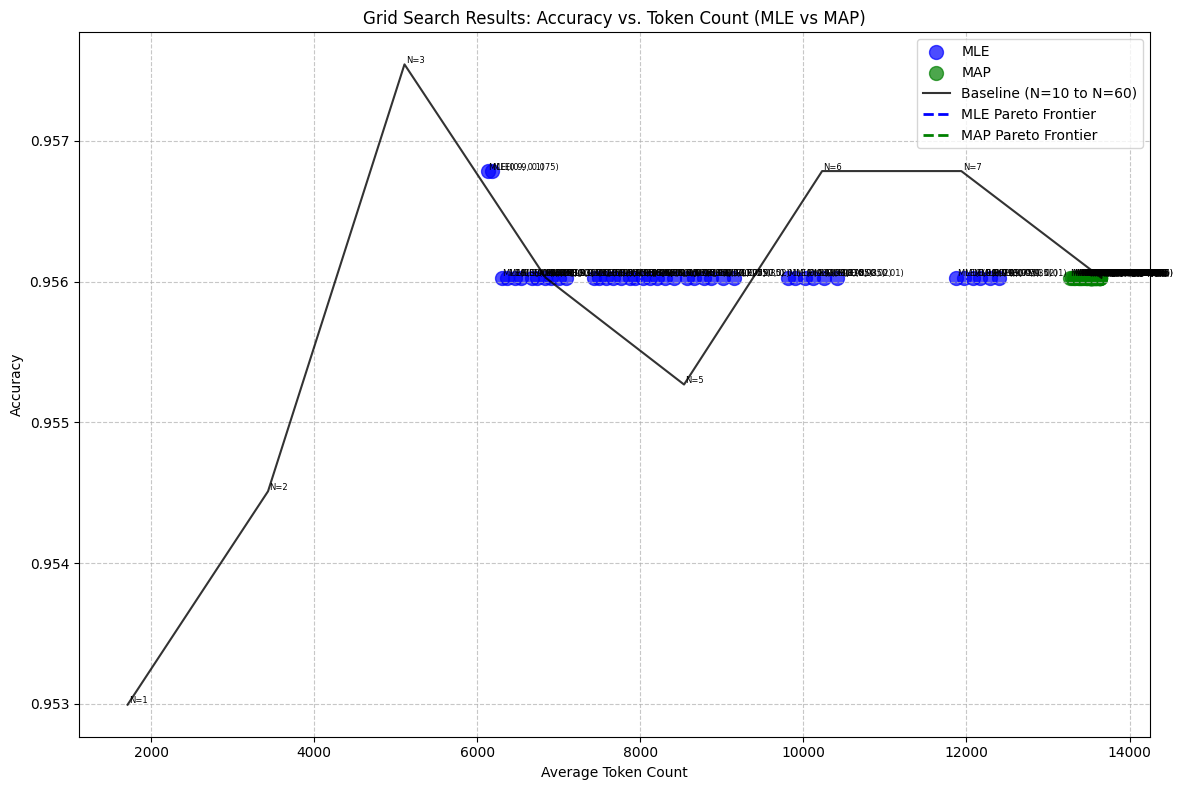


MLE Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9568, Avg Token Count: 6128.18

MAP Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9560, Avg Token Count: 13268.24


In [5]:
# Setting Panels
target_score_panel_values = [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
percentile_panel_values = [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
max_N_panel = 8
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [6]:
peek_number = 5

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.4319      0.0916    0.9862    0.0091    0.7452    0.2141    0.9875    0.0155
1         0.3712      0.0375    0.9846    0.0012    0.6830    0.2339    0.9844    0.0059
2         0.6217      0.1013    0.9424    0.0070    0.9365    0.0111    0.9271    0.0150
3         0.4076      0.0870    0.9861    0.0155    0.7042    0.2330    0.9839    0.0128
4         0.4718      0.1396    0.9744    0.0057    0.7823    0.1972    0.9720    0.0102
5         0.5645      0.0934    0.9641    0.0069    0.8647    0.0860    0.9692    0.0096
6         0.4193      0.0764    0.9916    0.0039    0.7328    0.2210    0.9922    0.0060
7         0.4935      0.1110    0.8475    0.0701    0.8042    0.0829    0.8624    0.0766
8         0.4501      0.1188    0.9854    0.0021    0.7513    0.2178    0.9827    0.0046
9         0.4603      0.1372    0.9952    0.0033    0.7460    0.2317    0.9985    0.0078
10        0.3858      0.0913    0.9801    0.0073    0.6636    0.2544    0.9879    0.0080
11        0.3843     

Target Score Panel: [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 16

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9591, Average Token Count: 10901.12
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9591, Average Token Count: 10714.01
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9591, Average Token Count: 10528.83
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9591, Average Token Count: 10433.10
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9591, Average Token Count: 10297.10
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

Target Score (MLE):  14%|█▍        | 1/7 [01:51<11:11, 111.85s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9591, Average Token Count: 10192.19


MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 6, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5

MLE - Target Score: 0.93, Percentile: 0.01
MLE - Accuracy: 0.9583, Average Token Count: 11987.84
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 6, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 11, 

MLE - Target Score: 0.93, Percentile: 0.02
MLE - Accuracy: 0.9591, Average Token Count: 11742.95
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 16, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5,

MLE - Target Score: 0.93, Percentile: 0.035
MLE - Accuracy: 0.9591, Average Token Count: 11506.52
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5

MLE - Target Score: 0.93, Percentile: 0.05
MLE - Accuracy: 0.9591, Average Token Count: 11359.37
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5,

MLE - Target Score: 0.93, Percentile: 0.075
MLE - Accuracy: 0.9591, Average Token Count: 11168.10
MLE Min N Required [5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5,

Target Score (MLE):  29%|██▊       | 2/7 [03:44<09:21, 112.36s/it]

MLE - Target Score: 0.93, Percentile: 0.1
MLE - Accuracy: 0.9591, Average Token Count: 11034.37


MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 9, 5, 6, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 6, 5, 9, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 8, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 6, 5, 5, 11, 5, 5, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 5, 8, 13, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 16, 5, 5, 5, 5, 6, 5, 5, 5, 5, 16, 5, 5, 13, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9583, Average Token Count: 13561.61
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 8, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 8, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 7, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 9, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 6, 11, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 16, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9583, Average Token Count: 13252.49
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 14, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 7, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 6, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 6, 9, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 16, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9583, Average Token Count: 12945.83
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 12, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 6, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 9, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 16, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9591, Average Token Count: 12757.22
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 11, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 6, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 7, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 16, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9591, Average Token Count: 12493.23
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 10, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 15, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 7, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

Target Score (MLE):  43%|████▎     | 3/7 [05:39<07:33, 113.44s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9591, Average Token Count: 12276.63


MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 10, 5, 12, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 14, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 13, 16, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 10, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 13, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 13, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 15, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 16, 5, 5, 5, 11, 12, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 16, 5, 9, 5, 5,

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9583, Average Token Count: 14754.44
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 9, 5, 10, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 12, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 11, 16, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 9, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 11, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 13, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9583, Average Token Count: 14462.46
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 8, 5, 9, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 10, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 10, 16, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 8, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 10, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 11, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9583, Average Token Count: 14188.91
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 7, 5, 8, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 9, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 9, 16, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 9, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 10, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9583, Average Token Count: 13983.70
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 6, 5, 7, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 8, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 8, 16, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 8, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 9, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9583, Average Token Count: 13682.22
MLE Min N Required [5, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 6, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 7, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 7, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 8, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

Target Score (MLE):  57%|█████▋    | 4/7 [07:35<05:43, 114.49s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9591, Average Token Count: 13474.60


MLE Min N Required [5, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 16, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 6, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 8, 5, 13, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 8, 5, 16, 5, 16, 5, 5, 5, 10, 5, 5, 5, 13, 7, 6, 5, 16, 11, 16, 6, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 8, 5, 5, 5, 9, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 15, 5, 5, 5, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 8, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 9, 5, 5, 5, 5, 5, 16, 5, 7, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 15, 5, 5, 5, 5, 16, 5, 5, 5, 16, 16, 5, 5, 5, 9, 16, 5, 5, 16, 5, 5, 16, 5

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9583, Average Token Count: 16181.68
MLE Min N Required [5, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 7, 5, 11, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 14, 5, 5, 5, 16, 5, 5, 5, 5, 7, 5, 16, 5, 16, 5, 5, 5, 8, 5, 5, 5, 11, 6, 6, 5, 16, 9, 16, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 7, 5, 5, 5, 7, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 13, 5, 5, 5, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 7, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 8, 5, 5, 5, 5, 5, 16, 5, 6, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9583, Average Token Count: 15885.30
MLE Min N Required [5, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 6, 5, 9, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 12, 5, 5, 5, 16, 5, 5, 5, 5, 6, 5, 16, 5, 16, 5, 5, 5, 7, 5, 5, 5, 9, 5, 5, 5, 16, 8, 16, 5, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 5, 5, 16, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 6, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 7, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9583, Average Token Count: 15598.88
MLE Min N Required [5, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 16, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 16, 16, 15, 5, 11, 5, 5, 5, 16, 5, 5, 5, 5, 6, 5, 16, 5, 16, 5, 5, 5, 7, 5, 5, 5, 8, 5, 5, 5, 16, 7, 16, 5, 5, 16, 16, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 14, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 6, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5,

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9583, Average Token Count: 15385.67
MLE Min N Required [5, 5, 16, 5, 5, 14, 5, 16, 5, 5, 5, 5, 13, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 16, 16, 13, 5, 10, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 6, 5, 5, 5, 7, 5, 5, 5, 16, 6, 16, 5, 5, 16, 16, 5, 13, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 12, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9583, Average Token Count: 15132.47
MLE Min N Required [5, 5, 16, 5, 5, 12, 5, 16, 5, 5, 5, 5, 12, 5, 5, 5, 5, 5, 5, 5, 15, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 14, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 16, 16, 11, 5, 9, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 16, 6, 16, 5, 5, 16, 16, 5, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 14, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 5, 5, 5, 11, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 14, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

Target Score (MLE):  71%|███████▏  | 5/7 [09:34<03:52, 116.24s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9583, Average Token Count: 14903.44


MLE Min N Required [5, 5, 16, 6, 16, 16, 5, 16, 5, 5, 8, 10, 16, 8, 5, 5, 14, 15, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 5, 16, 16, 7, 16, 16, 5, 7, 8, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 11, 16, 5, 7, 5, 5, 5, 5, 5, 16, 5, 7, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 12, 16, 12, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 16, 16, 16, 12, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 8, 7, 5, 16, 16, 16, 5, 5, 14, 5, 5, 16, 5, 7, 5, 13, 9, 16, 5, 5, 16, 16, 16, 16, 5, 5, 5, 5, 5, 8, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 7, 15, 16, 5, 5, 16, 5, 5, 5, 5, 13, 16, 16, 5, 5, 16, 9, 5, 5, 16, 5, 7, 5, 16, 16, 6, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 13, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 11, 5, 5, 16, 5, 6, 5, 5, 5, 16, 5, 13, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 9, 16, 16, 16, 12, 5, 5, 12, 16, 5, 5, 5, 5, 5, 9, 9, 5, 5, 5, 16, 5, 5, 5, 5, 16, 5, 12, 5, 16, 16, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9583, Average Token Count: 18609.26
MLE Min N Required [5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 7, 9, 16, 7, 5, 5, 12, 12, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 16, 16, 6, 16, 16, 5, 6, 7, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 9, 16, 5, 6, 5, 5, 5, 5, 5, 16, 5, 6, 16, 5, 5, 16, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 10, 16, 10, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 16, 16, 16, 11, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 7, 6, 5, 16, 16, 16, 5, 5, 12, 5, 5, 16, 5, 6, 5, 11, 8, 16, 5, 5, 16, 16, 16, 14, 5, 5, 5, 5, 5, 7, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 6, 13, 16, 5, 5, 16, 5, 5, 5, 5, 11, 16, 16, 5, 5, 16, 8, 5, 5, 16, 5, 6, 5, 16, 15, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 11, 16, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 10, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 11, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 8, 16,

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9583, Average Token Count: 18304.97
MLE Min N Required [5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 6, 8, 16, 6, 5, 5, 10, 11, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 5, 6, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 8, 16, 5, 6, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 14, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 9, 16, 9, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 16, 16, 16, 9, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 5, 6, 5, 5, 16, 16, 16, 5, 5, 10, 5, 5, 16, 5, 5, 5, 9, 7, 16, 5, 5, 16, 16, 16, 12, 5, 5, 5, 5, 5, 6, 5, 5, 16, 5, 5, 16, 5, 5, 5, 16, 5, 11, 16, 5, 5, 16, 5, 5, 5, 5, 10, 16, 16, 5, 5, 16, 7, 5, 5, 16, 5, 5, 5, 16, 13, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 9, 16, 5, 5, 5, 5, 15, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 8, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 9, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 7, 14, 16, 16

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9583, Average Token Count: 18013.26
MLE Min N Required [5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 5, 7, 16, 5, 5, 5, 9, 10, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 7, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 12, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 8, 16, 8, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 16, 16, 5, 16, 16, 16, 8, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 16, 5, 5, 6, 5, 5, 16, 16, 16, 5, 5, 9, 5, 5, 16, 5, 5, 5, 8, 6, 16, 5, 5, 16, 16, 16, 11, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 15, 5, 5, 5, 16, 5, 10, 16, 5, 5, 16, 5, 5, 5, 5, 9, 16, 16, 5, 5, 16, 6, 5, 5, 16, 5, 5, 5, 16, 12, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 8, 16, 5, 5, 5, 5, 14, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 8, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 8, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 6, 12, 16, 16, 

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9583, Average Token Count: 17762.22
MLE Min N Required [5, 5, 16, 5, 16, 16, 5, 16, 5, 5, 5, 6, 16, 5, 5, 5, 8, 8, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 6, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 11, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 15, 5, 5, 5, 16, 5, 5, 5, 7, 16, 7, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 14, 16, 5, 16, 16, 16, 7, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 8, 5, 5, 16, 5, 5, 5, 7, 5, 16, 5, 5, 16, 16, 16, 9, 5, 5, 5, 5, 5, 5, 5, 5, 14, 5, 5, 13, 5, 5, 5, 16, 5, 9, 16, 5, 5, 16, 5, 5, 5, 5, 8, 16, 16, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 10, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 12, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 7, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 7, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 11, 16, 16, 7, 5

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9583, Average Token Count: 17465.70
MLE Min N Required [5, 5, 16, 5, 15, 16, 5, 16, 5, 5, 5, 5, 16, 5, 5, 5, 7, 8, 5, 5, 16, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 16, 16, 5, 16, 16, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 16, 5, 16, 6, 16, 5, 5, 5, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 10, 5, 16, 5, 5, 5, 5, 5, 5, 16, 16, 16, 5, 13, 5, 5, 5, 16, 5, 5, 5, 6, 14, 6, 16, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 13, 16, 5, 16, 16, 16, 6, 5, 16, 16, 5, 16, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 16, 5, 5, 5, 5, 5, 16, 16, 16, 5, 5, 7, 5, 5, 16, 5, 5, 5, 7, 5, 16, 5, 5, 16, 16, 16, 8, 5, 5, 5, 5, 5, 5, 5, 5, 12, 5, 5, 12, 5, 5, 5, 16, 5, 8, 16, 5, 5, 16, 5, 5, 5, 5, 7, 16, 16, 5, 5, 16, 5, 5, 5, 16, 5, 5, 5, 16, 9, 5, 5, 16, 5, 5, 5, 5, 5, 5, 16, 5, 5, 5, 5, 5, 5, 5, 7, 16, 5, 5, 5, 5, 11, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 16, 6, 5, 5, 16, 5, 5, 5, 5, 5, 16, 5, 7, 5, 16, 5, 5, 16, 5, 5, 5, 5, 5, 5, 9, 16, 16, 6, 5,

Target Score (MLE):  86%|████████▌ | 6/7 [11:38<01:58, 118.90s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9583, Average Token Count: 17232.56


MLE Min N Required [15, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 15, 10, 11, 16, 16, 5, 16, 16, 16, 5, 5, 7, 5, 16, 5, 16, 5, 16, 16, 5, 5, 8, 16, 12, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 9, 6, 5, 16, 5, 6, 16, 6, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 9, 8, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 5, 9, 7, 16, 16, 16, 14, 16, 16, 16, 16, 5, 16, 16, 9, 16, 10, 6, 7, 5, 16, 16, 16, 5, 7, 16, 5, 5, 16, 6, 16, 16, 16, 5, 7, 16, 16, 12, 16, 16, 16, 12, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 5, 9, 16, 16, 16, 16, 5, 5, 9, 8, 5, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 16, 16, 16, 16, 6, 16, 16, 5, 16, 8, 5, 16, 16, 16, 11, 16, 16, 16, 8, 6, 16, 5, 16, 6, 16, 16, 16, 5, 16, 9, 5, 9, 5, 16, 5, 16, 5, 16, 11, 5, 11, 7, 5, 16, 16, 16, 16, 6, 9, 16, 16, 5, 16, 16, 12, 16, 11, 12, 8, 5, 16, 16, 11, 5, 16, 16, 16, 7, 5, 7, 16, 12, 16, 5, 16, 6, 7, 16, 5, 16, 14, 11, 5, 16, 16, 16, 16, 16, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9583, Average Token Count: 23295.50
MLE Min N Required [12, 16, 16, 14, 16, 16, 5, 16, 16, 5, 16, 16, 16, 13, 9, 10, 16, 16, 5, 16, 16, 16, 5, 5, 6, 5, 16, 5, 16, 5, 16, 16, 5, 5, 7, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 8, 6, 5, 16, 5, 5, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 8, 7, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 5, 8, 6, 16, 16, 16, 12, 16, 16, 16, 16, 5, 16, 16, 8, 16, 9, 5, 6, 5, 16, 16, 16, 5, 6, 16, 5, 5, 16, 5, 16, 16, 16, 5, 6, 16, 16, 10, 16, 16, 16, 10, 5, 16, 14, 5, 16, 16, 16, 16, 16, 16, 16, 5, 8, 16, 16, 16, 16, 5, 5, 8, 7, 5, 16, 16, 16, 16, 5, 13, 16, 16, 5, 5, 16, 15, 16, 16, 5, 16, 16, 5, 16, 7, 5, 16, 16, 16, 10, 16, 16, 16, 7, 5, 16, 5, 16, 5, 16, 16, 16, 5, 16, 8, 5, 8, 5, 16, 5, 16, 5, 16, 9, 5, 10, 6, 5, 16, 16, 16, 15, 5, 8, 16, 16, 5, 16, 16, 10, 16, 10, 11, 7, 5, 16, 16, 9

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9583, Average Token Count: 22929.80
MLE Min N Required [11, 16, 16, 12, 16, 16, 5, 16, 16, 5, 16, 16, 16, 11, 8, 8, 16, 16, 5, 16, 16, 16, 5, 5, 5, 5, 16, 5, 16, 5, 16, 16, 5, 5, 6, 15, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 7, 5, 5, 15, 5, 5, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 14, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 7, 6, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 5, 7, 5, 16, 16, 16, 11, 16, 16, 16, 16, 5, 16, 16, 7, 16, 8, 5, 5, 5, 16, 14, 16, 5, 5, 16, 5, 5, 16, 5, 16, 16, 16, 5, 5, 16, 16, 9, 16, 16, 16, 9, 5, 16, 12, 5, 16, 16, 16, 16, 16, 16, 16, 5, 7, 16, 16, 16, 16, 5, 5, 7, 6, 5, 16, 16, 16, 16, 5, 12, 16, 16, 5, 5, 16, 13, 16, 16, 5, 16, 16, 5, 16, 6, 5, 16, 16, 16, 8, 16, 16, 16, 6, 5, 16, 5, 14, 5, 16, 16, 16, 5, 16, 7, 5, 7, 5, 16, 5, 16, 5, 16, 8, 5, 8, 5, 5, 16, 16, 16, 13, 5, 7, 16, 16, 5, 16, 16, 9, 16, 8, 9, 6, 5, 16, 16, 8, 5, 16, 

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9583, Average Token Count: 22554.00
MLE Min N Required [10, 16, 16, 11, 16, 16, 5, 16, 16, 5, 16, 16, 16, 10, 7, 7, 16, 16, 5, 14, 16, 16, 5, 5, 5, 5, 16, 5, 16, 5, 16, 16, 5, 5, 6, 14, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 6, 5, 5, 14, 5, 5, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 5, 5, 16, 5, 13, 16, 16, 16, 16, 15, 16, 5, 15, 16, 16, 6, 6, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 5, 6, 5, 16, 16, 16, 9, 16, 16, 16, 16, 5, 16, 16, 6, 16, 7, 5, 5, 5, 16, 12, 16, 5, 5, 15, 5, 5, 16, 5, 16, 16, 16, 5, 5, 16, 16, 8, 16, 16, 16, 8, 5, 16, 11, 5, 16, 16, 16, 16, 16, 16, 16, 5, 6, 16, 16, 16, 16, 5, 5, 6, 6, 5, 16, 16, 16, 16, 5, 11, 16, 16, 5, 5, 16, 12, 16, 16, 5, 16, 16, 5, 16, 5, 5, 16, 16, 16, 7, 16, 16, 16, 5, 5, 16, 5, 13, 5, 16, 16, 16, 5, 16, 6, 5, 6, 5, 16, 5, 16, 5, 16, 7, 5, 7, 5, 5, 16, 16, 16, 12, 5, 6, 16, 16, 5, 16, 16, 8, 16, 7, 8, 5, 5, 16, 16, 7, 5, 16, 

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9583, Average Token Count: 22277.14
MLE Min N Required [8, 16, 16, 9, 16, 16, 5, 16, 16, 5, 16, 16, 16, 9, 6, 7, 16, 16, 5, 12, 16, 16, 5, 5, 5, 5, 16, 5, 16, 5, 16, 16, 5, 5, 5, 12, 7, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 13, 5, 5, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 5, 5, 16, 5, 11, 16, 16, 16, 16, 13, 16, 5, 13, 16, 16, 5, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 16, 8, 16, 16, 16, 16, 5, 16, 16, 6, 16, 6, 5, 5, 5, 14, 11, 16, 5, 5, 13, 5, 5, 16, 5, 16, 16, 16, 5, 5, 16, 16, 7, 16, 16, 16, 7, 5, 16, 9, 5, 16, 16, 16, 16, 14, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 5, 5, 5, 16, 16, 16, 16, 5, 9, 16, 16, 5, 5, 16, 10, 16, 16, 5, 16, 16, 5, 16, 5, 5, 16, 16, 16, 7, 16, 16, 16, 5, 5, 16, 5, 11, 5, 16, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 16, 6, 5, 7, 5, 5, 16, 16, 16, 10, 5, 5, 16, 16, 5, 16, 16, 7, 16, 7, 7, 5, 5, 16, 16, 7, 5, 16, 13, 16

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9583, Average Token Count: 21925.57
MLE Min N Required [8, 16, 16, 8, 16, 16, 5, 16, 16, 5, 16, 16, 16, 8, 5, 6, 16, 16, 5, 11, 16, 16, 5, 5, 5, 5, 16, 5, 16, 5, 16, 16, 5, 5, 5, 11, 6, 16, 16, 16, 16, 16, 5, 16, 16, 16, 5, 5, 5, 5, 5, 12, 5, 5, 16, 5, 5, 16, 16, 16, 16, 14, 16, 16, 16, 12, 16, 16, 5, 5, 16, 5, 10, 16, 16, 16, 16, 12, 16, 5, 11, 16, 16, 5, 5, 16, 16, 16, 5, 16, 5, 5, 5, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 5, 5, 16, 5, 5, 5, 16, 16, 16, 7, 16, 16, 16, 16, 5, 16, 16, 5, 16, 5, 5, 5, 5, 13, 10, 16, 5, 5, 11, 5, 5, 16, 5, 16, 16, 16, 5, 5, 16, 16, 6, 16, 16, 16, 6, 5, 16, 8, 5, 16, 16, 16, 16, 13, 16, 16, 5, 5, 16, 16, 16, 16, 5, 5, 5, 5, 5, 15, 16, 14, 16, 5, 8, 16, 16, 5, 5, 16, 9, 16, 16, 5, 16, 16, 5, 16, 5, 5, 16, 16, 16, 6, 16, 16, 16, 5, 5, 16, 5, 10, 5, 16, 16, 16, 5, 16, 5, 5, 5, 5, 16, 5, 16, 5, 16, 6, 5, 6, 5, 5, 16, 16, 16, 9, 5, 5, 16, 16, 5, 16, 16, 6, 16, 6, 6, 5, 5, 16, 16, 6, 5, 16, 11, 16,

Target Score (MLE): 100%|██████████| 7/7 [13:55<00:00, 119.33s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9583, Average Token Count: 21665.51

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [16, 16, 5, 16, 16, 13, 16, 16, 16, 16, 16, 16, 7, 5, 16, 16, 13, 16, 16, 14, 5, 5, 5, 5, 16, 16, 5, 16, 8, 16, 16, 5, 6, 7, 5, 6, 16, 5, 16, 7, 16, 5, 5, 16, 6, 16, 8, 9, 5, 13, 16, 16, 12, 5, 14, 16, 5, 9, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 6, 12, 5, 16, 10, 16, 7, 5, 16, 16, 16, 6, 5, 16, 16, 16, 11, 16, 8, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 9, 5, 16, 16, 16, 15, 5, 16, 16, 11, 16, 6, 16, 16, 16, 5, 16, 16, 11, 9, 16, 16, 11, 16, 12, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 11, 16, 5, 16, 16, 16, 16, 8, 5, 5, 10, 16, 5, 5, 16, 9, 5, 16, 16, 5, 6, 16, 16, 16, 5, 5, 16, 16, 16, 15, 5, 16, 16, 10, 10, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 9, 16, 5, 16, 16, 5, 5, 16, 16, 13, 16, 5, 5, 16, 16, 9, 16, 16, 16, 6, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 11, 10, 16, 5, 16, 5, 16, 16, 10, 16, 5, 5, 16, 14, 16, 13, 16, 5, 16, 16, 16, 16, 16, 16, 7, 16, 10, 16, 5, 12, 16, 9, 16, 16, 5, 16, 5, 13, 5, 16, 6, 15, 16, 16, 16, 7, 16, 10, 16, 8, 5

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9583, Average Token Count: 21201.11
MAP Min N Required [16, 16, 5, 16, 16, 12, 16, 16, 16, 16, 16, 16, 6, 5, 16, 16, 11, 16, 16, 12, 5, 5, 5, 5, 16, 16, 5, 16, 7, 16, 16, 5, 5, 6, 5, 5, 16, 5, 16, 6, 16, 5, 5, 16, 5, 16, 7, 8, 5, 11, 16, 16, 10, 5, 12, 16, 5, 8, 16, 5, 16, 14, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 5, 11, 5, 16, 9, 16, 6, 5, 16, 16, 16, 5, 5, 16, 16, 16, 9, 16, 7, 16, 15, 5, 16, 16, 16, 16, 16, 5, 16, 5, 14, 16, 7, 5, 16, 16, 16, 13, 5, 16, 16, 9, 16, 5, 16, 16, 16, 5, 16, 16, 9, 8, 14, 16, 9, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 16, 5, 16, 16, 16, 15, 7, 5, 5, 8, 16, 5, 5, 16, 7, 5, 16, 16, 5, 5, 16, 16, 16, 5, 5, 16, 16, 16, 12, 5, 16, 16, 9, 9, 16, 16, 16, 16, 16, 15, 16, 5, 5, 16, 8, 16, 5, 16, 16, 5, 5, 16, 16, 12, 16, 5, 5, 16, 16, 8, 16, 16, 16, 5, 5, 14, 16, 16, 16, 16, 16, 5, 15, 16, 10, 8, 16, 5, 16, 5, 16, 16, 9, 16, 5, 5, 16, 12, 16, 11, 16, 5, 16, 16, 16, 16, 16, 16, 6, 16, 9, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 20601.25
MAP Min N Required [16, 16, 5, 16, 16, 10, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 9, 16, 16, 11, 5, 5, 5, 5, 16, 16, 5, 16, 6, 16, 15, 5, 5, 5, 5, 5, 16, 5, 16, 6, 16, 5, 5, 16, 5, 16, 6, 7, 5, 10, 16, 16, 9, 5, 10, 16, 5, 7, 16, 5, 16, 12, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 15, 5, 9, 5, 16, 8, 16, 5, 5, 16, 16, 16, 5, 5, 16, 16, 16, 8, 16, 6, 16, 13, 5, 16, 16, 16, 16, 16, 5, 16, 5, 12, 16, 6, 5, 16, 16, 13, 11, 5, 16, 16, 8, 16, 5, 16, 16, 16, 5, 16, 16, 8, 7, 12, 16, 8, 16, 9, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 9, 16, 5, 16, 16, 16, 13, 6, 5, 5, 7, 16, 5, 5, 16, 6, 5, 16, 16, 5, 5, 16, 16, 16, 5, 5, 16, 16, 16, 11, 5, 14, 16, 7, 8, 16, 16, 15, 16, 16, 13, 16, 5, 5, 16, 7, 16, 5, 16, 16, 5, 5, 16, 16, 10, 16, 5, 5, 16, 16, 7, 16, 16, 16, 5, 5, 12, 16, 16, 16, 16, 16, 5, 13, 16, 8, 7, 16, 5, 16, 5, 16, 16, 7, 16, 5, 5, 16, 10, 16, 9, 16, 5, 16, 16, 16, 16, 16, 14, 5, 16, 8, 16, 5, 

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 20010.45
MAP Min N Required [16, 16, 5, 16, 16, 9, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 9, 16, 16, 9, 5, 5, 5, 5, 16, 16, 5, 16, 5, 16, 14, 5, 5, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 16, 5, 16, 5, 6, 5, 9, 16, 16, 8, 5, 9, 16, 5, 6, 16, 5, 15, 11, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 13, 5, 8, 5, 16, 7, 16, 5, 5, 16, 16, 16, 5, 5, 16, 16, 16, 7, 16, 6, 16, 11, 5, 16, 16, 16, 16, 16, 5, 16, 5, 11, 16, 6, 5, 16, 16, 12, 10, 5, 16, 16, 7, 16, 5, 16, 16, 16, 5, 16, 16, 7, 6, 11, 16, 7, 16, 8, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 8, 16, 5, 16, 16, 16, 11, 5, 5, 5, 6, 16, 5, 5, 16, 6, 5, 16, 16, 5, 5, 16, 16, 16, 5, 5, 16, 16, 16, 10, 5, 13, 16, 7, 7, 16, 16, 14, 16, 16, 11, 16, 5, 5, 16, 6, 16, 5, 16, 16, 5, 5, 16, 16, 9, 16, 5, 5, 16, 16, 6, 16, 16, 16, 5, 5, 11, 16, 16, 16, 16, 16, 5, 12, 16, 8, 6, 16, 5, 16, 5, 16, 16, 7, 16, 5, 5, 16, 9, 16, 8, 16, 5, 16, 16, 16, 16, 16, 12, 5, 16, 7, 16, 5, 8, 16

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 19589.00
MAP Min N Required [16, 16, 5, 16, 15, 8, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 7, 16, 16, 8, 5, 5, 5, 5, 16, 16, 5, 14, 5, 16, 12, 5, 5, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 8, 16, 16, 7, 5, 8, 16, 5, 5, 16, 5, 13, 9, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 11, 5, 7, 5, 16, 6, 16, 5, 5, 16, 16, 16, 5, 5, 16, 16, 16, 6, 16, 5, 16, 10, 5, 16, 16, 16, 16, 16, 5, 16, 5, 10, 16, 5, 5, 16, 16, 10, 9, 5, 16, 16, 6, 16, 5, 16, 16, 16, 5, 16, 16, 6, 5, 9, 16, 6, 16, 7, 16, 16, 15, 16, 16, 5, 16, 16, 16, 16, 7, 16, 5, 16, 16, 16, 10, 5, 5, 5, 6, 16, 5, 5, 16, 5, 5, 16, 16, 5, 5, 16, 14, 16, 5, 5, 16, 16, 16, 8, 5, 11, 16, 6, 6, 16, 15, 12, 16, 16, 10, 16, 5, 5, 16, 5, 16, 5, 16, 16, 5, 5, 14, 16, 8, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 5, 9, 16, 16, 16, 16, 16, 5, 10, 16, 7, 6, 16, 5, 16, 5, 16, 16, 6, 16, 5, 5, 16, 8, 16, 7, 16, 5, 16, 16, 16, 15, 16, 11, 5, 16, 6, 16, 5, 7, 16, 5, 1

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 19022.46
MAP Min N Required [16, 16, 5, 16, 14, 7, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 7, 16, 16, 7, 5, 5, 5, 5, 16, 16, 5, 12, 5, 16, 11, 5, 5, 5, 5, 5, 16, 5, 16, 5, 16, 5, 5, 16, 5, 16, 5, 5, 5, 7, 16, 16, 6, 5, 7, 16, 5, 5, 16, 5, 11, 8, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 10, 5, 6, 5, 16, 5, 16, 5, 5, 16, 16, 16, 5, 5, 16, 16, 16, 6, 16, 5, 16, 9, 5, 16, 16, 16, 16, 16, 5, 15, 5, 9, 16, 5, 5, 16, 16, 9, 8, 5, 16, 16, 6, 16, 5, 16, 16, 16, 5, 16, 16, 6, 5, 8, 16, 6, 16, 6, 16, 14, 13, 16, 16, 5, 16, 16, 16, 16, 6, 16, 5, 16, 16, 16, 9, 5, 5, 5, 5, 16, 5, 5, 16, 5, 5, 15, 16, 5, 5, 16, 13, 16, 5, 5, 16, 16, 16, 8, 5, 10, 16, 5, 5, 16, 13, 11, 16, 16, 9, 15, 5, 5, 16, 5, 16, 5, 16, 16, 5, 5, 12, 16, 7, 16, 5, 5, 16, 16, 5, 16, 16, 16, 5, 5, 8, 16, 16, 16, 16, 16, 5, 9, 16, 6, 5, 16, 5, 16, 5, 16, 16, 5, 16, 5, 5, 16, 7, 16, 7, 16, 5, 14, 16, 16, 14, 16, 10, 5, 16, 5, 16, 5, 6, 16, 5, 16, 16

Target Score (MAP):  14%|█▍        | 1/7 [02:16<13:37, 136.30s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 18553.70


MAP Min N Required [16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 5, 16, 16, 16, 16, 16, 16, 5, 8, 5, 5, 16, 16, 6, 16, 13, 16, 16, 5, 9, 11, 5, 9, 16, 6, 16, 12, 16, 5, 5, 16, 10, 16, 14, 15, 5, 16, 16, 16, 16, 6, 16, 16, 5, 14, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 9, 16, 5, 16, 16, 16, 10, 8, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 13, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 14, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 5, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 12, 5, 5, 15, 16, 6, 5, 16, 13, 9, 16, 16, 5, 9, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 15, 16, 5, 16, 16, 7, 7, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 10, 8, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 15, 16, 5, 16, 7, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 5, 16, 16, 15, 16, 16, 5, 16, 5, 16, 5, 16, 9, 16, 16, 16, 16

MAP - Target Score: 0.93, Percentile: 0.01
MAP - Accuracy: 0.9583, Average Token Count: 23019.91
MAP Min N Required [16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 5, 16, 16, 16, 16, 16, 16, 5, 7, 5, 5, 16, 16, 5, 16, 11, 16, 16, 5, 8, 9, 5, 8, 16, 5, 16, 10, 16, 5, 5, 16, 9, 16, 12, 13, 5, 16, 16, 16, 16, 5, 16, 16, 5, 12, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 8, 16, 5, 16, 14, 16, 9, 7, 16, 16, 16, 14, 5, 16, 16, 16, 14, 16, 11, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 12, 5, 16, 16, 16, 16, 5, 16, 16, 15, 16, 8, 16, 16, 16, 5, 16, 16, 16, 12, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 5, 5, 13, 16, 5, 5, 16, 11, 8, 16, 16, 5, 8, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 14, 14, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 13, 16, 5, 16, 16, 6, 6, 16, 16, 16, 16, 5, 5, 16, 16, 14, 16, 16, 16, 9, 7, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 13, 16, 5, 16, 6, 16, 16, 14, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 1

MAP - Target Score: 0.93, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 22557.58
MAP Min N Required [16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 5, 16, 16, 15, 16, 16, 16, 5, 6, 5, 5, 16, 16, 5, 16, 9, 16, 16, 5, 7, 8, 5, 7, 16, 5, 16, 9, 16, 5, 5, 16, 7, 16, 10, 11, 5, 15, 16, 16, 14, 5, 16, 16, 5, 10, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 7, 15, 5, 16, 12, 16, 8, 6, 16, 16, 16, 12, 5, 16, 16, 16, 12, 16, 10, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 10, 5, 16, 16, 16, 16, 5, 16, 16, 13, 16, 7, 16, 16, 16, 5, 16, 16, 13, 11, 16, 16, 13, 16, 15, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 13, 16, 5, 16, 16, 16, 16, 9, 5, 5, 11, 16, 5, 5, 16, 10, 7, 16, 16, 5, 7, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 12, 12, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 11, 16, 5, 16, 16, 6, 6, 16, 16, 16, 16, 5, 5, 16, 16, 12, 16, 16, 16, 8, 6, 16, 16, 16, 16, 16, 16, 5, 16, 16, 13, 11, 16, 5, 16, 5, 16, 16, 12, 16, 5, 5, 16, 16, 16, 15, 16, 5, 16, 16, 16, 

MAP - Target Score: 0.93, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 22072.41
MAP Min N Required [16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 5, 16, 16, 14, 16, 16, 15, 5, 5, 5, 5, 16, 16, 5, 16, 8, 16, 16, 5, 6, 7, 5, 6, 16, 5, 16, 8, 16, 5, 5, 16, 7, 16, 9, 10, 5, 14, 16, 16, 12, 5, 15, 16, 5, 9, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 6, 13, 5, 16, 11, 16, 7, 6, 16, 16, 16, 11, 5, 16, 16, 16, 11, 16, 9, 16, 16, 6, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 9, 5, 16, 16, 16, 16, 5, 16, 16, 11, 16, 6, 16, 16, 16, 5, 16, 16, 12, 9, 16, 16, 11, 16, 13, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 12, 16, 5, 16, 16, 16, 16, 8, 5, 5, 10, 16, 5, 5, 16, 9, 6, 16, 16, 5, 6, 16, 16, 16, 5, 5, 16, 16, 16, 15, 5, 16, 16, 11, 11, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 10, 16, 5, 16, 16, 5, 5, 16, 16, 14, 16, 5, 5, 16, 16, 11, 16, 16, 16, 7, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 12, 10, 16, 5, 16, 5, 16, 16, 11, 16, 5, 5, 16, 14, 16, 14, 16, 5, 16, 16, 16, 16, 16

MAP - Target Score: 0.93, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 21679.12
MAP Min N Required [16, 16, 5, 16, 16, 14, 16, 16, 16, 16, 16, 16, 8, 5, 16, 16, 12, 16, 16, 13, 5, 5, 5, 5, 16, 16, 5, 16, 7, 16, 16, 5, 5, 6, 5, 6, 16, 5, 16, 7, 16, 5, 5, 16, 6, 16, 8, 8, 5, 12, 16, 16, 11, 5, 13, 16, 5, 8, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 6, 11, 5, 16, 10, 16, 6, 5, 16, 16, 16, 9, 5, 16, 16, 16, 10, 16, 8, 16, 15, 5, 16, 16, 16, 16, 16, 5, 16, 5, 15, 16, 8, 5, 16, 16, 16, 14, 5, 16, 16, 10, 16, 6, 16, 16, 16, 5, 16, 16, 10, 8, 14, 16, 10, 16, 11, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 11, 16, 5, 16, 16, 16, 16, 7, 5, 5, 9, 16, 5, 5, 16, 8, 5, 16, 16, 5, 5, 16, 16, 16, 5, 5, 16, 16, 16, 13, 5, 16, 16, 10, 10, 16, 16, 16, 16, 16, 16, 16, 5, 5, 16, 9, 16, 5, 16, 16, 5, 5, 16, 16, 12, 16, 5, 5, 16, 16, 10, 16, 16, 16, 6, 5, 15, 16, 16, 16, 16, 16, 5, 16, 16, 10, 9, 16, 5, 16, 5, 16, 16, 9, 16, 5, 5, 16, 12, 16, 12, 16, 5, 16, 16, 16, 16, 16, 16, 6

MAP - Target Score: 0.93, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 21131.56
MAP Min N Required [16, 16, 5, 16, 16, 12, 16, 16, 16, 16, 16, 16, 7, 5, 16, 16, 11, 16, 16, 11, 5, 5, 5, 5, 16, 16, 5, 16, 7, 16, 16, 5, 5, 6, 5, 5, 16, 5, 16, 6, 16, 5, 5, 16, 5, 16, 7, 8, 5, 11, 16, 16, 10, 5, 12, 16, 5, 7, 16, 5, 16, 14, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 5, 10, 5, 16, 9, 16, 5, 5, 16, 16, 16, 8, 5, 16, 16, 16, 9, 16, 7, 16, 14, 5, 16, 16, 16, 16, 16, 5, 16, 5, 14, 16, 7, 5, 16, 16, 15, 13, 5, 16, 16, 9, 16, 5, 16, 16, 16, 5, 16, 16, 9, 7, 13, 16, 9, 16, 10, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 9, 16, 5, 16, 16, 16, 16, 6, 5, 5, 8, 16, 5, 5, 16, 7, 5, 16, 16, 5, 5, 16, 16, 16, 5, 5, 16, 16, 16, 12, 5, 15, 16, 9, 9, 16, 16, 16, 16, 16, 14, 16, 5, 5, 16, 8, 16, 5, 16, 16, 5, 5, 16, 16, 11, 16, 5, 5, 16, 16, 9, 16, 16, 16, 5, 5, 13, 16, 16, 16, 16, 16, 5, 15, 16, 9, 8, 16, 5, 16, 5, 16, 16, 8, 16, 5, 5, 16, 11, 16, 11, 16, 5, 16, 16, 16, 16, 16, 15, 6, 16, 8, 

Target Score (MAP):  29%|██▊       | 2/7 [04:36<11:33, 138.65s/it]

MAP - Target Score: 0.93, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 20682.28


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 8, 12, 5, 8, 16, 16, 9, 16, 16, 16, 16, 5, 14, 16, 7, 14, 16, 10, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 9, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 14, 16, 5, 16, 16, 16, 15, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 15, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 5, 16, 16, 10, 5, 16, 16, 14, 16, 16, 5, 13, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 14, 16, 16, 16, 5, 16, 16, 12, 11, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 8, 16, 11, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 5, 16, 5, 16,

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9583, Average Token Count: 24328.75
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 7, 10, 5, 7, 16, 16, 8, 16, 16, 16, 16, 5, 12, 14, 6, 12, 16, 9, 16, 15, 16, 5, 5, 16, 13, 16, 16, 16, 6, 16, 16, 16, 16, 8, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 12, 16, 5, 16, 16, 16, 13, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 13, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 16, 16, 9, 5, 16, 16, 12, 16, 16, 5, 11, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 12, 16, 16, 16, 5, 16, 16, 10, 9, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 14, 11, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 7, 16, 9, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 24003.79
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 6, 9, 5, 6, 16, 16, 7, 16, 14, 16, 16, 5, 10, 12, 5, 10, 16, 8, 16, 13, 16, 5, 5, 16, 11, 16, 16, 16, 5, 16, 16, 16, 16, 7, 16, 16, 5, 15, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 11, 16, 5, 16, 16, 16, 11, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 11, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 13, 5, 5, 16, 16, 8, 5, 16, 14, 10, 16, 16, 5, 10, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 10, 16, 16, 16, 5, 16, 16, 9, 8, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 12, 9, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 6, 16, 8, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16,

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 23646.23
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 8, 5, 5, 16, 16, 6, 16, 13, 16, 16, 5, 9, 11, 5, 9, 16, 7, 16, 12, 16, 5, 5, 16, 10, 16, 15, 15, 5, 16, 16, 16, 16, 6, 16, 16, 5, 14, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 10, 16, 5, 16, 16, 16, 10, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 14, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 5, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 12, 5, 5, 15, 16, 7, 5, 16, 13, 9, 16, 16, 5, 9, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 9, 16, 15, 16, 5, 16, 16, 8, 7, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 11, 8, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 15, 16, 5, 16, 7, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 5, 

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 23366.75
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 5, 16, 16, 16, 16, 16, 16, 5, 7, 5, 5, 16, 16, 5, 16, 11, 16, 16, 5, 8, 9, 5, 8, 16, 6, 16, 10, 16, 5, 5, 16, 9, 16, 13, 13, 5, 16, 16, 16, 16, 5, 16, 16, 5, 12, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 8, 16, 5, 16, 15, 16, 9, 7, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 11, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 12, 5, 16, 16, 16, 16, 5, 16, 16, 15, 16, 9, 16, 16, 16, 5, 16, 16, 16, 12, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 11, 5, 5, 13, 16, 6, 5, 16, 11, 8, 16, 16, 5, 8, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 15, 15, 16, 16, 16, 16, 16, 16, 16, 5, 8, 16, 13, 16, 5, 16, 16, 7, 6, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 9, 7, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 13, 16, 5, 16, 6, 16, 16, 14, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16,

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 22947.13
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 5, 16, 16, 16, 16, 16, 16, 5, 6, 5, 5, 16, 16, 5, 16, 10, 16, 16, 5, 7, 8, 5, 7, 16, 5, 16, 9, 16, 5, 5, 16, 8, 16, 12, 12, 5, 16, 16, 16, 14, 5, 16, 16, 5, 11, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 7, 16, 5, 16, 13, 16, 8, 7, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 10, 16, 16, 7, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 11, 5, 16, 16, 16, 16, 5, 16, 16, 13, 16, 8, 16, 16, 16, 5, 16, 16, 15, 11, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 14, 16, 5, 16, 16, 16, 16, 9, 5, 5, 12, 16, 5, 5, 16, 10, 7, 16, 16, 5, 7, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 13, 13, 16, 16, 16, 16, 16, 16, 16, 5, 7, 16, 12, 16, 5, 16, 16, 6, 6, 16, 16, 16, 16, 5, 5, 16, 16, 15, 16, 16, 16, 8, 7, 16, 16, 16, 16, 16, 16, 5, 16, 16, 14, 12, 16, 5, 16, 6, 16, 16, 13, 16, 5, 5, 16, 16, 16, 16, 16, 5, 16, 16, 

Target Score (MAP):  43%|████▎     | 3/7 [06:57<09:19, 139.76s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 22568.01


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 10, 15, 5, 10, 16, 16, 12, 16, 16, 16, 16, 5, 16, 16, 10, 16, 16, 15, 16, 16, 16, 10, 6, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 12, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 5, 5, 16, 16, 14, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 7, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 15, 14, 16, 16, 16, 16, 7, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 11, 16, 14, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 7, 16, 5, 1

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9583, Average Token Count: 24921.24
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 9, 13, 5, 9, 16, 16, 10, 16, 16, 16, 16, 5, 16, 16, 8, 15, 16, 13, 16, 16, 16, 8, 6, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 10, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 5, 5, 16, 16, 12, 5, 16, 16, 16, 16, 16, 5, 15, 16, 16, 16, 5, 6, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 13, 12, 16, 16, 16, 16, 6, 5, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 9, 16, 12, 16, 16, 16, 16, 5, 5, 16, 16,

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 24651.84
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 8, 11, 5, 7, 16, 16, 9, 16, 16, 16, 16, 5, 13, 16, 7, 13, 16, 11, 16, 16, 16, 7, 5, 16, 15, 16, 16, 16, 7, 16, 16, 16, 16, 9, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 14, 16, 5, 16, 16, 16, 15, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 14, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 5, 16, 16, 10, 5, 16, 16, 14, 16, 16, 5, 13, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 11, 11, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 8, 16, 10, 16, 16, 16, 16, 5, 5, 16, 16, 16

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 24358.08
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 7, 10, 5, 7, 16, 16, 8, 16, 16, 16, 16, 5, 12, 14, 6, 12, 16, 10, 16, 16, 16, 7, 5, 16, 14, 16, 16, 16, 6, 16, 16, 16, 16, 8, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 12, 16, 5, 16, 16, 16, 13, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 13, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 5, 16, 16, 9, 5, 16, 16, 12, 16, 16, 5, 11, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 10, 9, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 14, 11, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 7, 16, 9, 16, 16, 16, 16, 5, 5, 16, 16, 16, 

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 24127.94
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 6, 9, 5, 6, 16, 16, 7, 16, 14, 16, 16, 5, 11, 12, 6, 10, 16, 9, 16, 14, 16, 6, 5, 16, 12, 16, 16, 16, 6, 16, 16, 16, 16, 7, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 11, 16, 5, 16, 16, 16, 11, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 9, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 11, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 14, 5, 5, 16, 16, 8, 5, 16, 14, 11, 16, 16, 5, 10, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 9, 8, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 12, 10, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 6, 16, 8, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 23825.81
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 8, 5, 5, 16, 16, 6, 16, 13, 16, 16, 5, 9, 11, 5, 9, 16, 8, 16, 12, 16, 5, 5, 16, 11, 16, 16, 15, 5, 16, 16, 16, 16, 6, 16, 16, 5, 14, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 10, 16, 5, 16, 16, 16, 10, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 8, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 15, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 5, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 12, 5, 5, 15, 16, 7, 5, 16, 13, 10, 16, 16, 5, 9, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 15, 16, 15, 16, 5, 16, 16, 8, 7, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 11, 9, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 15, 16, 6, 16, 7, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 5

Target Score (MAP):  57%|█████▋    | 4/7 [09:21<07:03, 141.22s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 23536.62


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 15, 16, 5, 14, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 6, 5, 16, 5, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 9, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 10, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 11, 

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9583, Average Token Count: 25586.15
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 13, 16, 5, 12, 16, 16, 14, 16, 16, 16, 16, 5, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 14, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 6, 5, 16, 5, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 5, 5, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 8, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 9, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 5, 5

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 25369.06
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 11, 16, 5, 10, 16, 16, 12, 16, 16, 16, 16, 5, 16, 16, 10, 16, 16, 16, 16, 16, 16, 15, 8, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 12, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 5, 5, 16, 16, 15, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 7, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 14, 16, 16, 16, 16, 8, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 11, 16, 14, 16, 16, 16, 16, 5, 5, 

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 25136.87
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 10, 14, 5, 9, 16, 16, 11, 16, 16, 16, 16, 5, 16, 16, 9, 16, 16, 15, 16, 16, 16, 14, 7, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 11, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 5, 5, 16, 16, 13, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 6, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 14, 13, 16, 16, 16, 16, 7, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 10, 16, 13, 16, 16, 16, 16, 5, 5, 16,

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 24937.16
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 9, 12, 5, 8, 16, 16, 10, 16, 16, 16, 16, 5, 15, 16, 8, 14, 16, 13, 16, 16, 16, 12, 6, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 9, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 15, 16, 5, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 5, 5, 16, 16, 11, 5, 16, 16, 15, 16, 16, 5, 14, 16, 16, 16, 5, 6, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 12, 11, 16, 16, 16, 16, 6, 5, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 9, 16, 11, 16, 16, 16, 16, 5, 5, 16, 16,

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 24661.08
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 8, 11, 5, 7, 16, 16, 9, 16, 16, 16, 16, 5, 13, 15, 7, 13, 16, 12, 16, 16, 16, 11, 6, 16, 15, 16, 16, 16, 7, 16, 16, 16, 16, 8, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 13, 16, 5, 16, 16, 16, 14, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 5, 16, 5, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 14, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 5, 5, 16, 16, 10, 5, 16, 16, 13, 16, 16, 5, 12, 16, 16, 16, 5, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 11, 10, 16, 16, 16, 16, 5, 5, 16, 16, 16, 16, 16, 16, 15, 13, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 8, 16, 10, 16, 16, 16, 16, 5, 5, 16, 16, 

Target Score (MAP):  71%|███████▏  | 5/7 [11:45<04:45, 142.51s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 24420.52


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 6, 16, 16, 5, 16, 16, 16, 16, 16, 16, 10, 8, 16, 5, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9583, Average Token Count: 26269.54
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 8, 7, 16, 5, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 5, 13, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 15, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 26103.69
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 7, 6, 16, 5, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 5, 12, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 14, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 13, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 25951.84
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 5, 14, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 7, 5, 16, 5, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 5, 10, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 12, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 11, 6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 1

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 25816.53
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 14, 16, 5, 12, 16, 16, 15, 16, 16, 16, 16, 5, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 15, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 6, 5, 16, 5, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 15, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 5, 9, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 11, 9, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 10, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 25629.05
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 13, 16, 5, 11, 16, 16, 14, 16, 16, 16, 16, 5, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 13, 16, 16, 5, 16, 16, 5, 16, 16, 16, 16, 16, 16, 5, 5, 16, 5, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 13, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 5, 8, 16, 16, 16, 5, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 8, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 9, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 12, 16, 15, 16, 16, 16, 16, 

Target Score (MAP):  86%|████████▌ | 6/7 [14:14<02:24, 144.43s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 25471.83


MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9583, Average Token Count: 26979.52
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 26909.46
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 26816.18
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 26744.30
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 9, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 6, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 26640.17
MAP Min N Required [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 5, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 7, 16, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

Target Score (MAP): 100%|██████████| 7/7 [16:42<00:00, 143.24s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 26537.98


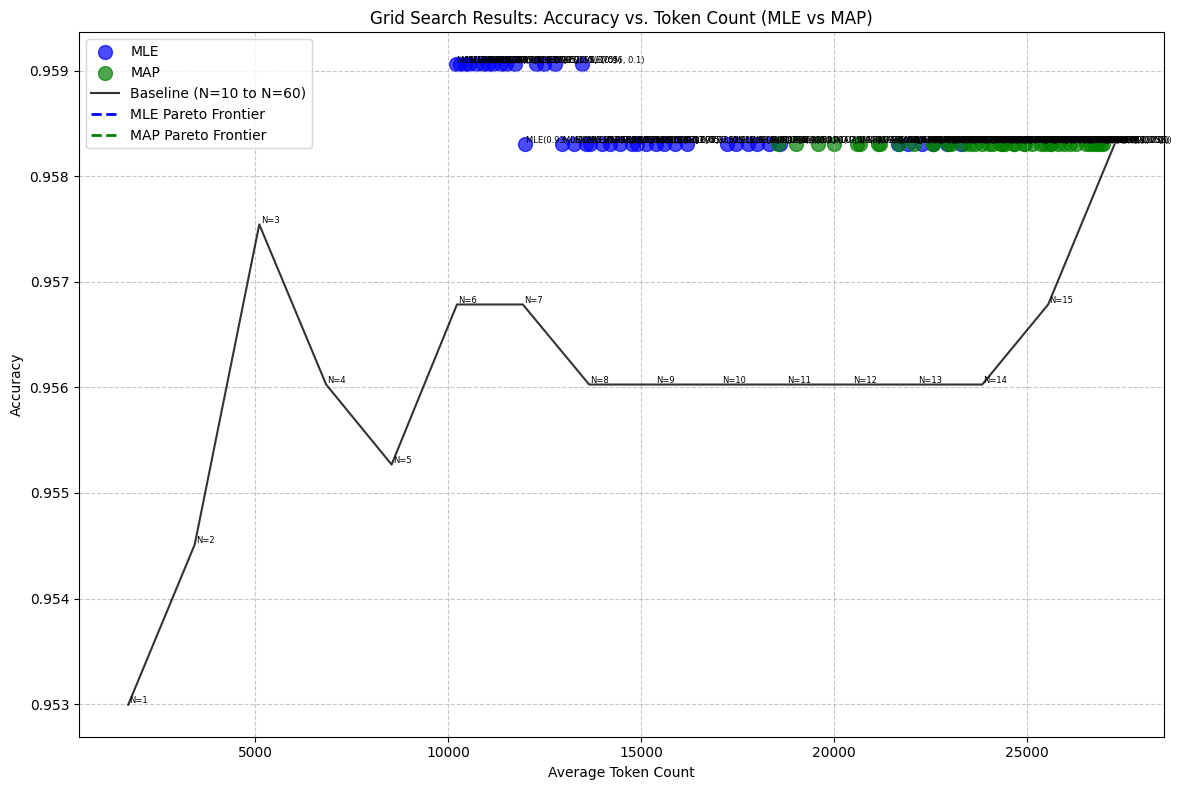


MLE Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9591, Avg Token Count: 10192.19

MAP Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9583, Avg Token Count: 18553.70


In [7]:
max_N_panel = 16
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

In [8]:
peek_number = 10

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.4319      0.0916    0.9847    0.0112    0.7786    0.1686    0.9875    0.0155
1         0.3712      0.0375    0.9828    0.0037    0.7004    0.2336    0.9844    0.0059
2         0.6217      0.1013    0.9391    0.0074    0.9349    0.0052    0.9271    0.0150
3         0.4076      0.0870    0.9830    0.0111    0.9949    0.0289    0.9839    0.0128
4         0.4718      0.1396    0.9736    0.0052    0.7697    0.2302    0.9720    0.0102
5         0.5645      0.0934    0.9669    0.0098    0.9665    0.0098    0.9692    0.0096
6         0.4193      0.0764    0.9925    0.0036    0.8090    0.2050    0.9922    0.0060
7         0.4935      0.1110    0.8443    0.0715    0.7417    0.1243    0.8624    0.0766
8         0.4501      0.1188    0.9833    0.0039    1.0862    0.0741    0.9827    0.0046
9         0.4603      0.1372    0.9940    0.0042    1.0174    0.0204    0.9985    0.0078
10        0.3858      0.0913    0.9849    0.0081    0.9844    0.0080    0.9879    0.0080
11        0.3843     

Target Score Panel: [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 32

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 16, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9568, Average Token Count: 19707.79
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9568, Average Token Count: 19427.10
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9568, Average Token Count: 19218.19
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9568, Average Token Count: 19071.70
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 31, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9568, Average Token Count: 18912.33
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

Target Score (MLE):  14%|█▍        | 1/7 [01:51<11:09, 111.65s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9568, Average Token Count: 18802.67


MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 

MLE - Target Score: 0.93, Percentile: 0.01
MLE - Accuracy: 0.9568, Average Token Count: 21464.68
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 31, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.93, Percentile: 0.02
MLE - Accuracy: 0.9575, Average Token Count: 21106.48
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.93, Percentile: 0.035
MLE - Accuracy: 0.9575, Average Token Count: 20775.83
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.93, Percentile: 0.05
MLE - Accuracy: 0.9575, Average Token Count: 20522.79
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.93, Percentile: 0.075
MLE - Accuracy: 0.9568, Average Token Count: 20200.58
MLE Min N Required [10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

Target Score (MLE):  29%|██▊       | 2/7 [03:45<09:23, 112.77s/it]

MLE - Target Score: 0.93, Percentile: 0.1
MLE - Accuracy: 0.9568, Average Token Count: 19971.82


MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 29, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 13, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 16, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9568, Average Token Count: 23827.53
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 25, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 11, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9568, Average Token Count: 23242.88
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 30, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 21, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9568, Average Token Count: 22751.36
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 19, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9568, Average Token Count: 22404.14
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 18, 17, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9568, Average Token Count: 22015.89
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 15, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

Target Score (MLE):  43%|████▎     | 3/7 [05:41<07:36, 114.23s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9568, Average Token Count: 21742.14


MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 32, 10, 32, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 11, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10, 10, 31, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 26, 32, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9575, Average Token Count: 26014.76
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 24, 32, 10, 32, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 32, 10, 30, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 27, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9568, Average Token Count: 25326.63
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 32, 10, 32, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 26, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 23, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9568, Average Token Count: 24764.04
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 32, 10, 32, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 23, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 10, 10, 21, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9568, Average Token Count: 24340.54
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 10, 20, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 10, 10, 10, 18, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9568, Average Token Count: 23824.42
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 10, 18, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 10, 10, 16, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

Target Score (MLE):  57%|█████▋    | 4/7 [07:40<05:48, 116.19s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9568, Average Token Count: 23441.97


MLE Min N Required [10, 10, 32, 10, 10, 11, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 11, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 32, 19, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 32, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 32, 32, 11, 10, 15, 10, 10, 10, 32, 10, 10, 10, 10, 11, 10, 32, 10, 23, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 32, 10, 10, 22, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 24, 10, 10, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 32, 32, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9575, Average Token Count: 28922.25
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 32, 16, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10, 10, 18, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 13, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 32, 10, 10, 19, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 21, 10, 10, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9575, Average Token Count: 28237.13
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 32, 14, 10, 10, 10, 26, 10, 10, 10, 10, 10, 10, 10, 10, 15, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 11, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 16, 32, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 18, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9575, Average Token Count: 27544.95
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 32, 13, 10, 10, 10, 23, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 15, 30, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 22, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 16, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9568, Average Token Count: 27035.51
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 32, 11, 10, 10, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 12, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 13, 26, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9568, Average Token Count: 26420.19
MLE Min N Required [10, 10, 32, 10, 10, 10, 10, 32, 10, 10, 10, 10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 32, 10, 32, 10, 10, 10, 10, 18, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 11, 23, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

Target Score (MLE):  71%|███████▏  | 5/7 [09:43<03:57, 118.84s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9568, Average Token Count: 25971.01


MLE Min N Required [10, 10, 32, 10, 32, 32, 10, 32, 10, 10, 10, 26, 32, 10, 10, 10, 14, 12, 10, 10, 25, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 32, 32, 12, 32, 32, 10, 11, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 32, 16, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 22, 10, 32, 10, 10, 10, 10, 10, 10, 32, 32, 17, 10, 24, 10, 10, 10, 32, 10, 10, 10, 11, 32, 10, 32, 10, 32, 15, 10, 10, 32, 10, 10, 10, 32, 15, 31, 10, 25, 24, 32, 11, 10, 32, 32, 10, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 11, 10, 10, 32, 32, 32, 10, 10, 15, 10, 10, 32, 10, 10, 10, 11, 10, 32, 10, 10, 32, 32, 32, 26, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 16, 10, 10, 10, 32, 10, 10, 32, 10, 11, 32, 10, 10, 10, 10, 10, 32, 18, 10, 10, 32, 18, 10, 10, 32, 10, 10, 10, 26, 32, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 32, 32, 10, 32, 32, 10, 32, 10, 10, 10, 10, 32, 14, 10, 10, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9575, Average Token Count: 33865.85
MLE Min N Required [10, 10, 32, 10, 32, 32, 10, 32, 10, 10, 10, 22, 32, 10, 10, 10, 12, 10, 10, 10, 21, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 32, 32, 10, 32, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 32, 14, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 19, 10, 32, 10, 10, 10, 10, 10, 10, 32, 32, 15, 10, 21, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 32, 13, 10, 10, 32, 10, 10, 10, 32, 13, 26, 10, 21, 20, 32, 10, 10, 32, 32, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 13, 10, 10, 32, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 22, 10, 10, 10, 10, 10, 10, 10, 10, 16, 10, 10, 14, 10, 10, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 32, 15, 10, 10, 32, 15, 10, 10, 32, 10, 10, 10, 22, 27, 10, 10, 32, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10,

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9575, Average Token Count: 33043.49
MLE Min N Required [10, 10, 32, 10, 32, 32, 10, 32, 10, 10, 10, 19, 32, 10, 10, 10, 11, 10, 10, 10, 18, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 32, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 32, 10, 32, 12, 32, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 16, 10, 30, 10, 10, 10, 10, 10, 10, 32, 32, 13, 10, 18, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 32, 11, 10, 10, 32, 10, 10, 10, 32, 11, 23, 10, 18, 17, 32, 10, 10, 32, 32, 10, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 11, 10, 10, 32, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 19, 10, 10, 10, 10, 10, 10, 10, 10, 14, 10, 10, 12, 10, 10, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 32, 13, 10, 10, 32, 13, 10, 10, 32, 10, 10, 10, 19, 23, 10, 10, 31, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10,

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9575, Average Token Count: 32248.22
MLE Min N Required [10, 10, 32, 10, 30, 32, 10, 32, 10, 10, 10, 17, 32, 10, 10, 10, 10, 10, 10, 10, 16, 32, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 32, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 32, 10, 32, 11, 32, 10, 10, 10, 10, 10, 10, 10, 30, 10, 10, 32, 10, 10, 15, 10, 27, 10, 10, 10, 10, 10, 10, 32, 32, 11, 10, 16, 10, 10, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 32, 10, 10, 10, 32, 10, 20, 10, 16, 16, 32, 10, 10, 32, 32, 10, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 29, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 17, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 11, 10, 10, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 32, 12, 10, 10, 32, 12, 10, 10, 32, 10, 10, 10, 17, 21, 10, 10, 28, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9575, Average Token Count: 31627.69
MLE Min N Required [10, 10, 32, 10, 26, 31, 10, 32, 10, 10, 10, 15, 31, 10, 10, 10, 10, 10, 10, 10, 14, 28, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 32, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 21, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 26, 10, 10, 32, 10, 10, 13, 10, 23, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 14, 10, 10, 10, 32, 10, 10, 10, 10, 30, 10, 32, 10, 30, 10, 10, 10, 32, 10, 10, 10, 32, 10, 18, 10, 14, 14, 32, 10, 10, 32, 32, 10, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 15, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 15, 18, 10, 10, 24, 10, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10,

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9575, Average Token Count: 30872.11
MLE Min N Required [10, 10, 32, 10, 23, 28, 10, 32, 10, 10, 10, 13, 27, 10, 10, 10, 10, 10, 10, 10, 13, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 10, 32, 32, 10, 10, 10, 32, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 10, 10, 32, 10, 32, 10, 32, 10, 10, 10, 10, 10, 10, 10, 23, 10, 10, 32, 10, 10, 11, 10, 21, 10, 10, 10, 10, 10, 10, 32, 32, 10, 10, 12, 10, 10, 10, 32, 10, 10, 10, 10, 27, 10, 32, 10, 27, 10, 10, 10, 28, 10, 10, 10, 32, 10, 16, 10, 13, 12, 32, 10, 10, 32, 32, 10, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 32, 10, 10, 10, 10, 10, 32, 32, 32, 10, 10, 10, 10, 10, 32, 10, 10, 10, 10, 10, 32, 10, 10, 29, 32, 32, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 10, 10, 32, 10, 10, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 32, 10, 10, 10, 13, 16, 10, 10, 22, 10, 10, 10, 10, 10, 10, 29, 10, 10, 10, 10

Target Score (MLE):  86%|████████▌ | 6/7 [11:55<02:03, 123.34s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9575, Average Token Count: 30212.22


MLE Min N Required [17, 32, 32, 21, 32, 32, 10, 32, 32, 10, 19, 32, 32, 10, 10, 11, 32, 32, 10, 21, 32, 32, 10, 10, 10, 10, 32, 10, 16, 10, 32, 32, 10, 10, 10, 27, 10, 32, 32, 32, 32, 32, 10, 32, 29, 32, 10, 10, 10, 10, 10, 13, 10, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 29, 27, 32, 31, 10, 10, 32, 10, 21, 32, 28, 32, 32, 13, 32, 10, 32, 32, 32, 12, 11, 32, 32, 32, 10, 32, 10, 10, 10, 32, 28, 10, 10, 32, 32, 32, 32, 10, 32, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 12, 32, 32, 32, 32, 10, 32, 32, 10, 32, 10, 10, 10, 10, 10, 30, 32, 10, 10, 13, 10, 10, 30, 10, 32, 32, 32, 10, 10, 24, 32, 16, 32, 32, 32, 10, 10, 32, 14, 10, 32, 17, 32, 32, 21, 32, 32, 10, 13, 32, 32, 32, 32, 10, 10, 10, 10, 10, 25, 32, 32, 32, 10, 17, 32, 27, 10, 10, 32, 25, 32, 32, 10, 32, 32, 10, 19, 10, 10, 32, 32, 32, 10, 18, 32, 32, 10, 10, 32, 10, 18, 10, 32, 32, 32, 10, 32, 11, 10, 10, 10, 32, 10, 32, 10, 12, 23, 10, 10, 10, 10, 32, 32, 32, 19, 10, 15, 32, 32, 10, 32, 32, 18, 32, 14, 14, 10, 10, 32, 32, 16, 10, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9575, Average Token Count: 42379.19
MLE Min N Required [15, 32, 32, 18, 32, 32, 10, 32, 32, 10, 16, 32, 32, 10, 10, 10, 32, 28, 10, 18, 32, 32, 10, 10, 10, 10, 32, 10, 14, 10, 32, 32, 10, 10, 10, 23, 10, 32, 32, 32, 32, 32, 10, 32, 25, 32, 10, 10, 10, 10, 10, 11, 10, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 24, 23, 32, 27, 10, 10, 32, 10, 18, 32, 24, 32, 32, 11, 32, 10, 32, 32, 30, 11, 10, 32, 32, 29, 10, 32, 10, 10, 10, 32, 24, 10, 10, 32, 32, 32, 32, 10, 32, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 32, 32, 32, 32, 10, 32, 32, 10, 32, 10, 10, 10, 10, 10, 26, 32, 10, 10, 11, 10, 10, 25, 10, 29, 32, 32, 10, 10, 21, 32, 14, 32, 32, 32, 10, 10, 32, 12, 10, 32, 14, 31, 32, 18, 32, 32, 10, 11, 32, 32, 32, 32, 10, 10, 10, 10, 10, 22, 32, 28, 32, 10, 15, 28, 23, 10, 10, 32, 22, 32, 32, 10, 32, 32, 10, 16, 10, 10, 32, 32, 32, 10, 15, 32, 32, 10, 10, 32, 10, 15, 10, 32, 32, 32, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 11, 20, 10,

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9575, Average Token Count: 41432.14
MLE Min N Required [13, 32, 32, 15, 32, 32, 10, 32, 32, 10, 14, 32, 32, 10, 10, 10, 32, 24, 10, 16, 32, 32, 10, 10, 10, 10, 32, 10, 12, 10, 32, 32, 10, 10, 10, 20, 10, 32, 32, 32, 32, 32, 10, 32, 21, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 21, 20, 32, 23, 10, 10, 32, 10, 15, 32, 21, 32, 32, 10, 32, 10, 32, 32, 26, 10, 10, 32, 32, 25, 10, 32, 10, 10, 10, 32, 20, 10, 10, 32, 32, 32, 32, 10, 32, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 32, 32, 32, 29, 10, 32, 32, 10, 32, 10, 10, 10, 10, 10, 22, 32, 10, 10, 10, 10, 10, 22, 10, 25, 32, 32, 10, 10, 18, 32, 12, 32, 32, 32, 10, 10, 32, 11, 10, 32, 12, 27, 32, 15, 32, 32, 10, 10, 32, 32, 32, 32, 10, 10, 10, 10, 10, 19, 30, 24, 32, 10, 13, 24, 20, 10, 10, 32, 19, 32, 32, 10, 32, 32, 10, 14, 10, 10, 32, 32, 32, 10, 13, 32, 32, 10, 10, 32, 10, 13, 10, 32, 32, 32, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 17, 10,

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9575, Average Token Count: 40535.21
MLE Min N Required [11, 32, 32, 14, 32, 32, 10, 32, 32, 10, 12, 32, 32, 10, 10, 10, 32, 22, 10, 14, 32, 32, 10, 10, 10, 10, 32, 10, 11, 10, 32, 32, 10, 10, 10, 18, 10, 32, 32, 32, 32, 32, 10, 32, 19, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 19, 18, 32, 21, 10, 10, 32, 10, 14, 32, 19, 32, 32, 10, 32, 10, 32, 32, 23, 10, 10, 32, 32, 23, 10, 32, 10, 10, 10, 32, 18, 10, 10, 32, 32, 32, 32, 10, 32, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 32, 32, 32, 26, 10, 32, 32, 10, 32, 10, 10, 10, 10, 10, 20, 32, 10, 10, 10, 10, 10, 20, 10, 22, 32, 32, 10, 10, 16, 32, 11, 32, 32, 32, 10, 10, 32, 10, 10, 32, 11, 24, 32, 14, 32, 32, 10, 10, 32, 32, 32, 32, 10, 10, 10, 10, 10, 17, 27, 21, 32, 10, 12, 22, 18, 10, 10, 32, 17, 32, 32, 10, 32, 32, 10, 13, 10, 10, 32, 32, 32, 10, 12, 32, 32, 10, 10, 32, 10, 12, 10, 32, 32, 32, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 16, 10

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9575, Average Token Count: 39890.80
MLE Min N Required [10, 32, 32, 12, 32, 32, 10, 32, 32, 10, 11, 32, 32, 10, 10, 10, 31, 19, 10, 12, 32, 32, 10, 10, 10, 10, 32, 10, 10, 10, 32, 32, 10, 10, 10, 16, 10, 32, 32, 32, 32, 32, 10, 32, 17, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 16, 16, 32, 18, 10, 10, 32, 10, 12, 32, 16, 32, 32, 10, 32, 10, 32, 32, 20, 10, 10, 32, 32, 20, 10, 29, 10, 10, 10, 32, 16, 10, 10, 32, 32, 32, 32, 10, 32, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 32, 32, 32, 22, 10, 32, 32, 10, 32, 10, 10, 10, 10, 10, 17, 32, 10, 10, 10, 10, 10, 17, 10, 20, 32, 32, 10, 10, 14, 32, 10, 32, 32, 32, 10, 10, 32, 10, 10, 32, 10, 21, 32, 12, 32, 32, 10, 10, 32, 32, 32, 32, 10, 10, 10, 10, 10, 15, 23, 19, 32, 10, 10, 19, 16, 10, 10, 32, 15, 32, 32, 10, 32, 32, 10, 11, 10, 10, 32, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 32, 32, 31, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 14, 10,

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9575, Average Token Count: 39093.14
MLE Min N Required [10, 32, 32, 11, 32, 32, 10, 32, 32, 10, 10, 32, 32, 10, 10, 10, 27, 17, 10, 11, 32, 32, 10, 10, 10, 10, 32, 10, 10, 10, 32, 32, 10, 10, 10, 14, 10, 32, 32, 32, 32, 32, 10, 32, 15, 32, 10, 10, 10, 10, 10, 10, 10, 10, 32, 10, 10, 32, 32, 32, 32, 32, 32, 32, 15, 14, 32, 17, 10, 10, 32, 10, 11, 32, 14, 30, 32, 10, 32, 10, 30, 32, 18, 10, 10, 32, 32, 17, 10, 26, 10, 10, 10, 32, 14, 10, 10, 32, 32, 32, 32, 10, 32, 32, 10, 10, 32, 10, 10, 10, 32, 32, 32, 10, 32, 32, 32, 20, 10, 32, 32, 10, 32, 10, 10, 10, 10, 10, 15, 32, 10, 10, 10, 10, 10, 15, 10, 17, 32, 32, 10, 10, 12, 32, 10, 32, 32, 32, 10, 10, 32, 10, 10, 32, 10, 19, 32, 11, 32, 32, 10, 10, 32, 32, 32, 32, 10, 10, 10, 10, 10, 13, 21, 17, 32, 10, 10, 17, 14, 10, 10, 32, 13, 32, 32, 10, 32, 32, 10, 10, 10, 10, 32, 32, 32, 10, 10, 32, 32, 10, 10, 32, 10, 10, 10, 32, 32, 27, 10, 32, 10, 10, 10, 10, 32, 10, 32, 10, 10, 12, 10

Target Score (MLE): 100%|██████████| 7/7 [14:27<00:00, 123.91s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9575, Average Token Count: 38431.93

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [28, 32, 10, 10, 29, 10, 23, 32, 10, 10, 10, 10, 32, 10, 10, 17, 28, 10, 10, 31, 10, 32, 13, 10, 10, 10, 10, 19, 32, 10, 32, 10, 20, 10, 10, 10, 10, 32, 13, 10, 27, 10, 11, 32, 32, 32, 10, 10, 21, 29, 23, 10, 10, 32, 19, 10, 10, 27, 32, 32, 10, 10, 32, 32, 20, 10, 32, 10, 32, 11, 32, 32, 31, 31, 22, 32, 29, 23, 22, 32, 29, 10, 10, 24, 12, 27, 14, 32, 10, 12, 11, 32, 32, 32, 14, 32, 10, 10, 22, 10, 32, 26, 10, 10, 32, 10, 32, 10, 32, 24, 28, 10, 13, 10, 10, 10, 10, 32, 17, 32, 18, 10, 32, 30, 26, 10, 10, 10, 10, 32, 28, 10, 26, 27, 10, 24, 15, 30, 32, 20, 15, 10, 10, 28, 32, 32, 15, 32, 10, 10, 26, 32, 32, 10, 25, 32, 32, 30, 17, 32, 23, 30, 10, 11, 32, 10, 11, 10, 25, 10, 10, 10, 10, 28, 17, 10, 29, 10, 10, 32, 32, 10, 13, 13, 32, 19, 10, 26, 10, 32, 32, 32, 10, 10, 29, 32, 10, 10, 30, 10, 12, 10, 10, 24, 10, 24, 10, 10, 10, 10, 26, 30, 32, 10, 25, 25, 14, 10, 32, 10, 32, 10, 30, 10, 10, 12, 10, 10, 10, 32, 10, 10, 10, 10, 31, 10, 32, 21, 32, 27, 32, 26, 10, 10, 21, 

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9575, Average Token Count: 34858.47
MAP Min N Required [24, 32, 10, 10, 24, 10, 20, 32, 10, 10, 10, 10, 32, 10, 10, 15, 24, 10, 10, 27, 10, 32, 11, 10, 10, 10, 10, 16, 30, 10, 30, 10, 17, 10, 10, 10, 10, 30, 11, 10, 23, 10, 10, 32, 30, 32, 10, 10, 18, 25, 20, 10, 10, 32, 16, 10, 10, 23, 28, 32, 10, 10, 32, 32, 17, 10, 28, 10, 32, 10, 27, 29, 27, 27, 19, 31, 25, 19, 19, 32, 25, 10, 10, 21, 10, 23, 12, 30, 10, 10, 10, 32, 30, 32, 12, 32, 10, 10, 19, 10, 32, 23, 10, 10, 28, 10, 31, 10, 32, 20, 24, 10, 11, 10, 10, 10, 10, 29, 15, 32, 15, 10, 32, 26, 23, 10, 10, 10, 10, 32, 24, 10, 23, 23, 10, 20, 13, 26, 32, 17, 13, 10, 10, 24, 32, 32, 13, 30, 10, 10, 22, 30, 32, 10, 21, 32, 30, 25, 14, 32, 20, 26, 10, 10, 32, 10, 10, 10, 22, 10, 10, 10, 10, 24, 14, 10, 25, 10, 10, 30, 32, 10, 11, 11, 32, 16, 10, 22, 10, 32, 32, 29, 10, 10, 25, 28, 10, 10, 26, 10, 10, 10, 10, 20, 10, 20, 10, 10, 10, 10, 22, 26, 28, 10, 21, 22, 12, 10, 32, 10, 30, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 32520.38
MAP Min N Required [20, 30, 10, 10, 21, 10, 17, 32, 10, 10, 10, 10, 32, 10, 10, 13, 21, 10, 10, 23, 10, 30, 10, 10, 10, 10, 10, 14, 25, 10, 26, 10, 15, 10, 10, 10, 10, 26, 10, 10, 19, 10, 10, 32, 26, 30, 10, 10, 15, 21, 17, 10, 10, 29, 14, 10, 10, 20, 24, 32, 10, 10, 32, 32, 15, 10, 24, 10, 30, 10, 24, 25, 23, 23, 16, 27, 21, 17, 16, 30, 21, 10, 10, 18, 10, 20, 10, 26, 10, 10, 10, 32, 25, 32, 10, 27, 10, 10, 16, 10, 32, 19, 10, 10, 24, 10, 26, 10, 31, 17, 21, 10, 10, 10, 10, 10, 10, 25, 13, 32, 13, 10, 32, 22, 19, 10, 10, 10, 10, 30, 21, 10, 19, 20, 10, 17, 11, 22, 28, 15, 11, 10, 10, 20, 28, 32, 11, 26, 10, 10, 19, 26, 29, 10, 18, 32, 26, 22, 12, 32, 17, 22, 10, 10, 31, 10, 10, 10, 19, 10, 10, 10, 10, 21, 12, 10, 22, 10, 10, 26, 32, 10, 10, 10, 30, 14, 10, 19, 10, 32, 32, 25, 10, 10, 21, 24, 10, 10, 22, 10, 10, 10, 10, 17, 10, 17, 10, 10, 10, 10, 19, 22, 24, 10, 18, 19, 10, 10, 29, 10, 26, 

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 30057.04
MAP Min N Required [18, 27, 10, 10, 19, 10, 15, 32, 10, 10, 10, 10, 31, 10, 10, 11, 19, 10, 10, 21, 10, 27, 10, 10, 10, 10, 10, 12, 23, 10, 23, 10, 13, 10, 10, 10, 10, 23, 10, 10, 17, 10, 10, 32, 23, 27, 10, 10, 14, 19, 15, 10, 10, 26, 13, 10, 10, 18, 21, 30, 10, 10, 32, 31, 13, 10, 21, 10, 27, 10, 21, 22, 20, 21, 14, 24, 19, 15, 15, 27, 19, 10, 10, 16, 10, 18, 10, 23, 10, 10, 10, 31, 23, 32, 10, 24, 10, 10, 15, 10, 32, 17, 10, 10, 22, 10, 23, 10, 28, 16, 19, 10, 10, 10, 10, 10, 10, 22, 11, 32, 12, 10, 32, 20, 17, 10, 10, 10, 10, 27, 18, 10, 17, 18, 10, 16, 10, 20, 25, 13, 10, 10, 10, 18, 25, 32, 10, 23, 10, 10, 17, 23, 26, 10, 16, 31, 23, 20, 11, 32, 15, 20, 10, 10, 28, 10, 10, 10, 17, 10, 10, 10, 10, 18, 11, 10, 19, 10, 10, 23, 32, 10, 10, 10, 27, 13, 10, 17, 10, 29, 29, 22, 10, 10, 19, 22, 10, 10, 20, 10, 10, 10, 10, 16, 10, 16, 10, 10, 10, 10, 17, 20, 22, 10, 17, 17, 10, 10, 26, 10, 23,

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9568, Average Token Count: 28274.66
MAP Min N Required [16, 23, 10, 10, 16, 10, 13, 30, 10, 10, 10, 10, 27, 10, 10, 10, 16, 10, 10, 18, 10, 24, 10, 10, 10, 10, 10, 11, 20, 10, 20, 10, 11, 10, 10, 10, 10, 20, 10, 10, 15, 10, 10, 28, 20, 23, 10, 10, 12, 17, 13, 10, 10, 23, 11, 10, 10, 15, 19, 26, 10, 10, 32, 27, 12, 10, 19, 10, 23, 10, 18, 19, 18, 18, 13, 21, 17, 13, 13, 24, 17, 10, 10, 14, 10, 16, 10, 20, 10, 10, 10, 27, 20, 32, 10, 21, 10, 10, 13, 10, 32, 15, 10, 10, 19, 10, 20, 10, 24, 14, 16, 10, 10, 10, 10, 10, 10, 19, 10, 32, 10, 10, 29, 17, 15, 10, 10, 10, 10, 23, 16, 10, 15, 16, 10, 14, 10, 17, 22, 12, 10, 10, 10, 16, 22, 28, 10, 20, 10, 10, 15, 20, 23, 10, 14, 27, 20, 17, 10, 32, 13, 17, 10, 10, 24, 10, 10, 10, 14, 10, 10, 10, 10, 16, 10, 10, 17, 10, 10, 20, 29, 10, 10, 10, 23, 11, 10, 15, 10, 26, 25, 19, 10, 10, 16, 19, 10, 10, 17, 10, 10, 10, 10, 14, 10, 14, 10, 10, 10, 10, 15, 17, 19, 10, 14, 14, 10, 10, 22, 10, 20, 

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9568, Average Token Count: 26081.40
MAP Min N Required [14, 21, 10, 10, 15, 10, 12, 27, 10, 10, 10, 10, 24, 10, 10, 10, 14, 10, 10, 16, 10, 21, 10, 10, 10, 10, 10, 10, 18, 10, 18, 10, 10, 10, 10, 10, 10, 18, 10, 10, 14, 10, 10, 25, 18, 21, 10, 10, 11, 15, 12, 10, 10, 20, 10, 10, 10, 14, 17, 23, 10, 10, 32, 24, 10, 10, 17, 10, 21, 10, 16, 17, 16, 16, 11, 18, 15, 12, 11, 21, 15, 10, 10, 12, 10, 14, 10, 18, 10, 10, 10, 24, 18, 32, 10, 19, 10, 10, 11, 10, 32, 13, 10, 10, 17, 10, 18, 10, 22, 12, 14, 10, 10, 10, 10, 10, 10, 17, 10, 32, 10, 10, 26, 15, 13, 10, 10, 10, 10, 21, 14, 10, 13, 14, 10, 12, 10, 15, 20, 10, 10, 10, 10, 14, 20, 25, 10, 18, 10, 10, 13, 18, 20, 10, 13, 24, 18, 15, 10, 32, 12, 15, 10, 10, 22, 10, 10, 10, 13, 10, 10, 10, 10, 14, 10, 10, 15, 10, 10, 18, 25, 10, 10, 10, 21, 10, 10, 13, 10, 23, 23, 17, 10, 10, 15, 17, 10, 10, 15, 10, 10, 10, 10, 12, 10, 12, 10, 10, 10, 10, 13, 15, 17, 10, 13, 13, 10, 10, 20, 10, 18,

Target Score (MAP):  14%|█▍        | 1/7 [02:21<14:08, 141.46s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9568, Average Token Count: 24500.57


MAP Min N Required [32, 32, 10, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 10, 10, 27, 32, 10, 10, 32, 10, 32, 21, 10, 10, 10, 10, 31, 32, 10, 32, 10, 32, 10, 16, 10, 10, 32, 32, 10, 32, 10, 19, 32, 32, 32, 10, 10, 32, 32, 32, 13, 10, 32, 32, 10, 10, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 10, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 12, 32, 18, 32, 32, 32, 10, 20, 19, 32, 32, 32, 24, 32, 10, 10, 32, 10, 32, 32, 16, 14, 32, 10, 32, 12, 32, 32, 32, 10, 24, 10, 10, 10, 32, 32, 27, 32, 30, 10, 32, 32, 32, 17, 10, 10, 10, 32, 32, 10, 32, 32, 10, 32, 25, 32, 32, 32, 24, 10, 10, 32, 32, 32, 32, 32, 10, 17, 32, 32, 32, 10, 32, 32, 32, 32, 26, 32, 32, 32, 12, 23, 32, 13, 19, 10, 32, 11, 10, 10, 10, 32, 28, 10, 32, 15, 10, 32, 32, 10, 20, 20, 32, 29, 20, 32, 10, 32, 32, 32, 10, 10, 32, 32, 11, 10, 32, 15, 19, 10, 16, 32, 11, 32, 10, 14, 10, 10, 32, 32, 32, 10, 32, 32, 27, 10, 32, 10, 32, 10, 32, 10, 10, 20, 10, 10, 15, 32, 10, 10, 10, 11, 32, 10, 32, 32, 32, 32, 32, 32, 10, 10, 32, 

MAP - Target Score: 0.93, Percentile: 0.01
MAP - Accuracy: 0.9575, Average Token Count: 39804.77
MAP Min N Required [32, 32, 10, 10, 32, 10, 30, 32, 10, 10, 10, 10, 32, 10, 10, 23, 32, 10, 10, 32, 10, 32, 18, 10, 10, 10, 10, 26, 32, 10, 32, 10, 28, 10, 14, 10, 10, 32, 32, 10, 32, 10, 16, 32, 32, 32, 10, 10, 29, 32, 30, 11, 10, 32, 28, 10, 10, 32, 32, 32, 10, 10, 32, 32, 28, 10, 32, 10, 32, 16, 32, 32, 32, 32, 29, 32, 32, 30, 32, 32, 32, 10, 10, 32, 15, 32, 32, 32, 10, 17, 16, 32, 32, 32, 21, 32, 10, 10, 30, 10, 32, 32, 14, 12, 32, 10, 32, 10, 32, 31, 32, 10, 20, 10, 10, 10, 32, 32, 23, 32, 25, 10, 32, 32, 32, 14, 10, 10, 10, 32, 32, 10, 32, 32, 10, 32, 22, 32, 32, 28, 20, 10, 10, 32, 32, 32, 32, 32, 10, 15, 32, 32, 32, 10, 32, 32, 32, 32, 22, 32, 32, 32, 11, 20, 32, 11, 16, 10, 32, 10, 10, 10, 10, 32, 24, 10, 32, 13, 10, 32, 32, 10, 17, 17, 32, 25, 17, 32, 10, 32, 32, 32, 10, 10, 32, 32, 10, 10, 32, 13, 16, 10, 13, 31, 10, 32, 10, 12, 10, 10, 32, 32, 32, 10, 32, 32, 23, 10, 32, 10, 32,

MAP - Target Score: 0.93, Percentile: 0.02
MAP - Accuracy: 0.9575, Average Token Count: 38707.41
MAP Min N Required [32, 32, 10, 10, 32, 10, 26, 32, 10, 10, 10, 10, 32, 10, 10, 20, 32, 10, 10, 32, 10, 32, 16, 10, 10, 10, 10, 22, 32, 10, 32, 10, 24, 10, 12, 10, 10, 32, 31, 10, 31, 10, 14, 32, 32, 32, 10, 10, 25, 32, 26, 10, 10, 32, 24, 10, 10, 31, 32, 32, 10, 10, 32, 32, 24, 10, 32, 10, 32, 14, 32, 32, 32, 32, 25, 32, 32, 26, 27, 32, 32, 10, 10, 28, 13, 32, 29, 32, 10, 15, 14, 32, 32, 32, 18, 32, 10, 10, 25, 10, 32, 30, 12, 10, 32, 10, 32, 10, 32, 26, 31, 10, 18, 10, 10, 10, 32, 32, 20, 32, 22, 10, 32, 32, 29, 12, 10, 10, 10, 32, 31, 10, 31, 32, 10, 28, 19, 32, 32, 24, 18, 10, 10, 31, 32, 32, 32, 32, 10, 13, 29, 32, 32, 10, 28, 32, 32, 32, 19, 32, 27, 32, 10, 17, 32, 10, 14, 10, 28, 10, 10, 10, 10, 31, 21, 10, 32, 11, 10, 32, 32, 10, 15, 15, 32, 21, 15, 30, 10, 32, 32, 32, 10, 10, 32, 32, 10, 10, 32, 11, 14, 10, 12, 26, 10, 27, 10, 10, 10, 10, 30, 32, 32, 10, 29, 29, 19, 10, 32, 10, 32,

MAP - Target Score: 0.93, Percentile: 0.035
MAP - Accuracy: 0.9575, Average Token Count: 37316.52
MAP Min N Required [29, 32, 10, 10, 29, 10, 23, 32, 10, 10, 10, 10, 32, 10, 10, 17, 29, 10, 10, 31, 10, 32, 14, 10, 10, 10, 10, 20, 32, 10, 32, 10, 22, 10, 11, 10, 10, 32, 28, 10, 28, 10, 12, 32, 32, 32, 10, 10, 22, 29, 23, 10, 10, 32, 22, 10, 10, 28, 32, 32, 10, 10, 32, 32, 22, 10, 32, 10, 32, 13, 32, 32, 32, 32, 22, 32, 30, 23, 24, 32, 29, 10, 10, 26, 12, 32, 26, 32, 10, 13, 13, 32, 32, 32, 16, 32, 10, 10, 23, 10, 32, 27, 11, 10, 32, 10, 32, 10, 32, 24, 28, 10, 16, 10, 10, 10, 32, 32, 18, 32, 19, 10, 32, 31, 26, 11, 10, 10, 10, 32, 27, 10, 28, 29, 10, 25, 17, 31, 32, 22, 16, 10, 10, 28, 32, 32, 32, 32, 10, 12, 26, 32, 32, 10, 25, 32, 32, 30, 17, 32, 24, 30, 10, 15, 32, 10, 13, 10, 25, 10, 10, 10, 10, 28, 19, 10, 29, 10, 10, 32, 32, 10, 13, 13, 32, 19, 13, 27, 10, 32, 32, 32, 10, 10, 30, 32, 10, 10, 31, 10, 12, 10, 10, 24, 10, 24, 10, 10, 10, 10, 27, 31, 32, 10, 26, 26, 17, 10, 32, 10, 32

MAP - Target Score: 0.93, Percentile: 0.05
MAP - Accuracy: 0.9575, Average Token Count: 36066.17
MAP Min N Required [25, 32, 10, 10, 25, 10, 20, 32, 10, 10, 10, 10, 32, 10, 10, 15, 25, 10, 10, 27, 10, 32, 12, 10, 10, 10, 10, 17, 31, 10, 31, 10, 19, 10, 10, 10, 10, 32, 24, 10, 24, 10, 11, 32, 31, 32, 10, 10, 19, 25, 20, 10, 10, 32, 19, 10, 10, 24, 31, 32, 10, 10, 32, 32, 19, 10, 28, 10, 32, 11, 29, 29, 28, 28, 19, 31, 26, 20, 21, 32, 25, 10, 10, 22, 10, 32, 23, 32, 10, 12, 11, 32, 30, 32, 14, 32, 10, 10, 20, 10, 32, 23, 10, 10, 28, 10, 31, 10, 32, 20, 24, 10, 14, 10, 10, 10, 32, 29, 15, 32, 17, 10, 32, 27, 22, 10, 10, 10, 10, 32, 24, 10, 24, 25, 10, 22, 15, 27, 32, 19, 14, 10, 10, 24, 32, 32, 28, 32, 10, 10, 23, 30, 32, 10, 22, 32, 30, 26, 15, 32, 21, 26, 10, 13, 32, 10, 11, 10, 22, 10, 10, 10, 10, 24, 16, 10, 25, 10, 10, 31, 32, 10, 12, 12, 32, 17, 11, 23, 10, 32, 32, 29, 10, 10, 26, 30, 10, 10, 27, 10, 11, 10, 10, 20, 10, 21, 10, 10, 10, 10, 23, 27, 29, 10, 22, 22, 15, 10, 32, 10, 31,

MAP - Target Score: 0.93, Percentile: 0.075
MAP - Accuracy: 0.9575, Average Token Count: 33989.53
MAP Min N Required [23, 32, 10, 10, 22, 10, 18, 32, 10, 10, 10, 10, 32, 10, 10, 14, 22, 10, 10, 24, 10, 32, 11, 10, 10, 10, 10, 16, 28, 10, 27, 10, 17, 10, 10, 10, 10, 28, 21, 10, 21, 10, 10, 32, 27, 32, 10, 10, 17, 22, 18, 10, 10, 30, 17, 10, 10, 22, 27, 32, 10, 10, 32, 32, 17, 10, 25, 10, 32, 10, 26, 26, 25, 25, 17, 28, 23, 18, 19, 32, 22, 10, 10, 20, 10, 32, 20, 29, 10, 10, 10, 32, 27, 32, 12, 28, 10, 10, 18, 10, 32, 21, 10, 10, 25, 10, 27, 10, 32, 18, 21, 10, 12, 10, 10, 10, 32, 26, 14, 32, 15, 10, 32, 24, 20, 10, 10, 10, 10, 32, 21, 10, 22, 22, 10, 19, 13, 24, 31, 17, 12, 10, 10, 22, 30, 32, 25, 32, 10, 10, 20, 27, 31, 10, 19, 32, 27, 23, 13, 32, 19, 23, 10, 12, 32, 10, 10, 10, 19, 10, 10, 10, 10, 22, 14, 10, 23, 10, 10, 27, 32, 10, 10, 10, 31, 15, 10, 21, 10, 32, 32, 26, 10, 10, 23, 26, 10, 10, 24, 10, 10, 10, 10, 18, 10, 19, 10, 10, 10, 10, 21, 24, 26, 10, 20, 20, 14, 10, 31, 10, 28

Target Score (MAP):  29%|██▊       | 2/7 [04:55<12:24, 148.85s/it]

MAP - Target Score: 0.93, Percentile: 0.1
MAP - Accuracy: 0.9575, Average Token Count: 32191.83


MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 16, 10, 32, 32, 12, 11, 32, 10, 32, 32, 10, 10, 10, 15, 32, 32, 10, 32, 10, 32, 10, 26, 14, 10, 32, 32, 10, 32, 10, 30, 32, 32, 32, 10, 10, 32, 32, 32, 19, 10, 32, 32, 10, 10, 32, 32, 32, 19, 10, 32, 32, 32, 10, 32, 10, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 18, 32, 26, 32, 32, 32, 10, 32, 31, 32, 32, 32, 32, 32, 10, 11, 32, 10, 32, 32, 32, 27, 32, 10, 32, 21, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 13, 32, 32, 32, 28, 17, 15, 11, 32, 32, 15, 32, 32, 10, 32, 32, 32, 32, 32, 32, 13, 14, 32, 32, 32, 32, 32, 13, 29, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 22, 31, 11, 32, 17, 10, 10, 10, 32, 32, 15, 32, 26, 10, 32, 32, 10, 31, 30, 32, 32, 32, 32, 10, 32, 32, 32, 19, 18, 32, 32, 17, 10, 32, 23, 28, 10, 23, 32, 16, 32, 10, 26, 10, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32, 10, 32, 10, 21, 30, 10, 10, 22, 32, 10, 13, 10, 29, 32, 10, 32, 32, 32, 32, 32, 32, 19, 10, 32, 

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9575, Average Token Count: 43165.43
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 13, 10, 32, 32, 10, 10, 32, 10, 32, 27, 10, 10, 10, 13, 32, 32, 10, 32, 10, 32, 10, 23, 12, 10, 32, 32, 10, 32, 10, 26, 32, 32, 32, 10, 10, 32, 32, 32, 16, 10, 32, 32, 10, 10, 32, 32, 32, 16, 10, 32, 32, 32, 10, 32, 10, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 15, 32, 22, 32, 32, 32, 10, 27, 27, 32, 32, 32, 32, 32, 10, 10, 32, 10, 32, 32, 32, 23, 32, 10, 32, 18, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 11, 32, 32, 32, 23, 14, 13, 10, 32, 32, 13, 32, 32, 10, 32, 32, 32, 32, 32, 30, 11, 12, 32, 32, 32, 32, 32, 11, 24, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 19, 27, 10, 32, 14, 10, 10, 10, 32, 32, 13, 32, 22, 10, 32, 32, 10, 26, 26, 32, 32, 29, 32, 10, 32, 32, 32, 16, 15, 32, 32, 14, 10, 32, 19, 24, 10, 20, 32, 14, 32, 10, 22, 10, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32,

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9575, Average Token Count: 42179.29
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 11, 10, 29, 32, 10, 10, 32, 10, 32, 24, 10, 10, 10, 11, 32, 32, 10, 32, 10, 32, 10, 19, 11, 10, 32, 32, 10, 32, 10, 22, 32, 32, 32, 10, 10, 32, 32, 32, 14, 10, 32, 32, 10, 10, 32, 32, 32, 14, 10, 32, 32, 32, 10, 32, 10, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 13, 32, 19, 32, 32, 32, 10, 23, 23, 32, 32, 32, 28, 32, 10, 10, 32, 10, 32, 32, 32, 20, 32, 10, 32, 15, 32, 32, 32, 10, 31, 10, 10, 10, 32, 32, 29, 32, 32, 10, 32, 32, 32, 20, 12, 11, 10, 32, 32, 11, 32, 32, 10, 32, 29, 32, 32, 32, 26, 10, 11, 32, 32, 32, 32, 32, 10, 21, 32, 32, 32, 10, 32, 32, 32, 32, 29, 32, 32, 32, 13, 32, 32, 16, 23, 10, 32, 12, 10, 10, 10, 32, 32, 11, 32, 19, 10, 32, 32, 10, 22, 22, 32, 31, 25, 32, 10, 32, 32, 32, 14, 13, 32, 32, 12, 10, 32, 17, 21, 10, 17, 32, 12, 32, 10, 19, 10, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32,

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9575, Average Token Count: 41243.85
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 10, 10, 26, 32, 10, 10, 32, 10, 32, 21, 10, 10, 10, 10, 31, 32, 10, 32, 10, 32, 10, 17, 10, 10, 32, 32, 10, 32, 10, 20, 32, 32, 32, 10, 10, 32, 32, 32, 13, 10, 32, 32, 10, 10, 32, 32, 32, 12, 10, 32, 32, 32, 10, 32, 10, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 12, 32, 17, 32, 32, 32, 10, 21, 21, 32, 32, 32, 25, 32, 10, 10, 32, 10, 32, 32, 32, 18, 32, 10, 32, 14, 32, 32, 32, 10, 27, 10, 10, 10, 32, 32, 26, 32, 30, 10, 32, 32, 32, 18, 11, 10, 10, 32, 32, 10, 32, 32, 10, 32, 26, 32, 32, 32, 23, 10, 10, 32, 32, 32, 32, 32, 10, 19, 32, 32, 32, 10, 32, 32, 32, 32, 26, 32, 32, 32, 12, 28, 32, 15, 20, 10, 32, 11, 10, 10, 10, 32, 30, 10, 32, 17, 10, 32, 32, 10, 20, 20, 32, 28, 23, 32, 10, 32, 32, 32, 12, 12, 32, 32, 11, 10, 32, 15, 19, 10, 15, 32, 11, 32, 10, 17, 10, 10, 32, 32, 32, 10, 32, 32, 30, 10, 32, 10, 32

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9575, Average Token Count: 40534.66
MAP Min N Required [32, 32, 32, 10, 32, 10, 30, 32, 10, 10, 10, 10, 32, 10, 10, 23, 32, 10, 10, 32, 10, 32, 18, 10, 10, 10, 10, 27, 32, 10, 32, 10, 29, 10, 15, 10, 10, 32, 32, 10, 32, 10, 17, 32, 32, 32, 10, 10, 30, 32, 30, 11, 10, 32, 31, 10, 10, 32, 32, 32, 11, 10, 32, 32, 29, 10, 32, 10, 32, 18, 32, 32, 32, 32, 29, 32, 32, 30, 32, 32, 32, 10, 10, 32, 15, 32, 32, 32, 10, 18, 18, 32, 32, 32, 22, 32, 10, 10, 29, 10, 32, 32, 28, 15, 32, 10, 32, 12, 32, 30, 32, 10, 24, 10, 10, 10, 32, 32, 23, 32, 26, 10, 32, 32, 32, 16, 10, 10, 10, 32, 32, 10, 32, 32, 10, 32, 23, 32, 32, 29, 20, 10, 10, 32, 32, 32, 32, 32, 10, 16, 32, 32, 32, 10, 32, 32, 32, 32, 22, 32, 32, 32, 10, 25, 32, 13, 18, 10, 32, 10, 10, 10, 10, 32, 26, 10, 32, 15, 10, 32, 32, 10, 17, 17, 32, 24, 20, 32, 10, 32, 32, 32, 11, 10, 32, 32, 10, 10, 32, 13, 16, 10, 13, 30, 10, 31, 10, 15, 10, 10, 32, 32, 32, 10, 32, 32, 26, 10, 32, 10, 32,

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9575, Average Token Count: 39488.99
MAP Min N Required [32, 32, 32, 10, 32, 10, 26, 32, 10, 10, 10, 10, 32, 10, 10, 20, 32, 10, 10, 32, 10, 32, 16, 10, 10, 10, 10, 24, 32, 10, 32, 10, 26, 10, 13, 10, 10, 32, 32, 10, 32, 10, 15, 32, 32, 32, 10, 10, 26, 32, 26, 10, 10, 32, 27, 10, 10, 32, 32, 32, 10, 10, 32, 32, 26, 10, 32, 10, 32, 16, 32, 32, 32, 32, 26, 32, 32, 27, 29, 32, 32, 10, 10, 30, 13, 32, 32, 32, 10, 16, 16, 32, 32, 32, 19, 32, 10, 10, 26, 10, 32, 30, 25, 14, 32, 10, 32, 11, 32, 27, 31, 10, 21, 10, 10, 10, 32, 32, 20, 32, 23, 10, 32, 32, 29, 14, 10, 10, 10, 32, 30, 10, 32, 32, 10, 29, 20, 32, 32, 26, 18, 10, 10, 32, 32, 32, 32, 32, 10, 15, 30, 32, 32, 10, 29, 32, 32, 32, 20, 32, 28, 32, 10, 22, 32, 11, 16, 10, 28, 10, 10, 10, 10, 32, 23, 10, 32, 13, 10, 32, 32, 10, 16, 15, 32, 22, 17, 31, 10, 32, 32, 32, 10, 10, 32, 32, 10, 10, 32, 12, 14, 10, 12, 27, 10, 28, 10, 13, 10, 10, 31, 32, 32, 10, 29, 29, 23, 10, 32, 10, 32

Target Score (MAP):  43%|████▎     | 3/7 [07:38<10:21, 155.36s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9575, Average Token Count: 38407.00


MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 12, 32, 20, 10, 32, 32, 15, 14, 32, 10, 32, 32, 10, 10, 10, 19, 32, 32, 10, 32, 10, 32, 10, 32, 22, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 10, 10, 32, 32, 32, 25, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 22, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 14, 32, 10, 32, 32, 32, 32, 32, 10, 32, 30, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 24, 20, 16, 32, 32, 19, 32, 32, 10, 32, 32, 32, 32, 32, 32, 18, 19, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 14, 32, 22, 10, 10, 10, 32, 32, 22, 32, 32, 10, 32, 32, 16, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 27, 29, 32, 32, 22, 10, 32, 29, 32, 10, 30, 32, 21, 32, 10, 32, 10, 10, 32, 32, 32, 13, 32, 32, 32, 10, 32, 10, 32, 11, 32, 10, 32, 32, 10, 10, 29, 32, 10, 21, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 29, 10, 32, 

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9575, Average Token Count: 45320.49
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 17, 10, 32, 32, 13, 12, 32, 10, 32, 32, 10, 10, 10, 16, 32, 32, 10, 32, 10, 32, 10, 31, 19, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 10, 10, 32, 32, 32, 21, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 19, 32, 28, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 12, 32, 10, 32, 32, 32, 32, 32, 10, 32, 25, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 20, 17, 14, 32, 32, 16, 32, 32, 10, 32, 32, 32, 32, 32, 32, 16, 16, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 27, 32, 12, 32, 19, 10, 10, 10, 32, 32, 19, 32, 32, 10, 32, 32, 14, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 23, 25, 32, 32, 18, 10, 32, 25, 31, 10, 25, 32, 18, 32, 10, 31, 10, 10, 32, 32, 32, 11, 32, 32, 32, 10, 32, 10, 32,

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9575, Average Token Count: 44459.63
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 15, 10, 32, 32, 11, 11, 32, 10, 32, 31, 10, 10, 10, 14, 32, 32, 10, 32, 10, 32, 10, 26, 16, 10, 32, 32, 10, 32, 10, 30, 32, 32, 32, 10, 10, 32, 32, 32, 18, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 11, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 16, 32, 24, 32, 32, 32, 10, 31, 31, 32, 32, 32, 32, 32, 10, 10, 32, 10, 32, 32, 32, 29, 32, 10, 32, 22, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 13, 32, 32, 32, 27, 17, 14, 12, 32, 32, 14, 32, 32, 10, 32, 32, 32, 32, 32, 32, 14, 14, 32, 32, 32, 32, 32, 15, 28, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 23, 31, 11, 32, 16, 10, 10, 10, 32, 32, 16, 32, 27, 10, 32, 32, 12, 29, 28, 32, 32, 32, 32, 10, 32, 32, 32, 20, 21, 32, 32, 16, 10, 32, 22, 27, 10, 22, 32, 15, 32, 10, 27, 10, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32,

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9575, Average Token Count: 43570.30
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 13, 10, 32, 32, 10, 10, 32, 10, 32, 28, 10, 10, 10, 13, 32, 32, 10, 32, 10, 32, 10, 24, 14, 10, 32, 32, 10, 32, 10, 27, 32, 32, 32, 10, 10, 32, 32, 32, 16, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 15, 32, 22, 32, 32, 32, 10, 28, 28, 32, 32, 32, 32, 32, 10, 10, 32, 10, 32, 32, 32, 26, 32, 10, 32, 20, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 11, 32, 32, 32, 25, 16, 13, 11, 32, 32, 12, 32, 32, 10, 32, 32, 32, 32, 32, 30, 12, 12, 32, 32, 32, 32, 32, 13, 25, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 21, 28, 10, 32, 14, 10, 10, 10, 32, 32, 14, 32, 24, 10, 32, 32, 11, 26, 25, 32, 32, 32, 32, 10, 32, 32, 32, 18, 19, 32, 32, 14, 10, 32, 19, 24, 10, 20, 32, 14, 32, 10, 24, 10, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9575, Average Token Count: 42880.48
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 12, 10, 29, 32, 10, 10, 32, 10, 32, 24, 10, 10, 10, 11, 32, 32, 10, 32, 10, 32, 10, 21, 13, 10, 32, 32, 10, 32, 10, 23, 32, 32, 32, 10, 10, 32, 32, 32, 14, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 13, 32, 19, 32, 32, 32, 10, 24, 24, 32, 32, 32, 29, 32, 10, 10, 32, 10, 32, 32, 32, 23, 32, 10, 32, 17, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 29, 32, 32, 10, 32, 32, 32, 21, 14, 11, 10, 32, 32, 11, 32, 32, 10, 32, 30, 32, 32, 32, 26, 11, 11, 32, 32, 32, 32, 32, 11, 22, 32, 32, 32, 13, 32, 32, 32, 32, 29, 32, 32, 32, 13, 32, 32, 18, 24, 10, 32, 13, 10, 10, 10, 32, 32, 13, 32, 21, 10, 32, 32, 10, 23, 22, 32, 31, 27, 32, 10, 32, 32, 32, 15, 16, 32, 32, 12, 10, 32, 17, 21, 10, 17, 32, 12, 32, 10, 21, 10, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32,

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9575, Average Token Count: 41964.45
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 10, 10, 26, 32, 10, 10, 32, 10, 32, 21, 10, 10, 10, 10, 32, 32, 10, 32, 10, 32, 10, 18, 11, 10, 32, 32, 10, 32, 10, 21, 32, 32, 32, 10, 10, 32, 32, 32, 13, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 11, 32, 17, 32, 32, 32, 10, 21, 21, 32, 32, 32, 26, 32, 10, 10, 32, 10, 32, 32, 32, 20, 32, 10, 32, 15, 32, 32, 32, 10, 29, 10, 10, 10, 32, 32, 26, 32, 31, 10, 32, 32, 32, 19, 12, 10, 10, 32, 32, 10, 32, 32, 10, 32, 26, 32, 32, 32, 23, 10, 10, 32, 32, 32, 32, 32, 10, 20, 32, 32, 32, 11, 32, 32, 32, 32, 26, 32, 32, 32, 12, 32, 32, 16, 21, 10, 32, 11, 10, 10, 10, 32, 30, 11, 32, 19, 10, 32, 32, 10, 20, 20, 32, 28, 24, 32, 10, 32, 32, 32, 14, 15, 32, 32, 11, 10, 32, 15, 19, 10, 15, 32, 11, 32, 10, 19, 10, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 10, 32

Target Score (MAP):  57%|█████▋    | 4/7 [10:26<08:00, 160.13s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9575, Average Token Count: 41194.03


MAP Min N Required [32, 32, 32, 10, 32, 11, 32, 32, 10, 10, 10, 17, 32, 28, 10, 32, 32, 20, 20, 32, 12, 32, 32, 10, 10, 10, 26, 32, 32, 10, 32, 10, 32, 10, 32, 32, 10, 32, 32, 10, 32, 12, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 10, 14, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 19, 32, 10, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 10, 32, 10, 11, 10, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 27, 26, 32, 32, 26, 32, 32, 10, 32, 32, 32, 32, 32, 32, 29, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 31, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 30, 10, 32, 32, 32, 10, 32, 32, 28, 32, 10, 32, 10, 14, 32, 32, 32, 21, 32, 32, 32, 10, 32, 14, 32, 18, 32, 10, 32, 32, 10, 10, 32, 32, 10, 32, 10, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9575, Average Token Count: 47492.31
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 15, 32, 24, 10, 32, 32, 17, 17, 32, 10, 32, 32, 10, 10, 10, 23, 32, 32, 10, 32, 10, 32, 10, 32, 31, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 10, 10, 32, 32, 32, 29, 10, 32, 32, 10, 12, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 26, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 16, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 31, 23, 22, 32, 32, 22, 32, 32, 10, 32, 32, 32, 32, 32, 32, 25, 22, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 17, 32, 26, 10, 10, 10, 32, 32, 30, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 25, 10, 32, 32, 32, 10, 32, 32, 24, 32, 10, 32, 10, 12, 32, 32, 32, 18, 32, 32, 32, 10, 32, 12, 32,

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9575, Average Token Count: 46830.78
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 13, 32, 20, 10, 32, 32, 15, 14, 32, 10, 32, 32, 10, 10, 10, 19, 32, 32, 10, 32, 10, 32, 10, 32, 26, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 10, 10, 32, 32, 32, 25, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 22, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 14, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 27, 20, 19, 32, 32, 19, 32, 32, 10, 32, 32, 32, 32, 32, 32, 22, 19, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 14, 32, 22, 10, 10, 10, 32, 32, 26, 32, 32, 10, 32, 32, 31, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 30, 32, 32, 32, 22, 10, 32, 30, 32, 10, 30, 32, 21, 32, 10, 32, 10, 10, 32, 32, 32, 16, 32, 32, 32, 10, 32, 10, 32,

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9575, Average Token Count: 46123.65
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 11, 32, 18, 10, 32, 32, 13, 13, 32, 10, 32, 32, 10, 10, 10, 17, 32, 32, 10, 32, 10, 32, 10, 32, 24, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 10, 10, 32, 32, 32, 22, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 20, 32, 30, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 13, 32, 10, 32, 32, 32, 32, 32, 10, 32, 30, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 24, 18, 17, 32, 32, 17, 32, 32, 10, 32, 32, 32, 32, 32, 32, 19, 17, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 31, 32, 13, 32, 20, 10, 10, 10, 32, 32, 23, 32, 32, 10, 32, 32, 27, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 27, 32, 32, 32, 19, 10, 32, 27, 32, 10, 27, 32, 19, 32, 10, 32, 10, 10, 32, 32, 32, 14, 32, 32, 32, 10, 32, 10, 32

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9575, Average Token Count: 45555.33
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 16, 10, 32, 32, 12, 11, 32, 10, 32, 32, 10, 10, 10, 15, 32, 32, 10, 32, 10, 32, 10, 30, 20, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 10, 10, 32, 32, 32, 19, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19, 17, 32, 26, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 11, 32, 10, 32, 32, 32, 32, 32, 10, 32, 26, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 13, 32, 32, 32, 31, 21, 15, 15, 32, 32, 15, 32, 32, 10, 32, 32, 32, 32, 32, 32, 17, 15, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 27, 32, 11, 32, 17, 10, 10, 10, 32, 32, 20, 32, 31, 10, 32, 32, 24, 31, 30, 32, 32, 32, 32, 10, 32, 32, 32, 24, 29, 32, 32, 17, 10, 32, 23, 29, 10, 23, 32, 16, 32, 10, 32, 10, 10, 32, 32, 32, 12, 32, 32, 32, 10, 32, 10, 32,

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9575, Average Token Count: 44748.14
MAP Min N Required [32, 32, 32, 10, 32, 10, 32, 32, 10, 10, 10, 10, 32, 14, 10, 32, 32, 10, 10, 32, 10, 32, 30, 10, 10, 10, 13, 32, 32, 10, 32, 10, 32, 10, 27, 18, 10, 32, 32, 10, 32, 10, 30, 32, 32, 32, 10, 10, 32, 32, 32, 17, 10, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 13, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 17, 16, 32, 23, 32, 32, 32, 10, 30, 31, 32, 32, 32, 32, 32, 10, 10, 32, 10, 32, 32, 32, 32, 32, 10, 32, 23, 32, 32, 32, 10, 32, 10, 10, 10, 32, 32, 32, 32, 32, 12, 32, 32, 32, 28, 18, 14, 13, 32, 32, 13, 32, 32, 10, 32, 32, 32, 32, 32, 32, 15, 13, 32, 32, 32, 32, 32, 17, 28, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 24, 31, 10, 32, 16, 10, 10, 10, 32, 32, 18, 32, 28, 10, 32, 32, 21, 28, 27, 32, 32, 32, 32, 10, 32, 32, 32, 21, 26, 32, 32, 15, 10, 32, 21, 26, 10, 21, 32, 14, 32, 10, 28, 10, 10, 32, 32, 32, 11, 32, 32, 32, 10, 32, 10, 32

Target Score (MAP):  71%|███████▏  | 5/7 [13:21<05:31, 165.60s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9575, Average Token Count: 44027.97


MAP Min N Required [32, 32, 32, 10, 32, 32, 32, 32, 10, 10, 10, 27, 32, 32, 10, 32, 32, 32, 30, 32, 29, 32, 32, 13, 10, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 12, 32, 32, 12, 32, 20, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 16, 32, 32, 10, 24, 32, 32, 32, 32, 18, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 30, 32, 10, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 16, 32, 10, 28, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 10, 11, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 22, 32, 31, 32, 10, 32, 32, 13, 15, 32, 32, 11, 32, 10, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 10, 32, 

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9575, Average Token Count: 49797.89
MAP Min N Required [32, 32, 32, 10, 32, 32, 32, 32, 10, 10, 10, 23, 32, 32, 10, 32, 32, 27, 25, 32, 24, 32, 32, 11, 10, 10, 32, 32, 32, 10, 32, 28, 32, 10, 32, 32, 11, 32, 32, 11, 32, 17, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 13, 32, 32, 10, 21, 32, 32, 32, 32, 15, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 25, 32, 10, 32, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 14, 32, 10, 24, 14, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 29, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 19, 32,

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9575, Average Token Count: 49294.32
MAP Min N Required [32, 32, 32, 10, 32, 32, 32, 32, 10, 10, 10, 20, 32, 32, 10, 32, 32, 23, 22, 32, 21, 32, 32, 10, 10, 10, 30, 32, 32, 10, 32, 24, 32, 10, 32, 32, 10, 32, 32, 10, 32, 15, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 11, 32, 32, 10, 18, 32, 32, 32, 32, 13, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 22, 32, 10, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 12, 32, 10, 21, 12, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 31, 32, 32, 32, 29, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 30, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 25, 32, 10, 31, 32, 32, 32, 29, 32, 32, 32, 10, 32, 16, 32,

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9575, Average Token Count: 48785.47
MAP Min N Required [32, 32, 32, 10, 32, 32, 32, 32, 10, 10, 10, 18, 32, 28, 10, 32, 32, 21, 20, 32, 19, 32, 32, 10, 10, 10, 27, 32, 32, 10, 32, 22, 32, 10, 32, 32, 10, 32, 32, 10, 32, 13, 32, 32, 32, 32, 10, 10, 32, 32, 32, 32, 10, 32, 32, 10, 16, 32, 32, 32, 32, 12, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 19, 32, 10, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 11, 32, 10, 19, 10, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 27, 31, 32, 32, 26, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 30, 10, 32, 32, 32, 10, 32, 32, 29, 32, 22, 32, 10, 27, 32, 32, 32, 26, 32, 32, 32, 10, 32, 14, 32

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9575, Average Token Count: 48354.48
MAP Min N Required [32, 32, 32, 10, 32, 32, 32, 32, 10, 10, 10, 16, 32, 25, 10, 32, 32, 18, 17, 32, 16, 32, 32, 10, 10, 10, 23, 32, 32, 10, 32, 19, 32, 10, 32, 32, 10, 32, 32, 10, 32, 12, 32, 32, 32, 32, 10, 10, 32, 32, 32, 29, 10, 32, 32, 10, 14, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 27, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 17, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 10, 16, 10, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 24, 27, 32, 32, 23, 32, 32, 10, 32, 32, 32, 32, 32, 32, 30, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 17, 32, 27, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 26, 10, 32, 32, 32, 10, 32, 32, 25, 32, 19, 32, 10, 24, 32, 32, 32, 23, 32, 32, 32, 10, 32, 12, 32,

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9575, Average Token Count: 47788.33
MAP Min N Required [32, 32, 32, 10, 32, 29, 32, 32, 10, 10, 10, 14, 32, 22, 10, 32, 32, 16, 15, 32, 15, 32, 32, 10, 10, 10, 21, 32, 32, 10, 32, 17, 32, 10, 32, 32, 10, 32, 32, 10, 32, 10, 32, 32, 32, 32, 10, 10, 32, 32, 32, 26, 10, 32, 32, 10, 12, 32, 32, 32, 32, 10, 32, 32, 32, 10, 32, 28, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 15, 32, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 10, 32, 10, 14, 10, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 21, 24, 32, 32, 20, 32, 32, 10, 32, 32, 32, 32, 32, 32, 27, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 25, 32, 32, 32, 32, 15, 32, 24, 10, 10, 10, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 23, 10, 32, 32, 32, 10, 32, 32, 22, 32, 17, 32, 10, 21, 32, 32, 32, 20, 32, 32, 32, 10, 32, 11, 32

Target Score (MAP):  86%|████████▌ | 6/7 [16:17<02:49, 169.26s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9575, Average Token Count: 47302.90


MAP Min N Required [32, 32, 32, 17, 32, 32, 32, 32, 20, 10, 20, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 19, 32, 32, 25, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 20, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 11, 32, 32, 32, 31, 32, 32, 22, 32, 10, 32, 32, 29, 32, 32, 32, 32, 32, 32, 32, 17, 32, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9575, Average Token Count: 52432.75
MAP Min N Required [32, 32, 32, 15, 32, 32, 32, 32, 17, 10, 17, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 16, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 31, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 28, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32,

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9575, Average Token Count: 52054.55
MAP Min N Required [32, 32, 32, 13, 32, 32, 32, 32, 15, 10, 15, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 14, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 26, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 32, 32, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 28, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 24, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32,

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9575, Average Token Count: 51698.42
MAP Min N Required [32, 32, 32, 12, 32, 32, 32, 32, 13, 10, 13, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 10, 32, 32, 32, 10, 32, 32, 32, 13, 32, 32, 16, 32, 32, 32, 32, 30, 32, 32, 32, 32, 10, 24, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32, 32, 32, 32, 32, 32, 32, 22, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 25, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 13, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 30, 32

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9575, Average Token Count: 51417.91
MAP Min N Required [32, 32, 32, 10, 32, 32, 32, 32, 12, 10, 12, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 29, 10, 10, 32, 32, 32, 10, 32, 32, 32, 11, 32, 32, 14, 32, 32, 29, 32, 26, 32, 32, 32, 32, 10, 21, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 19, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 21, 32, 32, 32, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 11, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 26, 32,

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9575, Average Token Count: 51060.39
MAP Min N Required [32, 32, 32, 10, 32, 32, 32, 32, 10, 10, 10, 30, 32, 32, 10, 32, 32, 32, 31, 32, 32, 32, 32, 26, 10, 10, 32, 32, 32, 10, 32, 32, 32, 10, 32, 32, 13, 32, 32, 26, 32, 23, 32, 32, 32, 32, 10, 18, 32, 32, 32, 32, 32, 32, 32, 10, 29, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 10, 31, 32, 32, 32, 32, 32, 32, 32, 17, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 32, 11, 19, 32, 32, 32, 32, 32, 32, 14, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 16, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 23, 32

Target Score (MAP): 100%|██████████| 7/7 [19:24<00:00, 166.34s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9575, Average Token Count: 50745.31


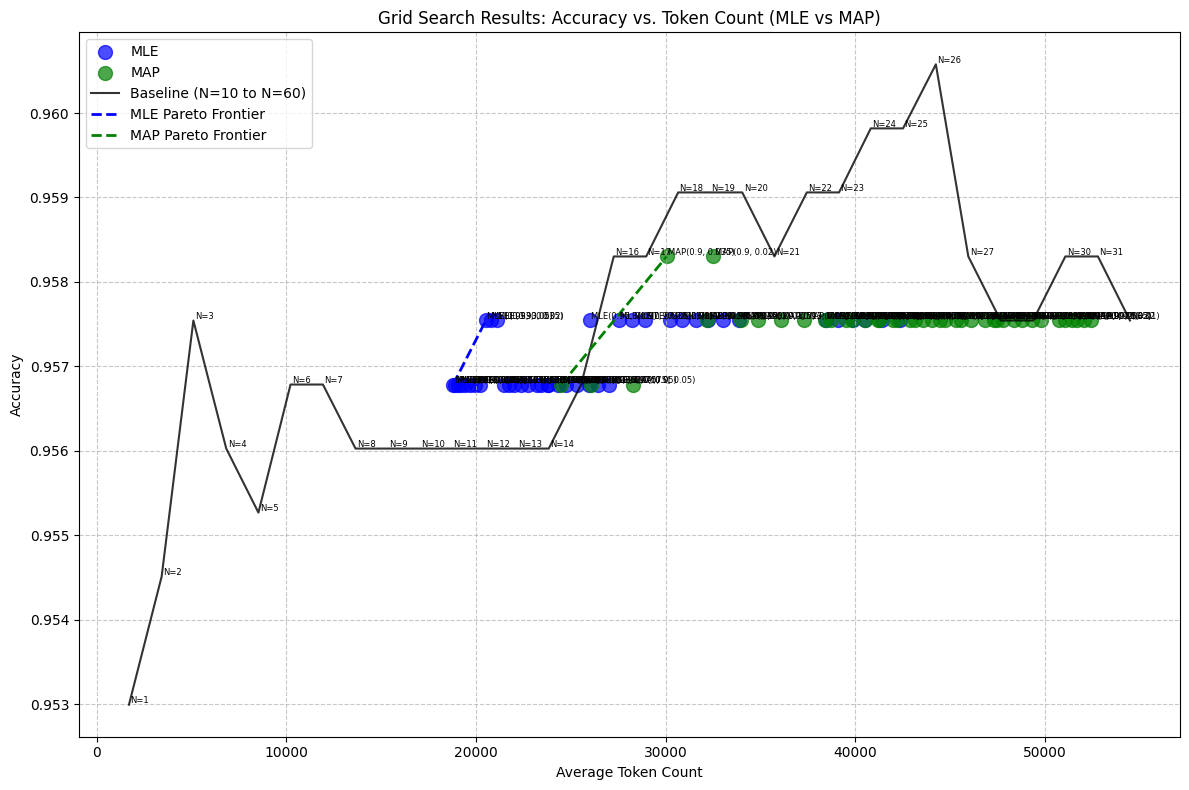


MLE Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9568, Avg Token Count: 18802.67
Target Score: 0.93, Percentile: 0.05, Accuracy: 0.9575, Avg Token Count: 20522.79

MAP Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9568, Avg Token Count: 24500.57
Target Score: 0.9, Percentile: 0.035, Accuracy: 0.9583, Avg Token Count: 30057.04


In [9]:
max_N_panel = 32
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)

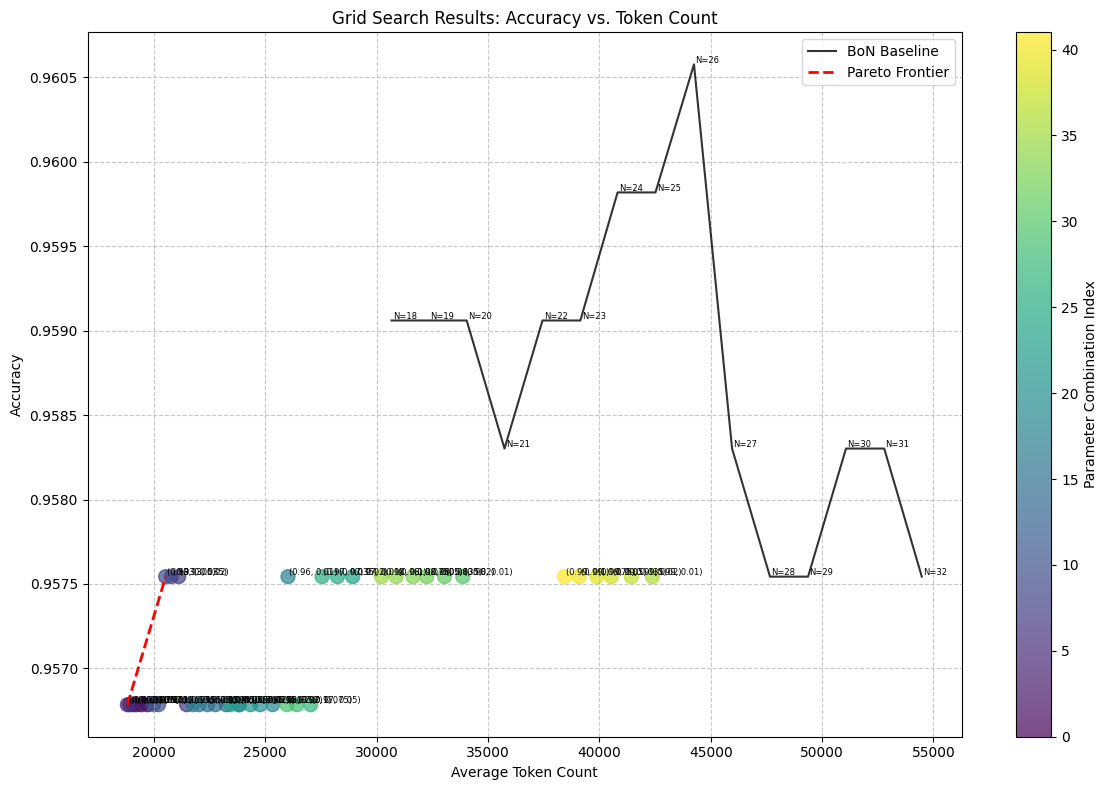

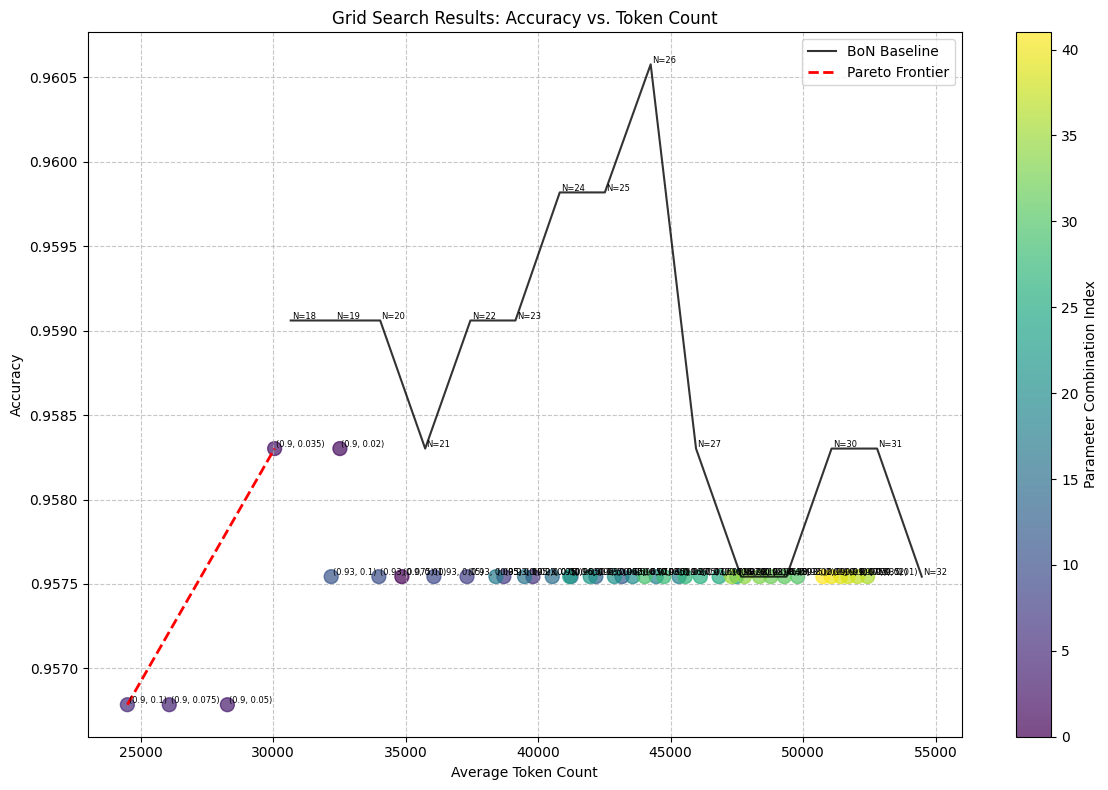

In [10]:
plot_optscale_start(mle_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)
plot_optscale_start(map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel, 17)

In [11]:
peek_number = 20

mle_estimated_params = []  # Store MLE estimates
map_estimated_params = []  # Store MAP estimates
predictor_params = []      # Store predictor's estimates

for i, (score, prediction) in enumerate(zip(val_scores, val_labels)):
    peek_data = np.array(score[0][:peek_number])
    
    # Store predictor's parameters
    prior_mu, prior_sigma = prediction
    predictor_params.append((prior_mu, prior_sigma))
    
    # MLE estimation with limited data
    initial_mu = np.mean(peek_data)
    initial_sigma = np.std(peek_data)
    mle_result = minimize(
        lambda params: neg_log_likelihood(params, peek_data),
        [initial_mu, initial_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    mle_mu, mle_sigma = mle_result.x
    mle_estimated_params.append((mle_mu, mle_sigma))
    
    # MAP estimation with limited data
    map_result = minimize(
        lambda params: neg_log_posterior(
            params, 
            peek_data, 
            prior_mu=prior_mu, 
            prior_sigma=prior_sigma
        ),
        [prior_mu, prior_sigma],
        bounds=[(None, None), (1e-6, None)],
        method='L-BFGS-B'
    )
    map_mu, map_sigma = map_result.x
    map_estimated_params.append((map_mu, map_sigma))
    
    # Print comparison for first 50 examples
    if i < 50:
        gt_mu, gt_sigma = original_params_compare[i]
        print(f"{i:<4} {prior_mu:11.4f} {prior_sigma:11.4f} {mle_mu:9.4f} {mle_sigma:9.4f} "
              f"{map_mu:9.4f} {map_sigma:9.4f} {gt_mu:9.4f} {gt_sigma:9.4f}")

# Call the function to perform the analysis
analyze_estimation_performance(predictor_params, mle_estimated_params, map_estimated_params, original_params_compare)


0         0.4319      0.0916    0.9858    0.0115    0.6571    0.5490    0.9875    0.0155
1         0.3712      0.0375    0.9831    0.0058    0.7749    0.1896    0.9844    0.0059
2         0.6217      0.1013    0.9350    0.0116    0.8852    0.5221    0.9271    0.0150
3         0.4076      0.0870    0.9829    0.0099    0.9243    0.0561    0.9839    0.0128
4         0.4718      0.1396    0.9705    0.0102    1.0852    0.0765    0.9720    0.0102
5         0.5645      0.0934    0.9681    0.0081    0.9598    0.0233    0.9692    0.0096
6         0.4193      0.0764    0.9924    0.0049    0.6736    0.5074    0.9922    0.0060
7         0.4935      0.1110    0.8462    0.0568    0.8404    0.0574    0.8624    0.0766
8         0.4501      0.1188    0.9837    0.0041    0.8640    0.1173    0.9827    0.0046
9         0.4603      0.1372    0.9959    0.0063    0.8885    0.0974    0.9985    0.0078
10        0.3858      0.0913    0.9880    0.0081    0.9658    0.0330    0.9879    0.0080
11        0.3843     

Target Score Panel: [0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99]
Percentile Panel: [0.01, 0.02, 0.035, 0.05, 0.075, 0.1]
Max N: 64

Evaluating MLE Results...


Target Score (MLE):   0%|          | 0/7 [00:00<?, ?it/s]

MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 61, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.01
MLE - Accuracy: 0.9568, Average Token Count: 37208.11
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 52, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.02
MLE - Accuracy: 0.9568, Average Token Count: 36959.29
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 44, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.035
MLE - Accuracy: 0.9583, Average Token Count: 36801.30
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.9, Percentile: 0.05
MLE - Accuracy: 0.9583, Average Token Count: 36738.00
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

MLE - Target Score: 0.9, Percentile: 0.075
MLE - Accuracy: 0.9583, Average Token Count: 36633.09
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

Target Score (MLE):  14%|█▍        | 1/7 [01:52<11:12, 112.07s/it]

MLE - Target Score: 0.9, Percentile: 0.1
MLE - Accuracy: 0.9583, Average Token Count: 36584.82


MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 64, 20, 20, 20, 

MLE - Target Score: 0.93, Percentile: 0.01
MLE - Accuracy: 0.9575, Average Token Count: 39642.56
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 58, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.93, Percentile: 0.02
MLE - Accuracy: 0.9575, Average Token Count: 39076.74
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 50, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.93, Percentile: 0.035
MLE - Accuracy: 0.9575, Average Token Count: 38577.47
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 44, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 59, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.93, Percentile: 0.05
MLE - Accuracy: 0.9575, Average Token Count: 38219.98
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 51, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.93, Percentile: 0.075
MLE - Accuracy: 0.9575, Average Token Count: 37852.57
MLE Min N Required [20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 20, 20, 20, 20, 20, 59, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  29%|██▊       | 2/7 [03:46<09:26, 113.38s/it]

MLE - Target Score: 0.93, Percentile: 0.1
MLE - Accuracy: 0.9568, Average Token Count: 37561.88


MLE Min N Required [20, 20, 49, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 61, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 56, 20, 20, 20, 20, 64, 20, 20, 20, 

MLE - Target Score: 0.95, Percentile: 0.01
MLE - Accuracy: 0.9575, Average Token Count: 42894.23
MLE Min N Required [20, 20, 41, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 63, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 52, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.95, Percentile: 0.02
MLE - Accuracy: 0.9575, Average Token Count: 42039.58
MLE Min N Required [20, 20, 36, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 54, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 45, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.95, Percentile: 0.035
MLE - Accuracy: 0.9575, Average Token Count: 41331.82
MLE Min N Required [20, 20, 32, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.95, Percentile: 0.05
MLE - Accuracy: 0.9575, Average Token Count: 40874.98
MLE Min N Required [20, 20, 28, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 60, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.95, Percentile: 0.075
MLE - Accuracy: 0.9575, Average Token Count: 40337.78
MLE Min N Required [20, 20, 25, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  43%|████▎     | 3/7 [05:44<07:42, 115.51s/it]

MLE - Target Score: 0.95, Percentile: 0.1
MLE - Accuracy: 0.9575, Average Token Count: 39909.65


MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 49, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 42, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 30, 49, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 44, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 

MLE - Target Score: 0.96, Percentile: 0.01
MLE - Accuracy: 0.9575, Average Token Count: 45846.32
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 42, 60, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 20, 36, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 26, 42, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.96, Percentile: 0.02
MLE - Accuracy: 0.9575, Average Token Count: 44870.04
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 51, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 31, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 22, 36, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.96, Percentile: 0.035
MLE - Accuracy: 0.9575, Average Token Count: 44033.67
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 46, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 28, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.96, Percentile: 0.05
MLE - Accuracy: 0.9575, Average Token Count: 43425.61
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 40, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.96, Percentile: 0.075
MLE - Accuracy: 0.9575, Average Token Count: 42705.14
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 35, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 63, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  57%|█████▋    | 4/7 [07:45<05:53, 117.84s/it]

MLE - Target Score: 0.96, Percentile: 0.1
MLE - Accuracy: 0.9575, Average Token Count: 42183.18


MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 20, 20, 20, 20, 63, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 55, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 47, 20, 53, 49, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 

MLE - Target Score: 0.97, Percentile: 0.01
MLE - Accuracy: 0.9583, Average Token Count: 50891.44
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 20, 20, 20, 20, 54, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 47, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 64, 20, 20, 56, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.97, Percentile: 0.02
MLE - Accuracy: 0.9575, Average Token Count: 49620.87
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 20, 20, 20, 20, 46, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 40, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 59, 20, 20, 20, 20, 20, 64, 55, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 64, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.97, Percentile: 0.035
MLE - Accuracy: 0.9575, Average Token Count: 48493.23
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 20, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 53, 20, 20, 20, 20, 20, 64, 49, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.97, Percentile: 0.05
MLE - Accuracy: 0.9575, Average Token Count: 47727.62
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 46, 20, 20, 20, 20, 20, 64, 42, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.97, Percentile: 0.075
MLE - Accuracy: 0.9575, Average Token Count: 46830.90
MLE Min N Required [20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 63, 64, 20, 64, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 20, 20, 20, 57, 38, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  71%|███████▏  | 5/7 [09:54<04:03, 121.88s/it]

MLE - Target Score: 0.97, Percentile: 0.1
MLE - Accuracy: 0.9575, Average Token Count: 46200.75


MLE Min N Required [20, 20, 64, 20, 26, 64, 20, 64, 20, 20, 20, 41, 20, 20, 20, 20, 25, 20, 20, 20, 32, 38, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 64, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 34, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 64, 20, 20, 20, 20, 53, 20, 20, 20, 20, 20, 20, 64, 64, 30, 20, 31, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 64, 20, 41, 20, 20, 20, 27, 20, 20, 20, 64, 20, 40, 20, 20, 20, 64, 20, 20, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 38, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 64, 23, 20, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 51, 64, 20, 64, 64, 20, 64, 20, 20, 20, 20, 64, 20, 20, 20, 

MLE - Target Score: 0.98, Percentile: 0.01
MLE - Accuracy: 0.9591, Average Token Count: 58778.85
MLE Min N Required [20, 20, 64, 20, 22, 60, 20, 64, 20, 20, 20, 35, 20, 20, 20, 20, 21, 20, 20, 20, 27, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 55, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 45, 20, 20, 20, 20, 20, 20, 64, 64, 25, 20, 27, 20, 20, 20, 64, 20, 20, 20, 20, 55, 20, 64, 20, 35, 20, 20, 20, 23, 20, 20, 20, 64, 20, 34, 20, 20, 20, 64, 20, 20, 64, 62, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 33, 62, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 56, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 56, 20, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 20, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20,

MLE - Target Score: 0.98, Percentile: 0.02
MLE - Accuracy: 0.9591, Average Token Count: 57065.09
MLE Min N Required [20, 20, 64, 20, 20, 52, 20, 64, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 20, 20, 24, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 47, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 39, 20, 20, 20, 20, 20, 20, 64, 64, 22, 20, 23, 20, 20, 20, 64, 20, 20, 20, 20, 47, 20, 64, 20, 30, 20, 20, 20, 20, 20, 20, 20, 64, 20, 29, 20, 20, 20, 64, 20, 20, 64, 53, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 28, 53, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 48, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20,

MLE - Target Score: 0.98, Percentile: 0.035
MLE - Accuracy: 0.9591, Average Token Count: 55519.76
MLE Min N Required [20, 20, 64, 20, 20, 46, 20, 64, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 21, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 42, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 35, 20, 20, 20, 20, 20, 20, 60, 64, 20, 20, 21, 20, 20, 20, 64, 20, 20, 20, 20, 42, 20, 64, 20, 27, 20, 20, 20, 20, 20, 20, 20, 64, 20, 26, 20, 20, 20, 64, 20, 20, 64, 48, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 25, 47, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 43, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 20, 25, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

MLE - Target Score: 0.98, Percentile: 0.05
MLE - Accuracy: 0.9591, Average Token Count: 54398.15
MLE Min N Required [20, 20, 64, 20, 20, 40, 20, 64, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 37, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 30, 20, 20, 20, 20, 20, 20, 52, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 37, 20, 64, 20, 23, 20, 20, 20, 20, 20, 20, 20, 64, 20, 23, 20, 20, 20, 64, 20, 20, 64, 41, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 22, 41, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 37, 20, 20, 64, 20, 20, 62, 20, 20, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

MLE - Target Score: 0.98, Percentile: 0.075
MLE - Accuracy: 0.9575, Average Token Count: 53078.53
MLE Min N Required [20, 20, 64, 20, 20, 36, 20, 64, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 64, 33, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 64, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 46, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 33, 20, 64, 20, 21, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 20, 20, 64, 37, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 36, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 33, 20, 20, 64, 20, 20, 55, 20, 20, 20, 20, 20, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Target Score (MLE):  86%|████████▌ | 6/7 [12:17<02:08, 128.94s/it]

MLE - Target Score: 0.98, Percentile: 0.1
MLE - Accuracy: 0.9575, Average Token Count: 52064.76


MLE Min N Required [20, 43, 64, 22, 64, 64, 20, 64, 64, 20, 20, 64, 40, 20, 20, 20, 64, 53, 20, 20, 64, 64, 20, 20, 20, 20, 51, 20, 20, 20, 64, 64, 20, 20, 20, 37, 20, 64, 64, 32, 64, 64, 20, 64, 63, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 38, 64, 64, 64, 64, 64, 33, 44, 33, 64, 20, 20, 20, 64, 20, 38, 64, 20, 64, 64, 20, 64, 20, 22, 64, 22, 20, 20, 64, 64, 64, 20, 64, 20, 20, 20, 64, 27, 20, 20, 46, 64, 43, 64, 20, 64, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 64, 64, 64, 27, 20, 64, 64, 20, 46, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 64, 64, 64, 20, 20, 64, 20, 20, 51, 20, 63, 20, 24, 64, 64, 20, 20, 64, 64, 64, 64, 20, 20, 20, 20, 20, 20, 51, 20, 64, 20, 20, 40, 25, 20, 20, 64, 35, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 22, 25, 64, 20, 20, 64, 20, 20, 20, 20, 64, 34, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 64, 64, 37, 20, 20, 20, 64, 64, 20, 64, 64, 25, 64, 20, 20, 20, 20, 64, 64, 20, 20, 

MLE - Target Score: 0.99, Percentile: 0.01
MLE - Accuracy: 0.9591, Average Token Count: 75127.10
MLE Min N Required [20, 37, 64, 20, 64, 64, 20, 64, 64, 20, 20, 64, 34, 20, 20, 20, 64, 45, 20, 20, 64, 64, 20, 20, 20, 20, 44, 20, 20, 20, 64, 64, 20, 20, 20, 31, 20, 64, 64, 27, 64, 64, 20, 64, 53, 64, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 32, 64, 64, 64, 64, 64, 28, 37, 28, 64, 20, 20, 20, 64, 20, 32, 64, 20, 64, 60, 20, 64, 20, 20, 64, 20, 20, 20, 64, 64, 55, 20, 62, 20, 20, 20, 64, 23, 20, 20, 39, 64, 37, 64, 20, 64, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 58, 64, 64, 23, 20, 64, 64, 20, 39, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 64, 64, 64, 20, 20, 64, 20, 20, 43, 20, 54, 20, 21, 64, 64, 20, 20, 64, 64, 64, 64, 20, 20, 20, 20, 20, 20, 43, 20, 64, 20, 20, 34, 22, 20, 20, 64, 30, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 21, 64, 20, 20, 64, 20, 20, 20, 20, 64, 29, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20,

MLE - Target Score: 0.99, Percentile: 0.02
MLE - Accuracy: 0.9591, Average Token Count: 73218.70
MLE Min N Required [20, 32, 64, 20, 64, 64, 20, 64, 64, 20, 20, 64, 29, 20, 20, 20, 64, 39, 20, 20, 64, 64, 20, 20, 20, 20, 38, 20, 20, 20, 64, 56, 20, 20, 20, 27, 20, 64, 64, 23, 64, 64, 20, 64, 46, 64, 20, 20, 20, 20, 20, 20, 20, 20, 61, 20, 20, 28, 64, 64, 64, 62, 64, 24, 32, 24, 64, 20, 20, 20, 64, 20, 28, 64, 20, 64, 52, 20, 64, 20, 20, 64, 20, 20, 20, 64, 64, 47, 20, 54, 20, 20, 20, 64, 20, 20, 20, 33, 64, 31, 64, 20, 64, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 50, 64, 64, 20, 20, 64, 64, 20, 33, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 20, 61, 64, 20, 20, 20, 64, 20, 64, 64, 64, 20, 20, 64, 20, 20, 37, 20, 46, 20, 20, 64, 64, 20, 20, 64, 64, 64, 64, 20, 20, 20, 20, 20, 20, 37, 20, 64, 20, 20, 29, 20, 20, 20, 64, 26, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 25, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20,

MLE - Target Score: 0.99, Percentile: 0.035
MLE - Accuracy: 0.9591, Average Token Count: 71504.37
MLE Min N Required [20, 28, 64, 20, 64, 64, 20, 64, 58, 20, 20, 64, 26, 20, 20, 20, 64, 35, 20, 20, 64, 64, 20, 20, 20, 20, 34, 20, 20, 20, 64, 51, 20, 20, 20, 24, 20, 64, 64, 21, 64, 64, 20, 64, 41, 64, 20, 20, 20, 20, 20, 20, 20, 20, 55, 20, 20, 25, 64, 64, 64, 56, 64, 22, 29, 22, 64, 20, 20, 20, 64, 20, 25, 64, 20, 62, 46, 20, 64, 20, 20, 64, 20, 20, 20, 64, 64, 42, 20, 48, 20, 20, 20, 64, 20, 20, 20, 30, 64, 28, 64, 20, 64, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 44, 64, 64, 20, 20, 64, 64, 20, 30, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 20, 54, 64, 20, 20, 20, 64, 20, 64, 64, 64, 20, 20, 64, 20, 20, 33, 20, 41, 20, 20, 57, 64, 20, 20, 64, 64, 64, 64, 20, 20, 20, 20, 20, 20, 34, 20, 64, 20, 20, 26, 20, 20, 20, 64, 23, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 22, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20

MLE - Target Score: 0.99, Percentile: 0.05
MLE - Accuracy: 0.9591, Average Token Count: 70279.80
MLE Min N Required [20, 25, 64, 20, 64, 64, 20, 64, 50, 20, 20, 64, 23, 20, 20, 20, 64, 30, 20, 20, 64, 64, 20, 20, 20, 20, 29, 20, 20, 20, 64, 44, 20, 20, 20, 21, 20, 64, 64, 20, 64, 64, 20, 64, 36, 64, 20, 20, 20, 20, 20, 20, 20, 20, 48, 20, 20, 21, 64, 64, 64, 48, 64, 20, 25, 20, 64, 20, 20, 20, 57, 20, 21, 64, 20, 54, 40, 20, 64, 20, 20, 56, 20, 20, 20, 64, 64, 36, 20, 42, 20, 20, 20, 64, 20, 20, 20, 26, 64, 24, 64, 20, 64, 64, 20, 20, 64, 20, 20, 20, 64, 64, 64, 20, 38, 64, 64, 20, 20, 64, 64, 20, 26, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 47, 64, 20, 20, 20, 64, 20, 64, 64, 64, 20, 20, 64, 20, 20, 29, 20, 36, 20, 20, 50, 64, 20, 20, 64, 64, 64, 64, 20, 20, 20, 20, 20, 20, 29, 20, 64, 20, 20, 23, 20, 20, 20, 64, 20, 64, 64, 20, 64, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20,

MLE - Target Score: 0.99, Percentile: 0.075
MLE - Accuracy: 0.9591, Average Token Count: 68736.41
MLE Min N Required [20, 22, 64, 20, 64, 64, 20, 64, 45, 20, 20, 64, 20, 20, 20, 20, 57, 27, 20, 20, 64, 64, 20, 20, 20, 20, 26, 20, 20, 20, 58, 39, 20, 20, 20, 20, 20, 64, 64, 20, 64, 64, 20, 64, 32, 64, 20, 20, 20, 20, 20, 20, 20, 20, 42, 20, 20, 20, 64, 64, 64, 43, 64, 20, 22, 20, 64, 20, 20, 20, 50, 20, 20, 64, 20, 48, 36, 20, 64, 20, 20, 50, 20, 20, 20, 64, 64, 32, 20, 37, 20, 20, 20, 64, 20, 20, 20, 23, 64, 22, 64, 20, 61, 64, 20, 20, 64, 20, 20, 20, 64, 61, 64, 20, 34, 64, 64, 20, 20, 64, 64, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 42, 64, 20, 20, 20, 64, 20, 64, 64, 64, 20, 20, 57, 20, 20, 26, 20, 32, 20, 20, 44, 64, 20, 20, 64, 64, 64, 64, 20, 20, 20, 20, 20, 20, 26, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 64, 64, 20, 62, 64, 20, 20, 20, 20, 64, 64, 64, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 64, 20, 20, 64, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20

Target Score (MLE): 100%|██████████| 7/7 [15:14<00:00, 130.58s/it]


MLE - Target Score: 0.99, Percentile: 0.1
MLE - Accuracy: 0.9591, Average Token Count: 67471.38

Evaluating MAP Results...


Target Score (MAP):   0%|          | 0/7 [00:00<?, ?it/s]

MAP Min N Required [43, 28, 31, 20, 20, 20, 42, 30, 20, 20, 20, 20, 23, 20, 37, 20, 20, 20, 26, 20, 20, 20, 33, 36, 20, 20, 20, 41, 20, 20, 20, 20, 42, 20, 20, 36, 20, 20, 21, 20, 20, 32, 39, 32, 20, 20, 20, 37, 20, 20, 42, 20, 38, 40, 40, 22, 48, 40, 43, 20, 20, 20, 44, 20, 20, 42, 40, 32, 28, 40, 22, 41, 20, 20, 20, 20, 40, 20, 20, 20, 35, 37, 20, 20, 20, 20, 20, 20, 36, 20, 41, 32, 20, 43, 41, 35, 41, 20, 20, 20, 64, 20, 20, 44, 40, 20, 20, 38, 29, 31, 37, 44, 20, 24, 20, 38, 20, 20, 21, 64, 20, 20, 20, 20, 35, 20, 48, 24, 38, 27, 36, 43, 20, 20, 38, 20, 20, 20, 45, 20, 20, 20, 20, 20, 20, 29, 20, 20, 40, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 38, 39, 20, 20, 20, 20, 20, 39, 34, 20, 20, 32, 20, 20, 20, 20, 28, 32, 20, 20, 20, 20, 20, 33, 20, 20, 20, 64, 20, 20, 20, 20, 33, 20, 20, 20, 46, 41, 41, 20, 20, 20, 23, 20, 20, 20, 35, 39, 41, 20, 20, 44, 41, 20, 20, 20, 20, 38, 26, 20, 20, 36, 20, 37, 43, 20, 20, 20, 20, 20, 20, 20, 38, 20, 20, 20, 31, 40, 20, 30, 20, 32, 20, 20, 38, 

MAP - Target Score: 0.9, Percentile: 0.01
MAP - Accuracy: 0.9568, Average Token Count: 47034.11
MAP Min N Required [37, 24, 26, 20, 20, 20, 36, 25, 20, 20, 20, 20, 20, 20, 32, 20, 20, 20, 22, 20, 20, 20, 28, 30, 20, 20, 20, 35, 20, 20, 20, 20, 36, 20, 20, 31, 20, 20, 20, 20, 20, 28, 33, 27, 20, 20, 20, 32, 20, 20, 36, 20, 32, 34, 34, 20, 41, 34, 36, 20, 20, 20, 38, 20, 20, 36, 34, 27, 24, 34, 20, 35, 20, 20, 20, 20, 34, 20, 20, 20, 29, 31, 20, 20, 20, 20, 20, 20, 31, 20, 34, 27, 20, 36, 35, 30, 35, 20, 20, 20, 64, 20, 20, 37, 34, 20, 20, 32, 25, 26, 31, 37, 20, 20, 20, 32, 20, 20, 20, 64, 20, 20, 20, 20, 30, 20, 41, 21, 32, 23, 31, 37, 20, 20, 32, 20, 20, 20, 38, 20, 20, 20, 20, 20, 20, 25, 20, 20, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 32, 34, 20, 20, 20, 20, 20, 33, 29, 20, 20, 27, 20, 20, 20, 20, 24, 27, 20, 20, 20, 20, 20, 28, 20, 20, 20, 61, 20, 20, 20, 20, 29, 20, 20, 20, 39, 35, 35, 20, 20, 20, 20, 20, 20, 20, 30, 33, 35, 20, 20, 37, 35, 20, 20, 20, 20, 32, 22, 20, 20, 

MAP - Target Score: 0.9, Percentile: 0.02
MAP - Accuracy: 0.9568, Average Token Count: 43687.45
MAP Min N Required [32, 20, 23, 20, 20, 20, 31, 22, 20, 20, 20, 20, 20, 20, 27, 20, 20, 20, 20, 20, 20, 20, 24, 26, 20, 20, 20, 30, 20, 20, 20, 20, 31, 20, 20, 27, 20, 20, 20, 20, 20, 24, 29, 24, 20, 20, 20, 27, 20, 20, 31, 20, 28, 29, 29, 20, 35, 30, 31, 20, 20, 20, 32, 20, 20, 31, 29, 23, 21, 29, 20, 30, 20, 20, 20, 20, 29, 20, 20, 20, 25, 27, 20, 20, 20, 20, 20, 20, 26, 20, 30, 23, 20, 31, 30, 26, 30, 20, 20, 20, 59, 20, 20, 32, 29, 20, 20, 27, 21, 22, 27, 32, 20, 20, 20, 28, 20, 20, 20, 64, 20, 20, 20, 20, 26, 20, 35, 20, 27, 20, 27, 32, 20, 20, 28, 20, 20, 20, 33, 20, 20, 20, 20, 20, 20, 21, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 28, 29, 20, 20, 20, 20, 20, 28, 25, 20, 20, 24, 20, 20, 20, 20, 21, 23, 20, 20, 20, 20, 20, 24, 20, 20, 20, 52, 20, 20, 20, 20, 25, 20, 20, 20, 34, 30, 30, 20, 20, 20, 20, 20, 20, 20, 26, 29, 30, 20, 20, 32, 30, 20, 20, 20, 20, 28, 20, 20, 20, 

MAP - Target Score: 0.9, Percentile: 0.035
MAP - Accuracy: 0.9575, Average Token Count: 41082.59
MAP Min N Required [28, 20, 20, 20, 20, 20, 28, 20, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 21, 23, 20, 20, 20, 27, 20, 20, 20, 20, 28, 20, 20, 24, 20, 20, 20, 20, 20, 21, 26, 21, 20, 20, 20, 24, 20, 20, 28, 20, 25, 26, 26, 20, 31, 26, 28, 20, 20, 20, 29, 20, 20, 28, 26, 21, 20, 26, 20, 27, 20, 20, 20, 20, 26, 20, 20, 20, 23, 24, 20, 20, 20, 20, 20, 20, 24, 20, 27, 21, 20, 28, 27, 23, 27, 20, 20, 20, 53, 20, 20, 29, 26, 20, 20, 25, 20, 20, 24, 28, 20, 20, 20, 25, 20, 20, 20, 64, 20, 20, 20, 20, 23, 20, 31, 20, 25, 20, 24, 28, 20, 20, 25, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 25, 26, 20, 20, 20, 20, 20, 25, 22, 20, 20, 21, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 22, 20, 20, 20, 47, 20, 20, 20, 20, 22, 20, 20, 20, 30, 27, 27, 20, 20, 20, 20, 20, 20, 20, 23, 26, 27, 20, 20, 29, 27, 20, 20, 20, 20, 25, 20, 20, 20,

MAP - Target Score: 0.9, Percentile: 0.05
MAP - Accuracy: 0.9575, Average Token Count: 39470.81
MAP Min N Required [25, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 24, 20, 20, 21, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 21, 20, 20, 24, 20, 21, 23, 23, 20, 27, 23, 24, 20, 20, 20, 25, 20, 20, 24, 23, 20, 20, 23, 20, 23, 20, 20, 20, 20, 23, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 24, 23, 20, 23, 20, 20, 20, 46, 20, 20, 25, 23, 20, 20, 21, 20, 20, 21, 25, 20, 20, 20, 22, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 27, 20, 21, 20, 21, 25, 20, 20, 22, 20, 20, 20, 25, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 21, 22, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 41, 20, 20, 20, 20, 20, 20, 20, 20, 26, 23, 23, 20, 20, 20, 20, 20, 20, 20, 20, 22, 24, 20, 20, 25, 23, 20, 20, 20, 20, 21, 20, 20, 20, 

MAP - Target Score: 0.9, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 37888.40
MAP Min N Required [22, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 24, 20, 22, 20, 20, 20, 22, 20, 20, 21, 20, 20, 20, 20, 20, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 22, 21, 20, 21, 20, 20, 20, 41, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 24, 20, 20, 20, 20, 22, 20, 20, 20, 20, 20, 20, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 20, 20, 20, 20, 20, 20, 20, 20, 23, 21, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 20, 20, 22, 21, 20, 20, 20, 20, 20, 20, 20, 20,

Target Score (MAP):  14%|█▍        | 1/7 [02:22<14:13, 142.27s/it]

MAP - Target Score: 0.9, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 37077.04


MAP Min N Required [64, 44, 45, 20, 20, 20, 62, 64, 23, 20, 20, 25, 38, 20, 57, 23, 20, 20, 40, 20, 20, 20, 48, 52, 20, 20, 20, 60, 20, 20, 20, 20, 63, 20, 20, 53, 20, 20, 35, 20, 20, 48, 58, 50, 20, 20, 20, 55, 20, 20, 62, 25, 55, 59, 59, 32, 64, 60, 63, 20, 20, 20, 64, 20, 29, 63, 58, 46, 44, 59, 36, 61, 34, 25, 20, 20, 59, 20, 20, 20, 51, 54, 25, 20, 20, 20, 27, 31, 55, 20, 60, 49, 20, 64, 60, 53, 61, 20, 29, 20, 64, 20, 28, 64, 58, 20, 20, 56, 46, 48, 54, 64, 22, 36, 20, 56, 64, 20, 32, 64, 32, 20, 23, 20, 52, 20, 64, 36, 55, 43, 53, 64, 28, 33, 59, 20, 20, 22, 64, 20, 20, 20, 20, 20, 20, 49, 24, 46, 60, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 56, 58, 26, 20, 20, 20, 20, 60, 52, 20, 20, 47, 20, 24, 20, 20, 44, 46, 20, 20, 20, 20, 20, 49, 20, 20, 20, 64, 20, 20, 20, 20, 49, 20, 32, 20, 64, 61, 61, 21, 20, 20, 35, 20, 30, 20, 51, 58, 61, 23, 27, 64, 61, 20, 20, 20, 20, 56, 40, 20, 30, 53, 20, 57, 63, 20, 20, 20, 20, 20, 20, 20, 58, 20, 20, 20, 64, 59, 20, 44, 20, 64, 20, 20, 57, 

MAP - Target Score: 0.93, Percentile: 0.01
MAP - Accuracy: 0.9583, Average Token Count: 60987.20
MAP Min N Required [54, 37, 39, 20, 20, 20, 53, 64, 20, 20, 20, 21, 32, 20, 48, 20, 20, 20, 34, 20, 20, 20, 41, 44, 20, 20, 20, 51, 20, 20, 20, 20, 53, 20, 20, 46, 20, 20, 30, 20, 20, 41, 50, 42, 20, 20, 20, 46, 20, 20, 53, 22, 47, 50, 50, 28, 60, 51, 53, 20, 20, 20, 64, 20, 24, 53, 49, 39, 38, 50, 30, 52, 29, 22, 20, 20, 50, 20, 20, 20, 43, 46, 21, 20, 20, 20, 23, 26, 47, 20, 51, 41, 20, 64, 51, 45, 51, 20, 24, 20, 64, 20, 24, 55, 50, 20, 20, 47, 39, 41, 46, 55, 20, 31, 20, 48, 64, 20, 27, 64, 28, 20, 20, 20, 44, 20, 60, 31, 47, 36, 45, 57, 24, 28, 50, 20, 20, 20, 56, 20, 20, 20, 20, 20, 20, 42, 20, 39, 51, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 47, 49, 22, 20, 20, 20, 20, 51, 45, 20, 20, 40, 20, 21, 20, 20, 37, 39, 20, 20, 20, 20, 20, 41, 20, 20, 20, 64, 20, 20, 20, 20, 42, 20, 27, 20, 59, 52, 52, 20, 20, 20, 30, 20, 25, 20, 44, 50, 52, 20, 23, 55, 52, 20, 20, 20, 20, 48, 34, 20, 26,

MAP - Target Score: 0.93, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 55707.61
MAP Min N Required [47, 32, 33, 20, 20, 20, 45, 59, 20, 20, 20, 20, 28, 20, 42, 20, 20, 20, 29, 20, 20, 20, 35, 38, 20, 20, 20, 44, 20, 20, 20, 20, 46, 20, 20, 39, 20, 20, 26, 20, 20, 35, 43, 36, 20, 20, 20, 40, 20, 20, 46, 20, 40, 43, 43, 24, 52, 44, 46, 20, 20, 20, 64, 20, 21, 46, 42, 34, 32, 43, 26, 44, 25, 20, 20, 20, 43, 20, 20, 20, 37, 39, 20, 20, 20, 20, 20, 23, 40, 20, 44, 36, 20, 64, 44, 38, 44, 20, 21, 20, 64, 20, 21, 48, 43, 20, 20, 41, 34, 35, 39, 47, 20, 27, 20, 41, 64, 20, 23, 64, 24, 20, 20, 20, 38, 20, 51, 27, 40, 31, 39, 49, 21, 24, 43, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 36, 20, 34, 44, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 41, 42, 20, 20, 20, 20, 20, 44, 38, 20, 20, 34, 20, 20, 20, 20, 32, 34, 20, 20, 20, 20, 20, 35, 20, 20, 20, 64, 20, 20, 20, 20, 36, 20, 23, 20, 51, 44, 45, 20, 20, 20, 25, 20, 22, 20, 38, 43, 45, 20, 20, 47, 44, 20, 20, 20, 20, 41, 30, 20, 22,

MAP - Target Score: 0.93, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 51306.38
MAP Min N Required [42, 29, 30, 20, 20, 20, 41, 53, 20, 20, 20, 20, 25, 20, 37, 20, 20, 20, 26, 20, 20, 20, 31, 34, 20, 20, 20, 39, 20, 20, 20, 20, 41, 20, 20, 35, 20, 20, 23, 20, 20, 31, 38, 33, 20, 20, 20, 36, 20, 20, 41, 20, 36, 39, 38, 21, 46, 39, 41, 20, 20, 20, 64, 20, 20, 41, 38, 30, 29, 39, 23, 40, 22, 20, 20, 20, 38, 20, 20, 20, 33, 35, 20, 20, 20, 20, 20, 20, 36, 20, 39, 32, 20, 64, 39, 34, 40, 20, 20, 20, 64, 20, 20, 43, 38, 20, 20, 36, 30, 31, 35, 42, 20, 24, 20, 37, 59, 20, 21, 64, 21, 20, 20, 20, 34, 20, 46, 24, 36, 28, 35, 44, 20, 22, 38, 20, 20, 20, 43, 20, 20, 20, 20, 20, 20, 32, 20, 30, 39, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 36, 38, 20, 20, 20, 20, 20, 39, 34, 20, 20, 31, 20, 20, 20, 20, 29, 30, 20, 20, 20, 20, 20, 32, 20, 20, 20, 64, 20, 20, 20, 20, 32, 20, 21, 20, 46, 40, 40, 20, 20, 20, 23, 20, 20, 20, 34, 38, 40, 20, 20, 42, 40, 20, 20, 20, 20, 37, 26, 20, 20

MAP - Target Score: 0.93, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 48470.63
MAP Min N Required [36, 25, 26, 20, 20, 20, 35, 46, 20, 20, 20, 20, 21, 20, 32, 20, 20, 20, 23, 20, 20, 20, 27, 30, 20, 20, 20, 34, 20, 20, 20, 20, 36, 20, 20, 30, 20, 20, 20, 20, 20, 27, 33, 28, 20, 20, 20, 31, 20, 20, 35, 20, 31, 33, 33, 20, 40, 34, 36, 20, 20, 20, 64, 20, 20, 35, 33, 26, 25, 34, 20, 34, 20, 20, 20, 20, 33, 20, 20, 20, 29, 31, 20, 20, 20, 20, 20, 20, 31, 20, 34, 28, 20, 63, 34, 30, 34, 20, 20, 20, 64, 20, 20, 37, 33, 20, 20, 32, 26, 27, 30, 37, 20, 21, 20, 32, 51, 20, 20, 64, 20, 20, 20, 20, 29, 20, 40, 21, 31, 24, 30, 38, 20, 20, 33, 20, 20, 20, 37, 20, 20, 20, 20, 20, 20, 28, 20, 26, 34, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 32, 33, 20, 20, 20, 20, 20, 34, 30, 20, 20, 27, 20, 20, 20, 20, 25, 26, 20, 20, 20, 20, 20, 28, 20, 20, 20, 62, 20, 20, 20, 20, 28, 20, 20, 20, 40, 34, 35, 20, 20, 20, 20, 20, 20, 20, 29, 33, 35, 20, 20, 36, 34, 20, 20, 20, 20, 32, 23, 20, 20,

MAP - Target Score: 0.93, Percentile: 0.075
MAP - Accuracy: 0.9575, Average Token Count: 45335.27
MAP Min N Required [32, 22, 23, 20, 20, 20, 31, 41, 20, 20, 20, 20, 20, 20, 29, 20, 20, 20, 20, 20, 20, 20, 24, 26, 20, 20, 20, 30, 20, 20, 20, 20, 32, 20, 20, 27, 20, 20, 20, 20, 20, 24, 29, 25, 20, 20, 20, 28, 20, 20, 31, 20, 28, 30, 30, 20, 36, 30, 32, 20, 20, 20, 64, 20, 20, 32, 29, 23, 22, 30, 20, 31, 20, 20, 20, 20, 30, 20, 20, 20, 26, 27, 20, 20, 20, 20, 20, 20, 28, 20, 30, 25, 20, 56, 30, 27, 31, 20, 20, 20, 64, 20, 20, 33, 29, 20, 20, 28, 23, 24, 27, 33, 20, 20, 20, 28, 45, 20, 20, 64, 20, 20, 20, 20, 26, 20, 35, 20, 28, 22, 27, 34, 20, 20, 30, 20, 20, 20, 33, 20, 20, 20, 20, 20, 20, 25, 20, 23, 30, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 28, 29, 20, 20, 20, 20, 20, 30, 26, 20, 20, 24, 20, 20, 20, 20, 22, 23, 20, 20, 20, 20, 20, 25, 20, 20, 20, 55, 20, 20, 20, 20, 25, 20, 20, 20, 35, 31, 31, 20, 20, 20, 20, 20, 20, 20, 26, 29, 31, 20, 20, 32, 31, 20, 20, 20, 20, 28, 20, 20, 20

Target Score (MAP):  29%|██▊       | 2/7 [05:03<12:46, 153.39s/it]

MAP - Target Score: 0.93, Percentile: 0.1
MAP - Accuracy: 0.9568, Average Token Count: 43076.95


MAP Min N Required [64, 64, 64, 20, 20, 20, 64, 64, 35, 27, 20, 39, 59, 20, 64, 36, 26, 34, 60, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 26, 64, 20, 24, 56, 20, 31, 64, 64, 64, 28, 27, 20, 64, 31, 23, 64, 39, 64, 64, 64, 47, 64, 64, 64, 20, 31, 20, 64, 20, 45, 64, 64, 64, 64, 64, 55, 64, 52, 50, 20, 20, 64, 20, 35, 20, 64, 64, 40, 21, 20, 35, 49, 60, 64, 22, 64, 64, 20, 64, 64, 64, 64, 29, 46, 26, 64, 22, 47, 64, 64, 20, 20, 64, 64, 64, 64, 64, 35, 54, 20, 64, 64, 20, 46, 64, 53, 20, 40, 20, 64, 26, 64, 53, 64, 64, 64, 64, 44, 50, 64, 22, 20, 36, 64, 20, 20, 20, 20, 20, 31, 64, 44, 64, 64, 25, 26, 20, 20, 28, 20, 29, 20, 20, 20, 64, 64, 64, 39, 23, 20, 23, 24, 64, 64, 20, 20, 64, 20, 38, 21, 20, 64, 64, 20, 32, 29, 20, 20, 64, 28, 20, 30, 64, 20, 20, 20, 20, 64, 20, 50, 20, 64, 64, 64, 34, 25, 30, 50, 20, 44, 20, 64, 64, 64, 39, 41, 64, 64, 20, 26, 20, 20, 64, 61, 20, 46, 64, 20, 64, 64, 20, 20, 20, 29, 20, 32, 20, 64, 26, 20, 20, 64, 64, 20, 62, 20, 64, 27, 20, 64, 

MAP - Target Score: 0.95, Percentile: 0.01
MAP - Accuracy: 0.9591, Average Token Count: 72668.86
MAP Min N Required [64, 56, 55, 20, 20, 20, 64, 64, 30, 23, 20, 34, 50, 20, 64, 30, 23, 29, 51, 20, 20, 20, 58, 63, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 22, 64, 20, 21, 48, 20, 26, 58, 64, 63, 24, 23, 20, 64, 27, 20, 64, 33, 64, 64, 64, 40, 64, 64, 64, 20, 27, 20, 64, 20, 38, 64, 64, 56, 56, 64, 47, 64, 45, 43, 20, 20, 64, 20, 30, 20, 61, 64, 34, 20, 20, 29, 42, 51, 64, 20, 64, 61, 20, 64, 64, 64, 64, 25, 40, 22, 64, 20, 40, 64, 64, 20, 20, 64, 58, 60, 64, 64, 30, 46, 20, 64, 64, 20, 39, 64, 45, 20, 34, 20, 62, 22, 64, 45, 64, 55, 64, 64, 38, 43, 64, 20, 20, 30, 64, 20, 20, 20, 20, 20, 27, 64, 37, 64, 64, 21, 22, 20, 20, 24, 20, 25, 20, 20, 20, 64, 64, 64, 33, 20, 20, 20, 21, 64, 64, 20, 20, 57, 20, 33, 20, 20, 56, 56, 20, 27, 25, 20, 20, 59, 24, 20, 26, 64, 20, 20, 20, 20, 59, 20, 43, 20, 64, 64, 64, 29, 21, 25, 43, 20, 37, 20, 62, 64, 64, 33, 35, 64, 64, 20, 22, 20, 20, 64, 52, 20, 39,

MAP - Target Score: 0.95, Percentile: 0.02
MAP - Accuracy: 0.9583, Average Token Count: 69228.97
MAP Min N Required [64, 48, 47, 20, 20, 20, 64, 64, 26, 20, 20, 29, 43, 20, 61, 26, 20, 25, 44, 20, 20, 20, 50, 54, 20, 20, 20, 62, 20, 20, 20, 20, 64, 20, 20, 56, 20, 20, 41, 20, 23, 50, 61, 54, 21, 20, 20, 57, 23, 20, 64, 28, 58, 61, 61, 34, 64, 62, 64, 20, 23, 20, 64, 20, 33, 64, 60, 48, 48, 62, 40, 63, 38, 37, 20, 20, 61, 20, 25, 20, 53, 56, 29, 20, 20, 25, 36, 44, 59, 20, 62, 52, 20, 64, 63, 55, 63, 22, 34, 20, 64, 20, 34, 64, 60, 20, 20, 58, 50, 52, 56, 64, 26, 39, 20, 59, 64, 20, 34, 64, 39, 20, 29, 20, 53, 20, 64, 38, 57, 47, 55, 64, 32, 37, 63, 20, 20, 26, 64, 20, 20, 20, 20, 20, 23, 56, 32, 64, 63, 20, 20, 20, 20, 20, 20, 21, 20, 20, 20, 64, 58, 60, 28, 20, 20, 20, 20, 64, 57, 20, 20, 49, 20, 28, 20, 20, 48, 48, 20, 23, 22, 20, 20, 50, 21, 20, 22, 64, 20, 20, 20, 20, 51, 20, 37, 20, 64, 63, 64, 25, 20, 22, 37, 20, 32, 20, 53, 61, 64, 28, 30, 64, 63, 20, 20, 20, 20, 59, 44, 20, 33,

MAP - Target Score: 0.95, Percentile: 0.035
MAP - Accuracy: 0.9583, Average Token Count: 64934.91
MAP Min N Required [59, 43, 42, 20, 20, 20, 58, 64, 23, 20, 20, 26, 38, 20, 55, 23, 20, 22, 39, 20, 20, 20, 44, 49, 20, 20, 20, 56, 20, 20, 20, 20, 59, 20, 20, 50, 20, 20, 37, 20, 20, 44, 55, 48, 20, 20, 20, 51, 20, 20, 58, 25, 52, 55, 55, 31, 64, 56, 59, 20, 20, 20, 64, 20, 29, 58, 54, 43, 43, 55, 36, 56, 34, 33, 20, 20, 55, 20, 23, 20, 47, 50, 26, 20, 20, 23, 32, 39, 53, 20, 56, 47, 20, 64, 56, 49, 57, 20, 30, 20, 64, 20, 31, 61, 54, 20, 20, 52, 45, 46, 50, 61, 23, 35, 20, 53, 64, 20, 30, 64, 35, 20, 26, 20, 48, 20, 64, 34, 51, 42, 49, 64, 29, 33, 57, 20, 20, 23, 62, 20, 20, 20, 20, 20, 20, 50, 29, 64, 56, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 52, 54, 25, 20, 20, 20, 20, 57, 51, 20, 20, 43, 20, 25, 20, 20, 43, 43, 20, 21, 20, 20, 20, 45, 20, 20, 20, 64, 20, 20, 20, 20, 45, 20, 33, 20, 64, 56, 57, 23, 20, 20, 33, 20, 29, 20, 48, 55, 57, 25, 27, 60, 56, 20, 20, 20, 20, 53, 40, 20, 30

MAP - Target Score: 0.95, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 61196.62
MAP Min N Required [51, 37, 36, 20, 20, 20, 50, 64, 20, 20, 20, 22, 33, 20, 47, 20, 20, 20, 34, 20, 20, 20, 38, 42, 20, 20, 20, 48, 20, 20, 20, 20, 51, 20, 20, 43, 20, 20, 32, 20, 20, 38, 47, 42, 20, 20, 20, 44, 20, 20, 50, 22, 45, 48, 48, 27, 57, 48, 51, 20, 20, 20, 64, 20, 25, 51, 47, 37, 38, 48, 31, 49, 30, 28, 20, 20, 48, 20, 20, 20, 41, 44, 23, 20, 20, 20, 28, 34, 45, 20, 48, 40, 20, 64, 49, 43, 49, 20, 26, 20, 64, 20, 27, 53, 47, 20, 20, 45, 39, 40, 43, 52, 20, 31, 20, 46, 64, 20, 26, 64, 30, 20, 23, 20, 41, 20, 56, 30, 44, 36, 43, 56, 25, 29, 49, 20, 20, 20, 53, 20, 20, 20, 20, 20, 20, 43, 25, 64, 49, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 45, 47, 22, 20, 20, 20, 20, 49, 44, 20, 20, 38, 20, 22, 20, 20, 37, 37, 20, 20, 20, 20, 20, 39, 20, 20, 20, 64, 20, 20, 20, 20, 39, 20, 29, 20, 57, 49, 50, 20, 20, 20, 29, 20, 25, 20, 41, 47, 49, 22, 23, 52, 49, 20, 20, 20, 20, 45, 34, 20, 26,

MAP - Target Score: 0.95, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 56458.30
MAP Min N Required [46, 33, 32, 20, 20, 20, 45, 64, 20, 20, 20, 20, 30, 20, 42, 20, 20, 20, 30, 20, 20, 20, 34, 38, 20, 20, 20, 43, 20, 20, 20, 20, 45, 20, 20, 39, 20, 20, 28, 20, 20, 34, 42, 37, 20, 20, 20, 39, 20, 20, 45, 20, 40, 42, 42, 24, 51, 43, 45, 20, 20, 20, 64, 20, 23, 45, 42, 33, 33, 43, 28, 44, 26, 25, 20, 20, 42, 20, 20, 20, 36, 39, 20, 20, 20, 20, 25, 30, 41, 20, 43, 36, 20, 64, 43, 38, 44, 20, 23, 20, 64, 20, 24, 47, 42, 20, 20, 40, 35, 36, 38, 47, 20, 27, 20, 41, 64, 20, 23, 64, 27, 20, 20, 20, 37, 20, 50, 27, 39, 32, 38, 49, 22, 25, 44, 20, 20, 20, 48, 20, 20, 20, 20, 20, 20, 38, 22, 59, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 64, 40, 41, 20, 20, 20, 20, 20, 44, 39, 20, 20, 34, 20, 20, 20, 20, 33, 33, 20, 20, 20, 20, 20, 35, 20, 20, 20, 64, 20, 20, 20, 20, 35, 20, 25, 20, 51, 44, 44, 20, 20, 20, 25, 20, 22, 20, 37, 42, 44, 20, 21, 46, 44, 20, 20, 20, 20, 40, 31, 20, 23

Target Score (MAP):  43%|████▎     | 3/7 [08:07<11:09, 167.48s/it]

MAP - Target Score: 0.95, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 52961.59


MAP Min N Required [64, 64, 64, 22, 20, 20, 64, 64, 47, 37, 20, 53, 64, 20, 64, 47, 38, 47, 64, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 20, 20, 21, 64, 20, 35, 64, 20, 54, 64, 20, 42, 64, 64, 64, 38, 36, 20, 64, 41, 31, 64, 51, 64, 64, 64, 60, 64, 64, 64, 20, 64, 20, 64, 20, 59, 64, 64, 64, 64, 64, 64, 64, 64, 64, 24, 20, 64, 24, 52, 20, 64, 64, 53, 29, 20, 49, 64, 64, 64, 30, 64, 64, 20, 64, 64, 64, 64, 38, 63, 36, 64, 30, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 48, 64, 21, 64, 64, 20, 58, 64, 64, 20, 56, 20, 64, 35, 64, 64, 64, 64, 64, 64, 58, 64, 64, 30, 20, 48, 64, 34, 21, 21, 20, 27, 42, 64, 63, 64, 64, 33, 36, 20, 20, 41, 26, 42, 20, 20, 20, 64, 64, 64, 49, 33, 20, 31, 32, 64, 64, 22, 20, 64, 20, 51, 31, 20, 64, 64, 20, 42, 40, 20, 25, 64, 41, 20, 41, 64, 20, 20, 20, 20, 64, 29, 64, 20, 64, 64, 64, 46, 34, 41, 64, 25, 56, 20, 64, 64, 64, 53, 54, 64, 64, 20, 36, 20, 20, 64, 64, 20, 59, 64, 21, 64, 64, 20, 20, 20, 39, 20, 45, 20, 64, 62, 20, 28, 64, 64, 23, 64, 20, 64, 36, 20, 64, 

MAP - Target Score: 0.96, Percentile: 0.01
MAP - Accuracy: 0.9591, Average Token Count: 78805.02
MAP Min N Required [64, 64, 64, 20, 20, 20, 64, 64, 40, 31, 20, 45, 64, 20, 64, 40, 32, 40, 64, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 30, 64, 20, 46, 64, 20, 36, 64, 64, 64, 32, 30, 20, 64, 35, 26, 64, 43, 64, 64, 64, 51, 64, 64, 64, 20, 60, 20, 64, 20, 50, 64, 64, 64, 64, 64, 61, 64, 59, 64, 21, 20, 64, 20, 44, 20, 64, 64, 45, 25, 20, 41, 61, 64, 64, 26, 64, 64, 20, 64, 64, 64, 64, 32, 53, 31, 64, 26, 54, 64, 64, 20, 20, 64, 64, 64, 64, 64, 41, 59, 20, 64, 64, 20, 50, 64, 61, 20, 48, 20, 64, 30, 64, 57, 64, 64, 64, 64, 50, 56, 64, 25, 20, 41, 64, 29, 20, 20, 20, 23, 36, 64, 54, 64, 64, 28, 30, 20, 20, 35, 22, 36, 20, 20, 20, 64, 64, 64, 42, 28, 20, 26, 28, 64, 64, 20, 20, 64, 20, 44, 26, 20, 64, 64, 20, 36, 34, 20, 22, 64, 35, 20, 35, 64, 20, 20, 20, 20, 64, 25, 57, 20, 64, 64, 64, 39, 29, 35, 55, 22, 48, 20, 64, 64, 64, 45, 46, 64, 64, 20, 30, 20, 20, 64, 64, 20, 50,

MAP - Target Score: 0.96, Percentile: 0.02
MAP - Accuracy: 0.9591, Average Token Count: 75864.09
MAP Min N Required [64, 62, 59, 20, 20, 20, 64, 64, 34, 27, 20, 39, 57, 20, 64, 34, 28, 34, 57, 20, 20, 20, 63, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 25, 64, 20, 39, 55, 20, 31, 62, 64, 64, 28, 26, 20, 64, 30, 23, 64, 37, 64, 64, 64, 44, 64, 64, 64, 20, 52, 20, 64, 20, 43, 64, 64, 60, 63, 64, 53, 64, 50, 55, 20, 20, 64, 20, 38, 20, 64, 64, 39, 21, 20, 36, 52, 64, 64, 22, 64, 64, 20, 64, 64, 64, 64, 27, 46, 27, 64, 22, 47, 64, 64, 20, 20, 64, 64, 64, 64, 64, 35, 50, 20, 64, 64, 20, 43, 64, 53, 20, 41, 20, 64, 26, 64, 49, 64, 61, 64, 64, 43, 48, 64, 22, 20, 35, 64, 25, 20, 20, 20, 20, 31, 64, 46, 64, 64, 24, 26, 20, 20, 30, 20, 31, 20, 20, 20, 64, 64, 64, 36, 24, 20, 22, 24, 64, 64, 20, 20, 61, 20, 37, 23, 20, 62, 60, 20, 31, 29, 20, 20, 63, 30, 20, 30, 64, 20, 20, 20, 20, 64, 21, 49, 20, 64, 64, 64, 34, 25, 30, 47, 20, 41, 20, 64, 64, 64, 39, 40, 64, 64, 20, 26, 20, 20, 64, 57, 20, 43,

MAP - Target Score: 0.96, Percentile: 0.035
MAP - Accuracy: 0.9591, Average Token Count: 72840.02
MAP Min N Required [64, 55, 53, 20, 20, 20, 64, 64, 31, 24, 20, 35, 51, 20, 64, 31, 25, 31, 51, 20, 20, 20, 56, 61, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 23, 63, 20, 35, 49, 20, 27, 56, 64, 62, 25, 23, 20, 64, 27, 20, 64, 33, 64, 64, 64, 39, 64, 64, 64, 20, 46, 20, 64, 20, 38, 64, 64, 54, 56, 64, 47, 64, 45, 49, 20, 20, 64, 20, 34, 20, 59, 64, 35, 20, 20, 32, 47, 58, 64, 20, 64, 60, 20, 64, 64, 63, 64, 25, 41, 24, 64, 20, 42, 64, 64, 20, 20, 64, 58, 60, 63, 64, 31, 45, 20, 64, 64, 20, 38, 64, 47, 20, 37, 20, 60, 23, 64, 44, 64, 54, 62, 64, 38, 43, 64, 20, 20, 31, 64, 22, 20, 20, 20, 20, 28, 64, 41, 64, 64, 22, 23, 20, 20, 27, 20, 27, 20, 20, 20, 64, 64, 64, 32, 22, 20, 20, 21, 64, 64, 20, 20, 55, 20, 34, 20, 20, 55, 54, 20, 28, 26, 20, 20, 57, 27, 20, 27, 64, 20, 20, 20, 20, 57, 20, 44, 20, 64, 64, 64, 30, 22, 27, 42, 20, 37, 20, 60, 64, 64, 35, 35, 64, 64, 20, 23, 20, 20, 64, 51, 20, 39

MAP - Target Score: 0.96, Percentile: 0.05
MAP - Accuracy: 0.9583, Average Token Count: 70231.65
MAP Min N Required [64, 48, 46, 20, 20, 20, 63, 64, 27, 21, 20, 30, 44, 20, 60, 27, 22, 27, 44, 20, 20, 20, 48, 53, 20, 20, 20, 61, 20, 20, 20, 20, 64, 20, 20, 55, 20, 30, 42, 20, 24, 48, 60, 53, 22, 20, 20, 55, 23, 20, 63, 29, 57, 60, 60, 34, 64, 61, 64, 20, 40, 20, 64, 20, 33, 64, 59, 47, 48, 61, 41, 62, 39, 43, 20, 20, 60, 20, 29, 20, 51, 55, 30, 20, 20, 28, 40, 50, 58, 20, 61, 52, 20, 64, 62, 54, 62, 21, 35, 21, 64, 20, 36, 64, 59, 20, 20, 57, 50, 52, 54, 64, 27, 39, 20, 57, 64, 20, 33, 64, 41, 20, 32, 20, 52, 20, 64, 38, 56, 47, 54, 64, 33, 37, 63, 20, 20, 27, 64, 20, 20, 20, 20, 20, 24, 57, 36, 64, 62, 20, 20, 20, 20, 23, 20, 24, 20, 20, 20, 64, 57, 59, 28, 20, 20, 20, 20, 63, 56, 20, 20, 47, 20, 29, 20, 20, 48, 47, 20, 24, 23, 20, 20, 49, 23, 20, 23, 64, 20, 20, 20, 20, 50, 20, 38, 20, 64, 62, 63, 26, 20, 23, 36, 20, 32, 20, 52, 60, 62, 30, 31, 64, 62, 20, 20, 20, 20, 58, 44, 20, 34,

MAP - Target Score: 0.96, Percentile: 0.075
MAP - Accuracy: 0.9583, Average Token Count: 65908.59
MAP Min N Required [58, 43, 41, 20, 20, 20, 56, 64, 24, 20, 20, 27, 39, 20, 54, 24, 20, 24, 39, 20, 20, 20, 43, 47, 20, 20, 20, 54, 20, 20, 20, 20, 57, 20, 20, 49, 20, 27, 38, 20, 21, 43, 53, 48, 20, 20, 20, 49, 21, 20, 56, 26, 50, 53, 53, 30, 64, 54, 57, 20, 36, 20, 64, 20, 30, 57, 52, 41, 43, 54, 36, 55, 35, 38, 20, 20, 53, 20, 26, 20, 46, 49, 27, 20, 20, 25, 36, 45, 52, 20, 54, 46, 20, 64, 55, 48, 55, 20, 32, 20, 64, 20, 32, 60, 52, 20, 20, 51, 45, 46, 48, 59, 24, 35, 20, 51, 64, 20, 29, 64, 36, 20, 28, 20, 46, 20, 63, 34, 50, 42, 48, 63, 29, 33, 56, 20, 20, 24, 60, 20, 20, 20, 20, 20, 21, 51, 32, 64, 55, 20, 20, 20, 20, 21, 20, 21, 20, 20, 20, 64, 51, 52, 25, 20, 20, 20, 20, 56, 50, 20, 20, 42, 20, 26, 20, 20, 43, 42, 20, 21, 20, 20, 20, 44, 21, 20, 21, 64, 20, 20, 20, 20, 44, 20, 34, 20, 64, 55, 56, 23, 20, 21, 32, 20, 28, 20, 46, 53, 56, 27, 27, 59, 55, 20, 20, 20, 20, 51, 39, 20, 30

Target Score (MAP):  57%|█████▋    | 4/7 [11:27<09:01, 180.35s/it]

MAP - Target Score: 0.96, Percentile: 0.1
MAP - Accuracy: 0.9583, Average Token Count: 61861.62


MAP Min N Required [64, 64, 64, 34, 20, 20, 64, 64, 64, 52, 20, 64, 64, 20, 64, 64, 59, 64, 64, 20, 22, 20, 64, 64, 20, 20, 20, 64, 20, 27, 20, 30, 64, 25, 50, 64, 20, 64, 64, 22, 60, 64, 64, 64, 55, 49, 20, 64, 58, 44, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 27, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 37, 20, 64, 34, 64, 20, 64, 64, 64, 43, 20, 64, 64, 64, 64, 45, 64, 64, 20, 64, 64, 64, 64, 51, 64, 55, 64, 44, 64, 64, 64, 20, 22, 64, 64, 64, 64, 64, 64, 64, 37, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 44, 20, 64, 64, 64, 31, 31, 20, 40, 61, 64, 64, 64, 64, 48, 53, 25, 20, 64, 39, 64, 30, 20, 20, 64, 64, 64, 64, 50, 20, 44, 46, 64, 64, 32, 20, 64, 20, 64, 48, 20, 64, 64, 20, 60, 58, 20, 42, 64, 64, 23, 59, 64, 22, 23, 20, 20, 64, 64, 64, 20, 64, 64, 64, 64, 50, 61, 64, 40, 64, 23, 64, 64, 64, 64, 64, 64, 64, 20, 52, 20, 20, 64, 64, 20, 64, 64, 28, 64, 64, 20, 27, 20, 56, 20, 64, 29, 64, 64, 30, 43, 64, 64, 32, 64, 20, 64, 54, 20, 64, 

MAP - Target Score: 0.97, Percentile: 0.01
MAP - Accuracy: 0.9591, Average Token Count: 86350.89
MAP Min N Required [64, 64, 64, 29, 20, 20, 64, 64, 56, 44, 20, 64, 64, 20, 64, 56, 50, 59, 64, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 23, 20, 25, 64, 22, 42, 64, 20, 64, 64, 20, 51, 64, 64, 64, 47, 42, 20, 64, 49, 38, 64, 61, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 23, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 31, 20, 64, 29, 64, 20, 64, 64, 64, 37, 20, 62, 64, 64, 64, 39, 64, 64, 20, 64, 64, 64, 64, 44, 64, 47, 64, 37, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 59, 64, 31, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 43, 64, 64, 64, 64, 64, 64, 64, 64, 64, 37, 20, 59, 64, 64, 27, 27, 20, 34, 52, 64, 64, 64, 64, 41, 45, 21, 20, 55, 33, 55, 25, 20, 20, 64, 64, 64, 57, 43, 20, 37, 40, 64, 64, 28, 20, 64, 20, 62, 41, 20, 64, 64, 20, 51, 50, 20, 36, 64, 55, 20, 50, 64, 20, 20, 20, 20, 64, 58, 64, 20, 64, 64, 64, 56, 43, 52, 64, 34, 64, 20, 64, 64, 64, 64, 64, 64, 64, 20, 44, 20, 20, 64, 64, 20, 64,

MAP - Target Score: 0.97, Percentile: 0.02
MAP - Accuracy: 0.9591, Average Token Count: 83421.16
MAP Min N Required [64, 64, 64, 25, 20, 20, 64, 64, 48, 38, 20, 55, 64, 20, 64, 48, 43, 51, 64, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 20, 20, 22, 64, 20, 36, 64, 20, 64, 64, 20, 44, 64, 64, 64, 40, 36, 20, 64, 42, 32, 64, 52, 64, 64, 64, 59, 64, 64, 64, 20, 64, 20, 64, 20, 60, 64, 64, 64, 64, 64, 64, 64, 64, 64, 27, 20, 64, 25, 60, 20, 64, 64, 56, 32, 20, 53, 64, 64, 64, 33, 64, 64, 20, 64, 64, 64, 64, 37, 64, 40, 64, 32, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 51, 64, 27, 64, 64, 20, 58, 64, 64, 20, 62, 20, 64, 37, 64, 64, 64, 64, 64, 64, 60, 64, 64, 32, 20, 51, 64, 64, 23, 23, 20, 30, 45, 64, 64, 64, 64, 35, 38, 20, 20, 47, 28, 47, 22, 20, 20, 64, 64, 64, 49, 37, 20, 32, 34, 64, 64, 24, 20, 64, 20, 53, 35, 20, 64, 64, 20, 44, 43, 20, 31, 64, 47, 20, 43, 64, 20, 20, 20, 20, 64, 50, 64, 20, 64, 64, 64, 48, 37, 45, 64, 29, 56, 20, 64, 64, 64, 57, 56, 64, 64, 20, 38, 20, 20, 64, 64, 20, 60,

MAP - Target Score: 0.97, Percentile: 0.035
MAP - Accuracy: 0.9591, Average Token Count: 80538.96
MAP Min N Required [64, 64, 64, 22, 20, 20, 64, 64, 43, 34, 20, 50, 64, 20, 64, 43, 38, 45, 64, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 33, 64, 20, 64, 64, 20, 40, 64, 64, 64, 36, 32, 20, 64, 38, 29, 64, 47, 64, 64, 64, 53, 64, 64, 64, 20, 64, 20, 64, 20, 54, 64, 64, 64, 64, 64, 64, 64, 63, 64, 24, 20, 64, 22, 54, 20, 64, 64, 50, 28, 20, 48, 64, 64, 64, 30, 64, 64, 20, 64, 64, 64, 64, 33, 59, 36, 64, 29, 61, 64, 64, 20, 20, 64, 64, 64, 64, 64, 45, 62, 24, 64, 64, 20, 52, 64, 64, 20, 55, 20, 64, 33, 64, 59, 64, 64, 64, 64, 54, 60, 64, 29, 20, 45, 64, 59, 20, 20, 20, 27, 40, 64, 64, 64, 64, 31, 34, 20, 20, 42, 25, 42, 20, 20, 20, 64, 64, 64, 44, 33, 20, 29, 30, 64, 64, 21, 20, 64, 20, 48, 32, 20, 64, 64, 20, 39, 38, 20, 27, 64, 42, 20, 38, 64, 20, 20, 20, 20, 64, 45, 62, 20, 64, 64, 64, 43, 33, 40, 57, 26, 50, 20, 64, 64, 64, 51, 50, 64, 64, 20, 34, 20, 20, 64, 64, 20, 54

MAP - Target Score: 0.97, Percentile: 0.05
MAP - Accuracy: 0.9591, Average Token Count: 78415.90
MAP Min N Required [64, 64, 62, 20, 20, 20, 64, 64, 37, 29, 20, 43, 62, 20, 64, 37, 33, 39, 61, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 28, 64, 20, 64, 60, 20, 34, 64, 64, 64, 31, 28, 20, 64, 33, 25, 64, 40, 64, 64, 64, 46, 64, 64, 64, 20, 64, 20, 64, 20, 47, 64, 64, 63, 64, 64, 57, 64, 55, 64, 21, 20, 64, 20, 47, 20, 64, 64, 43, 25, 20, 41, 62, 64, 64, 26, 64, 64, 20, 64, 64, 64, 64, 29, 51, 31, 64, 25, 53, 64, 64, 20, 20, 64, 64, 64, 64, 64, 39, 54, 21, 64, 64, 20, 45, 64, 59, 20, 48, 20, 64, 28, 64, 51, 64, 64, 64, 64, 47, 52, 64, 25, 20, 39, 64, 51, 20, 20, 20, 23, 35, 64, 55, 64, 64, 27, 30, 20, 20, 37, 22, 36, 20, 20, 20, 64, 64, 64, 38, 28, 20, 25, 26, 64, 64, 20, 20, 63, 20, 41, 27, 20, 64, 63, 20, 34, 33, 20, 24, 64, 36, 20, 33, 64, 20, 20, 20, 20, 64, 39, 54, 20, 64, 64, 64, 37, 28, 35, 49, 23, 43, 20, 64, 64, 64, 44, 43, 64, 64, 20, 30, 20, 20, 64, 61, 20, 47,

MAP - Target Score: 0.97, Percentile: 0.075
MAP - Accuracy: 0.9591, Average Token Count: 75542.60
MAP Min N Required [64, 59, 55, 20, 20, 20, 64, 64, 33, 26, 20, 38, 55, 20, 64, 33, 30, 35, 54, 20, 20, 20, 58, 64, 20, 20, 20, 64, 20, 20, 20, 20, 64, 20, 25, 64, 20, 64, 53, 20, 30, 58, 64, 64, 28, 25, 20, 64, 29, 22, 64, 36, 64, 64, 64, 41, 64, 64, 64, 20, 64, 20, 64, 20, 42, 64, 64, 56, 59, 64, 51, 64, 49, 61, 20, 20, 64, 20, 41, 20, 61, 64, 38, 22, 20, 37, 56, 64, 64, 23, 64, 63, 20, 64, 64, 64, 64, 26, 45, 28, 64, 22, 47, 64, 64, 20, 20, 64, 62, 63, 64, 64, 35, 48, 20, 64, 64, 20, 40, 64, 53, 20, 42, 20, 62, 25, 64, 46, 64, 58, 64, 64, 41, 47, 64, 22, 20, 35, 64, 45, 20, 20, 20, 21, 31, 64, 49, 64, 64, 24, 27, 20, 20, 33, 20, 32, 20, 20, 20, 64, 64, 64, 34, 25, 20, 22, 23, 64, 64, 20, 20, 56, 20, 37, 24, 20, 58, 56, 20, 30, 29, 20, 21, 58, 32, 20, 30, 64, 20, 20, 20, 20, 59, 34, 48, 20, 64, 64, 64, 33, 25, 31, 44, 20, 38, 20, 62, 64, 64, 39, 38, 64, 64, 20, 26, 20, 20, 64, 54, 20, 41

Target Score (MAP):  71%|███████▏  | 5/7 [15:06<06:28, 194.08s/it]

MAP - Target Score: 0.97, Percentile: 0.1
MAP - Accuracy: 0.9591, Average Token Count: 72866.79


MAP Min N Required [64, 64, 64, 57, 20, 28, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 64, 64, 20, 38, 39, 64, 64, 20, 20, 20, 64, 20, 49, 20, 47, 64, 43, 64, 64, 35, 64, 64, 58, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 46, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 62, 20, 64, 53, 64, 20, 64, 64, 64, 64, 23, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 37, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 25, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 52, 53, 27, 64, 64, 64, 64, 64, 64, 64, 64, 41, 20, 64, 64, 64, 49, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 55, 20, 64, 20, 64, 64, 20, 64, 64, 20, 64, 64, 33, 64, 64, 64, 37, 64, 64, 37, 39, 20, 20, 64, 64, 64, 26, 64, 64, 64, 64, 64, 64, 64, 64, 64, 39, 64, 64, 64, 64, 64, 64, 64, 22, 64, 28, 31, 64, 64, 20, 64, 64, 43, 64, 64, 33, 45, 20, 64, 20, 64, 54, 64, 64, 52, 64, 64, 64, 49, 64, 20, 64, 64, 24, 64, 

MAP - Target Score: 0.98, Percentile: 0.01
MAP - Accuracy: 0.9591, Average Token Count: 94946.37
MAP Min N Required [64, 64, 64, 49, 20, 24, 64, 64, 64, 64, 20, 64, 64, 20, 64, 64, 64, 64, 64, 20, 32, 34, 64, 64, 20, 20, 20, 64, 20, 41, 20, 40, 64, 36, 64, 64, 30, 64, 64, 49, 64, 64, 64, 64, 64, 64, 20, 64, 64, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 39, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 53, 20, 64, 45, 64, 20, 64, 64, 64, 62, 20, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 61, 64, 64, 64, 20, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 21, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 61, 20, 64, 64, 64, 44, 45, 23, 59, 64, 64, 64, 64, 64, 64, 64, 35, 20, 64, 56, 64, 42, 20, 20, 64, 64, 64, 64, 64, 64, 60, 64, 64, 64, 47, 20, 64, 20, 64, 64, 20, 64, 64, 20, 64, 64, 28, 64, 64, 64, 31, 64, 64, 31, 34, 20, 20, 64, 64, 64, 22, 64, 64, 64, 64, 64, 64, 64, 60, 64, 33, 64, 64, 64, 64, 64, 64, 64, 20, 64, 24, 26, 64, 64, 20, 64,

MAP - Target Score: 0.98, Percentile: 0.02
MAP - Accuracy: 0.9591, Average Token Count: 92876.25
MAP Min N Required [64, 64, 64, 42, 20, 21, 64, 64, 64, 61, 20, 64, 64, 20, 64, 64, 64, 64, 64, 20, 28, 29, 64, 64, 20, 20, 20, 64, 20, 36, 20, 35, 64, 31, 59, 64, 26, 64, 64, 42, 64, 64, 64, 64, 64, 56, 20, 64, 64, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 34, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 45, 20, 64, 39, 64, 20, 64, 64, 64, 54, 20, 64, 64, 64, 64, 56, 64, 64, 20, 64, 64, 64, 64, 57, 64, 64, 64, 52, 64, 64, 64, 20, 27, 64, 64, 64, 64, 64, 64, 64, 56, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 59, 64, 64, 64, 64, 64, 64, 64, 64, 64, 53, 20, 64, 64, 64, 38, 38, 20, 50, 64, 64, 64, 64, 64, 56, 64, 30, 20, 64, 48, 64, 36, 20, 20, 64, 64, 64, 64, 63, 64, 51, 55, 64, 64, 40, 20, 64, 20, 64, 62, 20, 64, 64, 20, 64, 64, 24, 57, 64, 64, 27, 64, 64, 27, 29, 20, 20, 64, 64, 64, 20, 64, 64, 64, 64, 60, 64, 64, 51, 64, 29, 64, 64, 64, 64, 64, 64, 64, 20, 63, 21, 23, 64, 64, 20, 64,

MAP - Target Score: 0.98, Percentile: 0.035
MAP - Accuracy: 0.9591, Average Token Count: 90657.12
MAP Min N Required [64, 64, 64, 37, 20, 20, 64, 64, 64, 54, 20, 64, 64, 20, 64, 64, 64, 64, 64, 20, 25, 26, 64, 64, 20, 20, 20, 64, 20, 32, 20, 31, 64, 28, 52, 64, 23, 64, 64, 38, 64, 64, 64, 64, 59, 50, 20, 64, 60, 47, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 30, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 41, 20, 64, 34, 64, 20, 64, 64, 64, 48, 20, 64, 64, 64, 64, 50, 64, 64, 20, 64, 64, 64, 64, 51, 64, 61, 64, 46, 64, 64, 64, 20, 24, 64, 64, 64, 64, 64, 64, 64, 50, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 47, 20, 64, 64, 64, 34, 34, 20, 45, 64, 64, 64, 64, 64, 50, 57, 27, 20, 64, 43, 64, 32, 20, 20, 64, 64, 64, 64, 56, 64, 46, 49, 64, 64, 36, 20, 64, 20, 64, 55, 20, 64, 64, 20, 63, 63, 21, 51, 64, 64, 24, 62, 64, 24, 26, 20, 20, 64, 64, 64, 20, 64, 64, 64, 64, 54, 64, 64, 46, 64, 26, 64, 64, 64, 64, 64, 64, 64, 20, 56, 20, 20, 64, 64, 20, 64

MAP - Target Score: 0.98, Percentile: 0.05
MAP - Accuracy: 0.9591, Average Token Count: 88820.70
MAP Min N Required [64, 64, 64, 32, 20, 20, 64, 64, 59, 47, 20, 64, 64, 20, 64, 59, 58, 64, 64, 20, 21, 22, 64, 64, 20, 20, 20, 64, 20, 28, 20, 27, 64, 24, 45, 64, 20, 64, 64, 33, 56, 64, 64, 64, 51, 43, 20, 64, 52, 41, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 26, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 35, 20, 64, 30, 64, 20, 64, 64, 64, 41, 20, 64, 64, 64, 64, 43, 64, 64, 20, 64, 64, 64, 64, 44, 64, 52, 64, 40, 64, 64, 64, 20, 21, 64, 64, 64, 64, 64, 64, 64, 43, 64, 64, 20, 64, 64, 64, 20, 64, 20, 64, 46, 64, 64, 64, 64, 64, 64, 64, 64, 64, 41, 20, 63, 64, 64, 29, 30, 20, 39, 57, 64, 64, 64, 64, 44, 50, 24, 20, 64, 37, 63, 28, 20, 20, 64, 64, 64, 59, 49, 64, 40, 42, 64, 64, 31, 20, 64, 20, 64, 48, 20, 64, 64, 20, 55, 54, 20, 44, 64, 64, 21, 54, 64, 21, 22, 20, 20, 64, 64, 64, 20, 64, 64, 64, 60, 47, 58, 64, 40, 64, 22, 64, 64, 64, 64, 64, 64, 64, 20, 49, 20, 20, 64, 64, 20, 64,

MAP - Target Score: 0.98, Percentile: 0.075
MAP - Accuracy: 0.9591, Average Token Count: 86255.13
MAP Min N Required [64, 64, 64, 29, 20, 20, 64, 64, 52, 42, 20, 62, 64, 20, 64, 53, 51, 59, 64, 20, 20, 20, 64, 64, 20, 20, 20, 64, 20, 25, 20, 24, 64, 22, 40, 64, 20, 64, 64, 29, 50, 64, 64, 64, 46, 39, 20, 64, 46, 36, 64, 57, 64, 64, 64, 62, 64, 64, 64, 20, 64, 20, 64, 23, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 31, 20, 64, 27, 64, 20, 64, 64, 62, 37, 20, 62, 64, 64, 64, 39, 64, 64, 20, 64, 64, 64, 64, 39, 64, 47, 64, 36, 64, 64, 64, 20, 20, 64, 64, 64, 64, 64, 57, 64, 38, 64, 64, 20, 61, 64, 64, 20, 64, 20, 64, 41, 64, 64, 64, 64, 64, 64, 64, 64, 64, 36, 20, 56, 64, 64, 26, 27, 20, 35, 51, 64, 64, 64, 64, 39, 44, 21, 20, 58, 33, 56, 25, 20, 20, 64, 64, 64, 52, 43, 64, 35, 38, 64, 64, 28, 20, 64, 20, 59, 43, 20, 64, 64, 20, 49, 48, 20, 39, 64, 57, 20, 48, 64, 20, 20, 20, 20, 64, 64, 64, 20, 64, 64, 64, 54, 42, 51, 64, 35, 59, 20, 64, 64, 64, 64, 61, 64, 64, 20, 43, 20, 20, 64, 64, 20, 64

Target Score (MAP):  86%|████████▌ | 6/7 [19:03<03:28, 208.90s/it]

MAP - Target Score: 0.98, Percentile: 0.1
MAP - Accuracy: 0.9591, Average Token Count: 84010.19


MAP Min N Required [64, 64, 64, 64, 22, 64, 64, 64, 64, 64, 47, 64, 64, 44, 64, 64, 64, 64, 64, 37, 64, 64, 64, 64, 22, 20, 33, 64, 20, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 27, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 64, 64, 64, 64, 47, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 30, 64, 64, 64, 64, 64, 36, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 59, 64, 64, 64, 64, 64, 64, 64, 64, 64, 25, 64, 64, 64, 64, 42, 36, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 23, 64, 20, 64, 64, 20, 64, 64, 25, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 24, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 64, 64, 64, 36, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 47, 64, 64, 57, 64, 

MAP - Target Score: 0.99, Percentile: 0.01
MAP - Accuracy: 0.9591, Average Token Count: 102704.83
MAP Min N Required [64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 40, 64, 64, 37, 64, 64, 64, 64, 64, 31, 64, 64, 64, 64, 20, 20, 28, 64, 20, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 23, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 41, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 64, 64, 64, 64, 40, 64, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 26, 64, 64, 64, 64, 64, 31, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 21, 64, 64, 64, 64, 36, 31, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 20, 64, 64, 21, 64, 64, 61, 64, 64, 64, 64, 64, 64, 64, 64, 21, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 54, 64, 54, 64, 64, 64, 31, 64

MAP - Target Score: 0.99, Percentile: 0.02
MAP - Accuracy: 0.9591, Average Token Count: 101673.21
MAP Min N Required [64, 64, 64, 64, 20, 59, 64, 64, 64, 64, 34, 64, 64, 32, 64, 64, 64, 64, 64, 27, 63, 64, 64, 64, 20, 20, 24, 64, 20, 64, 20, 64, 64, 64, 64, 64, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 35, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 64, 64, 64, 64, 34, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 61, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 22, 64, 64, 64, 64, 64, 27, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 43, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 31, 26, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 20, 64, 64, 20, 64, 64, 52, 64, 64, 64, 57, 64, 64, 59, 64, 20, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 47, 64, 46, 64, 64, 64, 27, 64

MAP - Target Score: 0.99, Percentile: 0.035
MAP - Accuracy: 0.9591, Average Token Count: 100640.09
MAP Min N Required [64, 64, 64, 64, 20, 53, 64, 64, 64, 64, 31, 64, 64, 29, 64, 64, 64, 64, 64, 24, 56, 64, 64, 64, 20, 20, 22, 64, 20, 64, 20, 64, 64, 62, 64, 64, 57, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 20, 64, 64, 64, 64, 31, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 55, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 57, 64, 24, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 39, 64, 64, 64, 64, 64, 64, 64, 64, 60, 20, 64, 64, 64, 64, 28, 24, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 20, 64, 64, 20, 64, 64, 47, 64, 64, 64, 51, 64, 64, 53, 59, 20, 20, 64, 64, 64, 60, 64, 64, 64, 64, 64, 64, 64, 64, 64, 57, 64, 64, 64, 64, 64, 64, 64, 42, 64, 41, 64, 64, 64, 24, 6

MAP - Target Score: 0.99, Percentile: 0.05
MAP - Accuracy: 0.9591, Average Token Count: 99782.59
MAP Min N Required [64, 64, 64, 64, 20, 46, 64, 64, 64, 64, 27, 64, 64, 25, 64, 64, 64, 64, 64, 21, 49, 64, 64, 64, 20, 20, 20, 64, 20, 64, 20, 57, 64, 54, 64, 64, 49, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 27, 64, 59, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 62, 64, 20, 64, 64, 64, 64, 27, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 47, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 49, 64, 21, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 34, 64, 64, 64, 64, 64, 64, 64, 64, 52, 20, 64, 64, 64, 61, 24, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 20, 64, 64, 20, 64, 64, 20, 64, 64, 40, 64, 64, 64, 44, 64, 64, 46, 51, 20, 20, 64, 64, 64, 52, 64, 64, 64, 64, 64, 64, 64, 64, 64, 49, 64, 64, 64, 64, 64, 64, 64, 36, 64, 36, 64, 64, 64, 21, 64,

MAP - Target Score: 0.99, Percentile: 0.075
MAP - Accuracy: 0.9591, Average Token Count: 98565.97
MAP Min N Required [64, 64, 64, 64, 20, 41, 64, 64, 64, 64, 24, 64, 64, 22, 64, 64, 64, 64, 64, 20, 44, 64, 64, 64, 20, 20, 20, 64, 20, 60, 20, 51, 64, 48, 64, 64, 44, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 24, 64, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 56, 64, 20, 64, 64, 64, 64, 24, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 42, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 44, 64, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 20, 64, 64, 64, 58, 60, 30, 64, 64, 64, 64, 64, 64, 64, 64, 46, 20, 64, 64, 64, 54, 21, 20, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 62, 20, 64, 20, 64, 64, 20, 64, 64, 20, 64, 64, 36, 64, 64, 64, 40, 64, 64, 41, 46, 20, 20, 64, 64, 64, 46, 64, 64, 64, 64, 64, 64, 64, 64, 64, 44, 64, 64, 64, 64, 64, 64, 64, 32, 64, 32, 64, 64, 64, 20, 64

Target Score (MAP): 100%|██████████| 7/7 [23:21<00:00, 200.20s/it]

MAP - Target Score: 0.99, Percentile: 0.1
MAP - Accuracy: 0.9591, Average Token Count: 97464.92


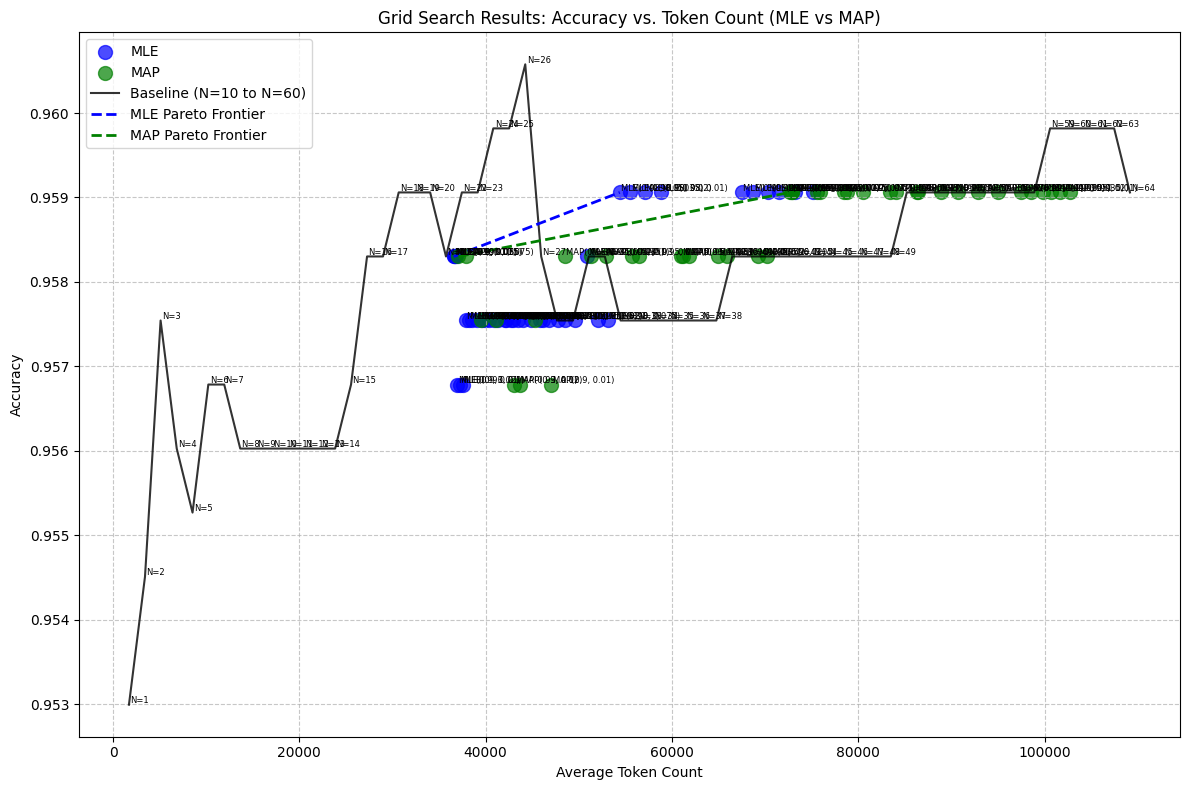


MLE Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9583, Avg Token Count: 36584.82
Target Score: 0.98, Percentile: 0.05, Accuracy: 0.9591, Avg Token Count: 54398.15

MAP Pareto-optimal configurations:
Target Score: 0.9, Percentile: 0.1, Accuracy: 0.9583, Avg Token Count: 37077.04
Target Score: 0.95, Percentile: 0.01, Accuracy: 0.9591, Avg Token Count: 72668.86


In [12]:
max_N_panel = 64
print("Target Score Panel:", target_score_panel_values)
print("Percentile Panel:", percentile_panel_values)
print("Max N:", max_N_panel)

# Evaluate MLE results
print("\nEvaluating MLE Results...")
truncated_normal_params_all = mle_estimated_params
mle_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MLE)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MLE Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MLE - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MLE - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        mle_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MLE_results_{max_N_panel}.json', 'w') as f:
    json.dump(mle_grid_search_results, f)


# Evaluate MAP results
print("\nEvaluating MAP Results...")
truncated_normal_params_all = map_estimated_params
map_grid_search_results = []

for target_score in tqdm(target_score_panel_values, desc="Target Score (MAP)"):
    for percentile in tqdm(percentile_panel_values, desc="Percentile", leave=False):
        min_N_required = []
        for i, (mu, sigma) in enumerate(truncated_normal_params_all):
            min_N = find_min_N_for_threshold(mu, sigma, target_score=target_score, 
                                        percentile=percentile, max_N=max_N_panel)
            if min_N < peek_number:
                min_N = peek_number
            min_N_required.append(min_N)
        print("MAP Min N Required", min_N_required)
        
        # Evaluate model performance with these parameters
        correct = 0
        entire_token_count = 0

        for idx, item in enumerate(val_texts):
            N = min_N_required[idx]
            completions = val_completions[idx][0][:N]
            scores = val_scores[idx][0][:N]
            completion_tokens = val_completion_tokens[idx][0][:N]
            total_tokens = sum(completion_tokens)

            highest_scores_idx = scores.index(max(scores))

            while completions[highest_scores_idx] == "":
                scores[highest_scores_idx] = 0 
                if max(scores) == 0: 
                    break
                highest_scores_idx = scores.index(max(scores))

            output = completions[highest_scores_idx]
            answer = get_answer(output)

            if verify_extracted_answer(val_gt_answers[idx], answer):
                correct += 1
            entire_token_count += total_tokens

        accuracy = correct / len(val_texts)
        average_token_count = entire_token_count / len(val_texts)
        
        print(f"MAP - Target Score: {target_score}, Percentile: {percentile}")
        print(f"MAP - Accuracy: {accuracy:.4f}, Average Token Count: {average_token_count:.2f}")
        
        map_grid_search_results.append({
            'target_score': target_score,
            'percentile': percentile,
            'accuracy': accuracy,
            'average_token_count': average_token_count
        })
        
with open(f'{DATASET}_OptScale_MAP_results_{max_N_panel}.json', 'w') as f:
    json.dump(map_grid_search_results, f)

plot_mle_map_optscale(mle_grid_search_results, map_grid_search_results, baseline_average_token_counts, baseline_accuracy_values, max_N_panel)